In [1]:
library(ape)
library(sitePath)

Warning message:
"package 'sitePath' was built under R version 3.6.3"


In [2]:
data(h3n2_align)
data(h3n2_tree)

In [79]:
tree <- addMSA(h3n2_tree, alignment = h3n2_align)

In [80]:
paths <- lineagePath(tree, similarity = 0.023)

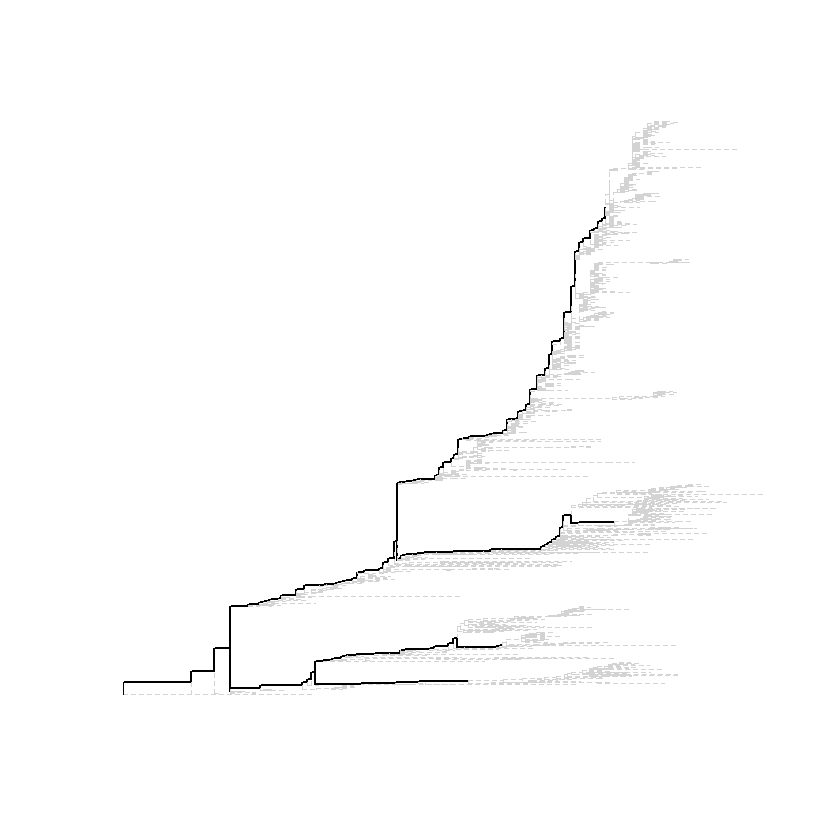

In [81]:
plot(paths)

In [82]:
fixationlineages <- function (paths,
                              minEffectiveSize = NULL,
                              searchDepth = 1,
                              method = c("compare", "insert", "delete"),
                              ...) {
    tree <- attr(paths, "tree")
    nTips <- length(tree[["tip.label"]])
    align <- attr(paths, "align")
    # Generate the site mapping from reference
    reference <- attr(paths, "reference")
    # Decide which miniminzing strategy
    minimizeEntropy <- switch(
        match.arg(method),
        "compare" = sitePath:::minEntropyByComparing,
        "insert" = sitePath:::minEntropyByInserting,
        "delete" = sitePath:::minEntropyByDeleting
    )
    # Get the 'minEffectiveSize' for each fixation
    if (is.null(minEffectiveSize)) {
        minEffectiveSize <- nTips / length(unique(unlist(paths)))
    } else if (!is.numeric(minEffectiveSize)) {
        stop("\"minEffectiveSize\" only accepts numeric")
    }
    minEffectiveSize <- ceiling(minEffectiveSize)
    # Get the 'searchDepth' for heuristic search
    if (searchDepth < 1) {
        stop("\"searchDepth\" should be at least 1")
    } else {
        searchDepth <- ceiling(searchDepth)
    }
    divNodes <- sitePath:::divergentNode(paths)
    nodeAlign <- sitePath:::.tipSeqsAlongPathNodes(
        paths = paths,
        divNodes = divNodes,
        tree = tree,
        align = align
    )
    res <- sitePath:::.findFixationSite(
        paths = paths,
        tree = tree,
        align = align,
        nodeAlign = nodeAlign,
        divNodes = divNodes,
        reference = reference,
        minimizeEntropy = minimizeEntropy,
        minEffectiveSize = minEffectiveSize,
        searchDepth = searchDepth
    )
    attr(res, "paths") <- paths
    attr(res, "reference") <- reference
    class(res) <- "fixationSites"
    return(res)
}

In [113]:
m <- fixationSites(paths)

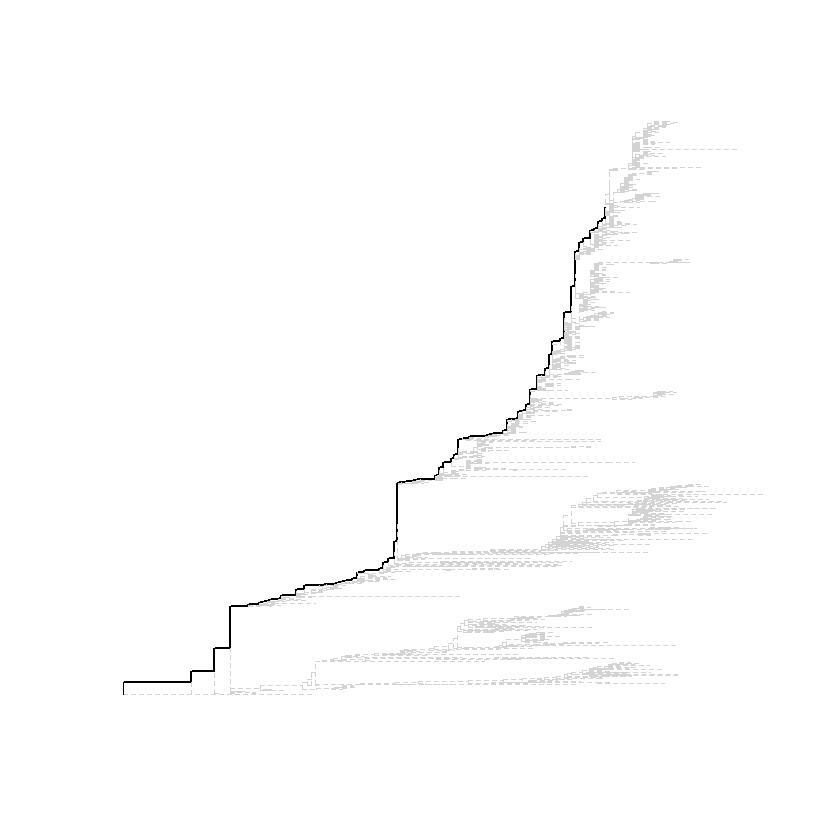

In [119]:
singlePath <- paths[[3]]
attributes(singlePath) <- attributes(paths)
plot(singlePath)

In [83]:
mutations <- fixationlineages(paths)

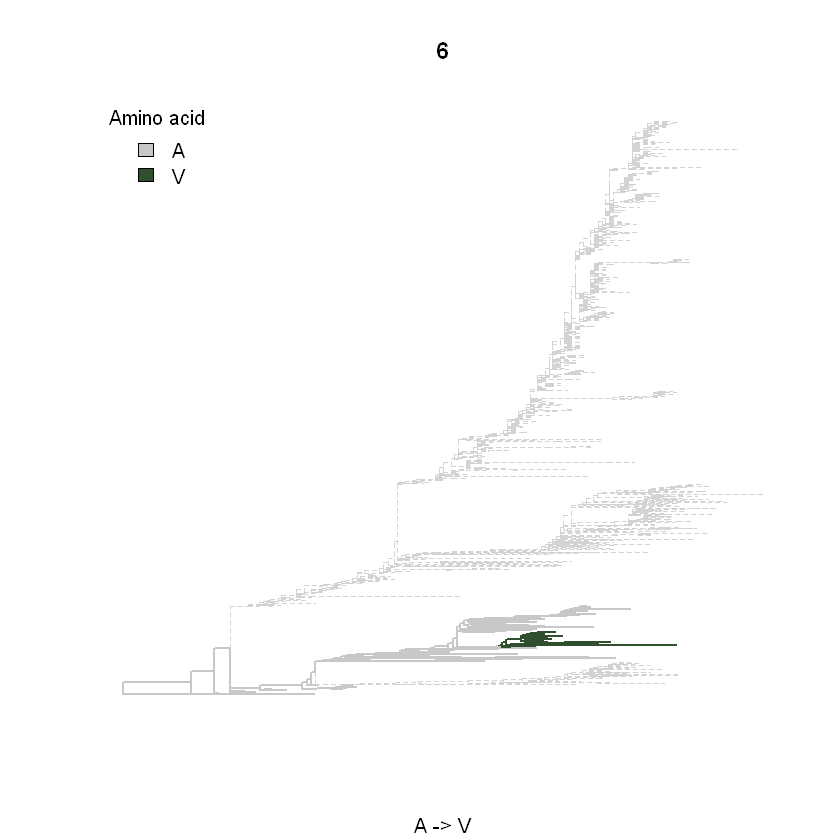

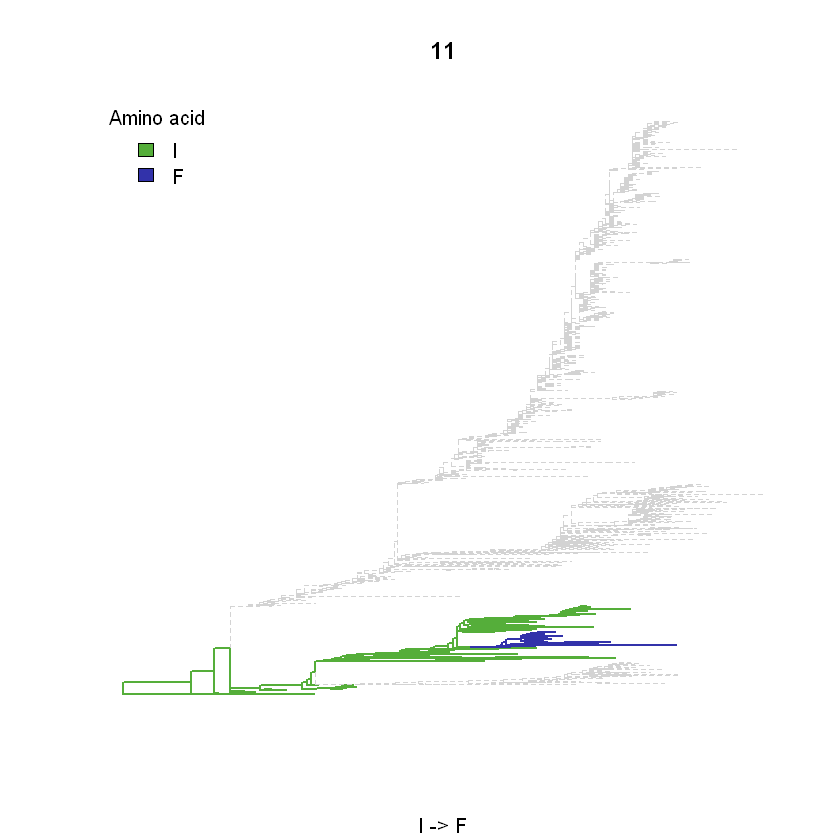

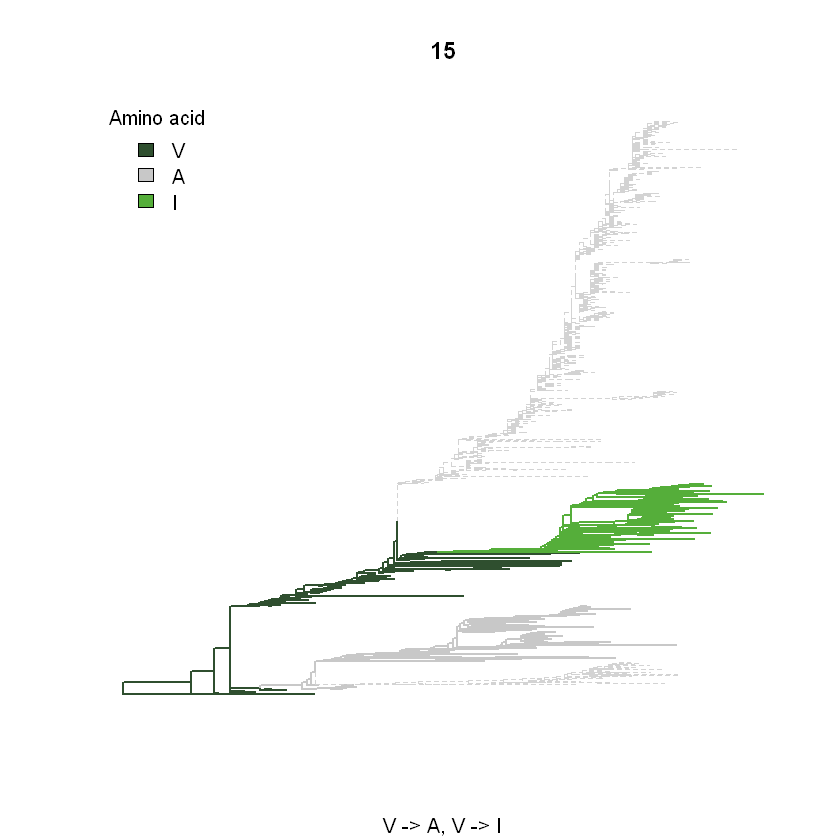

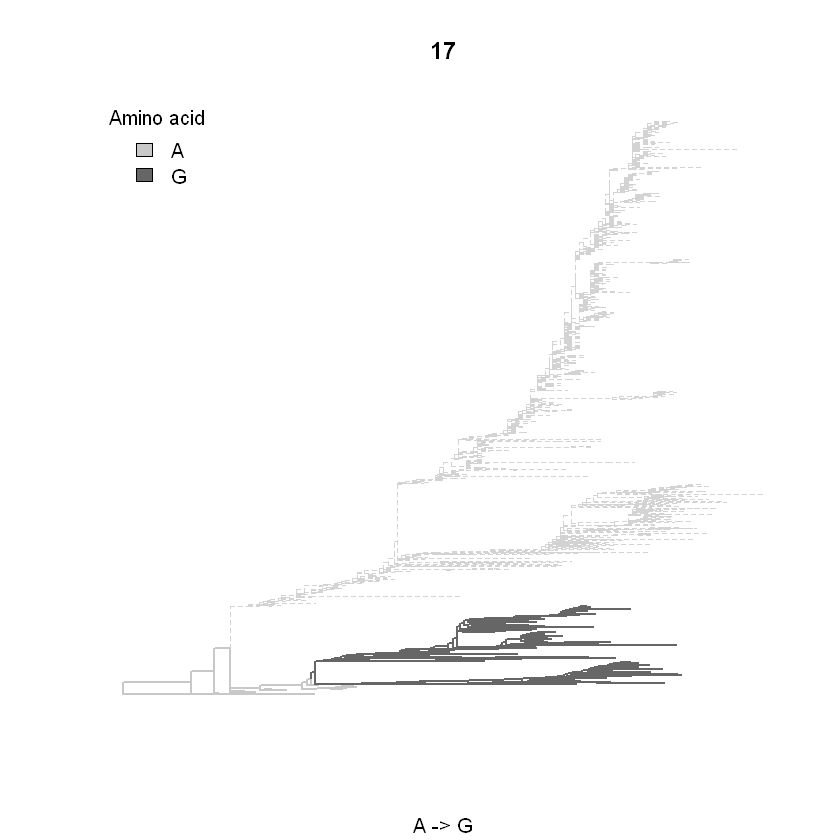

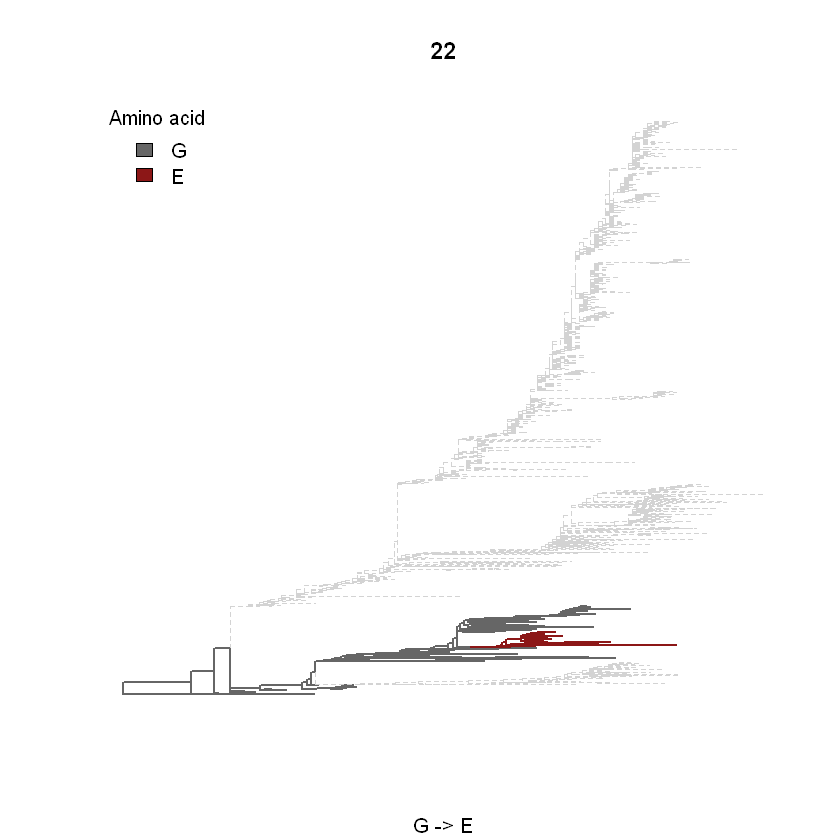

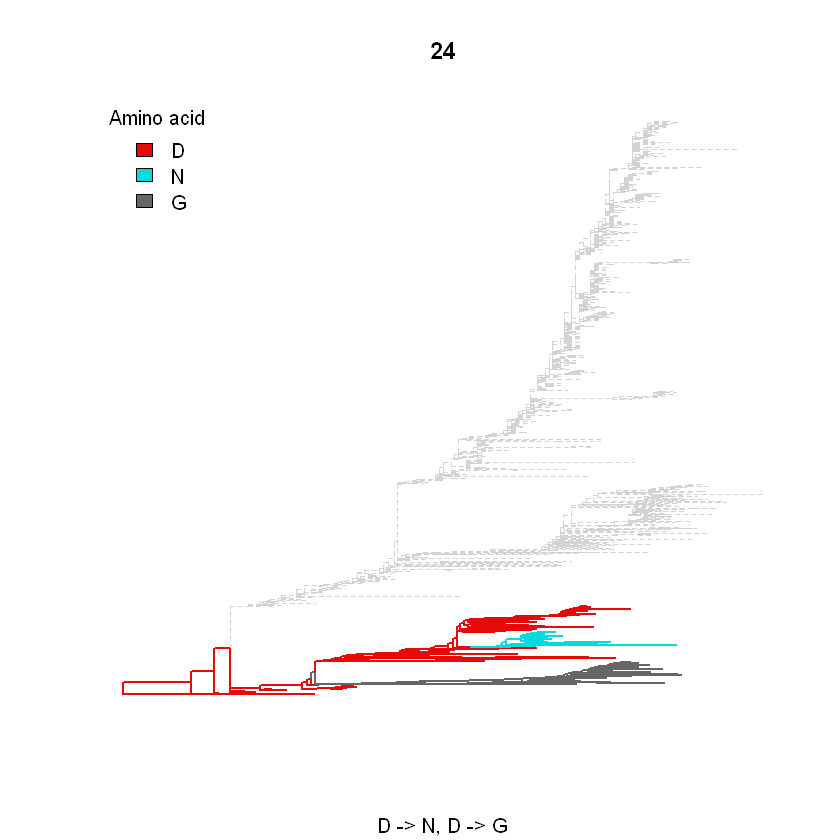

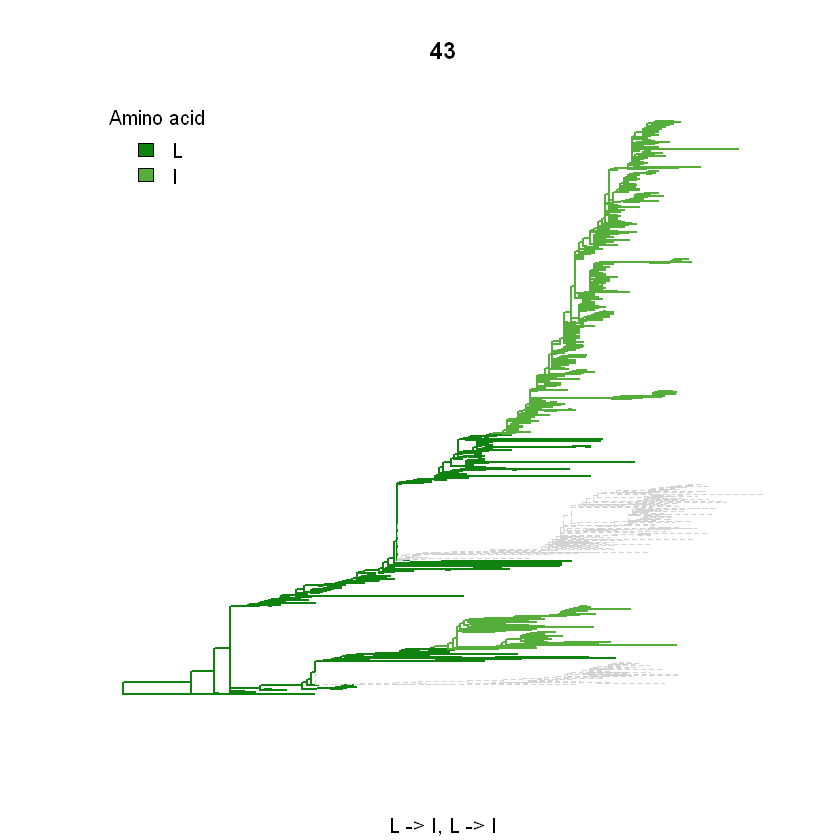

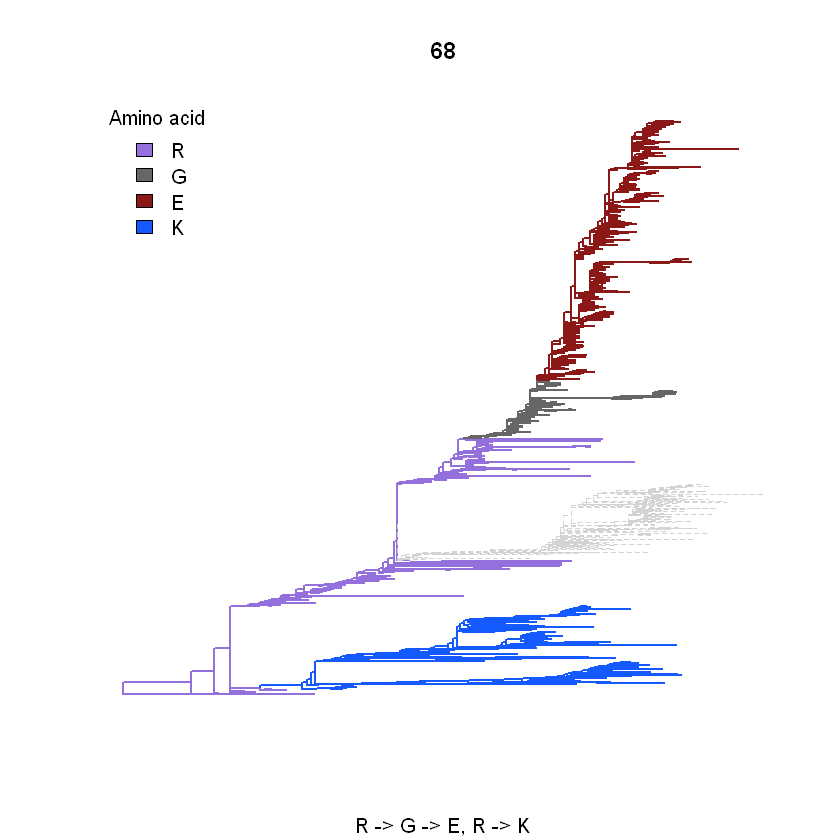

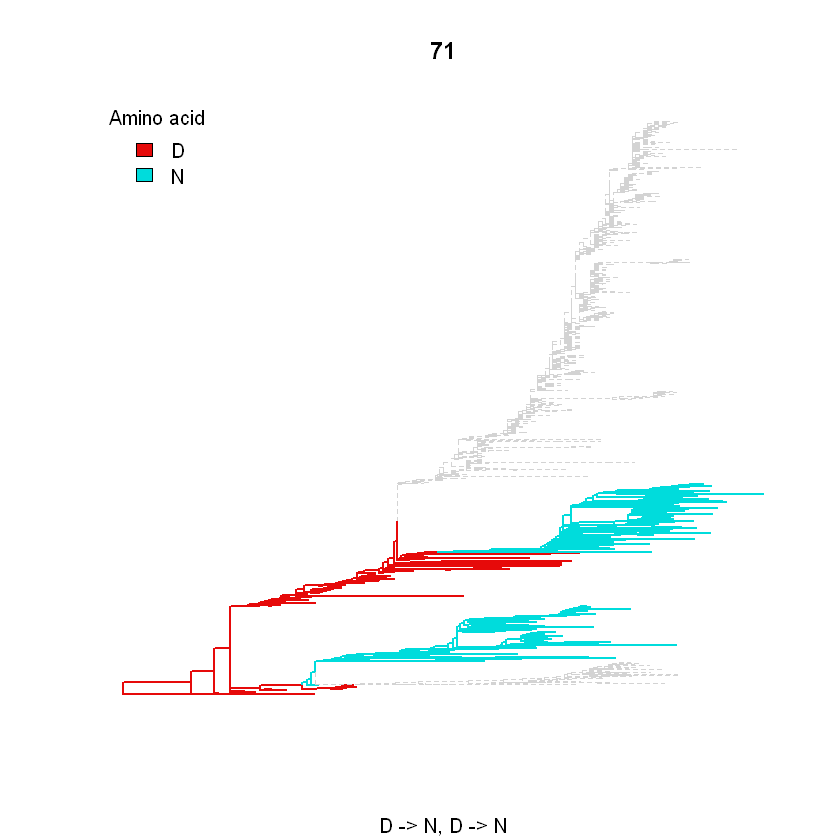

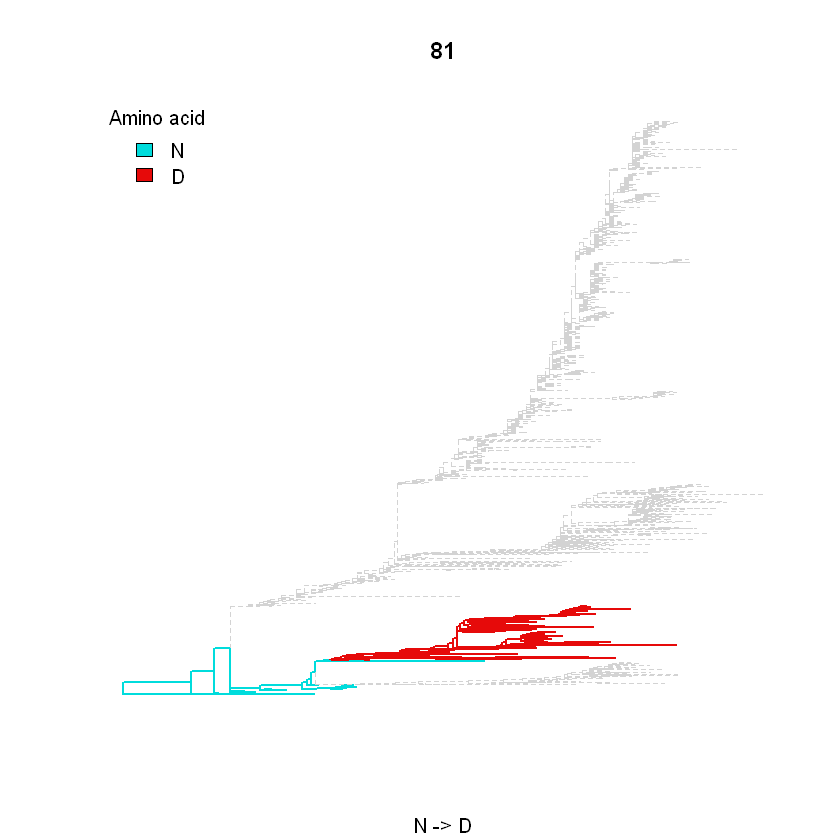

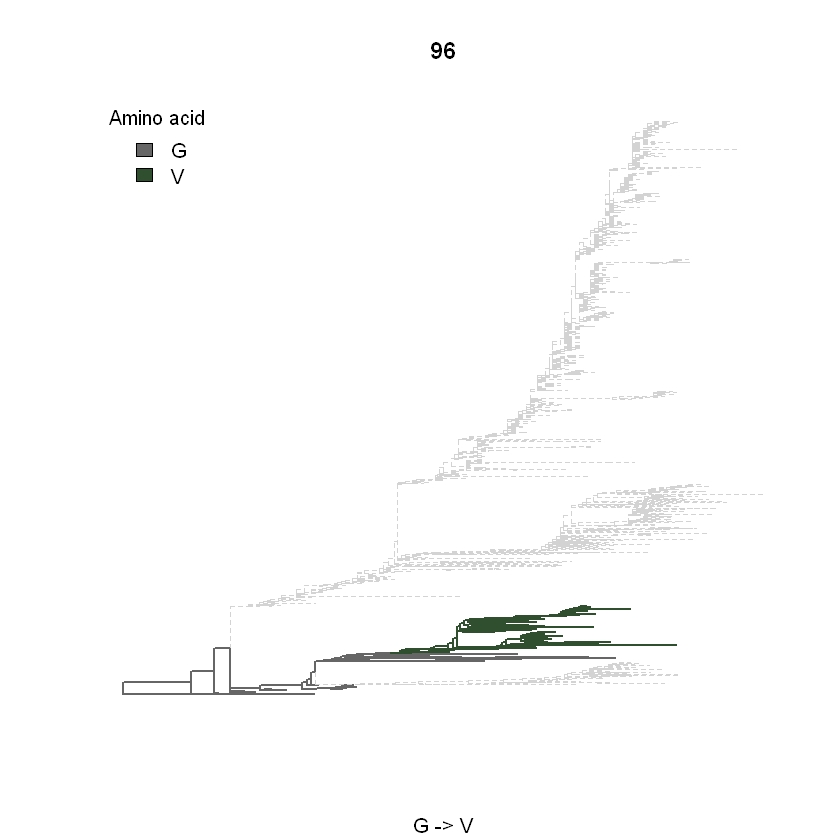

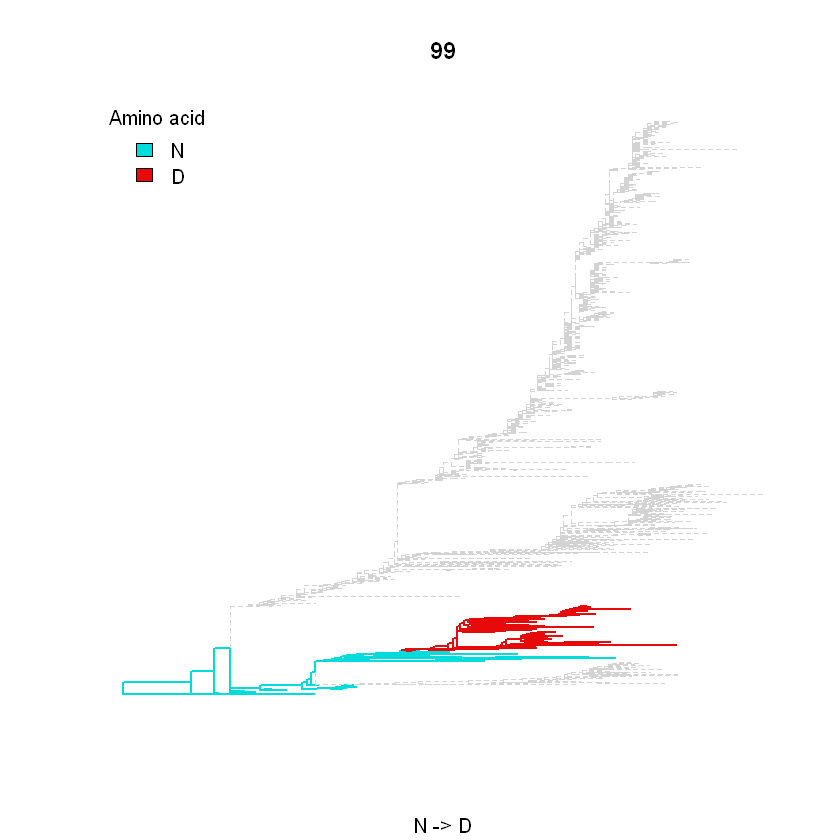

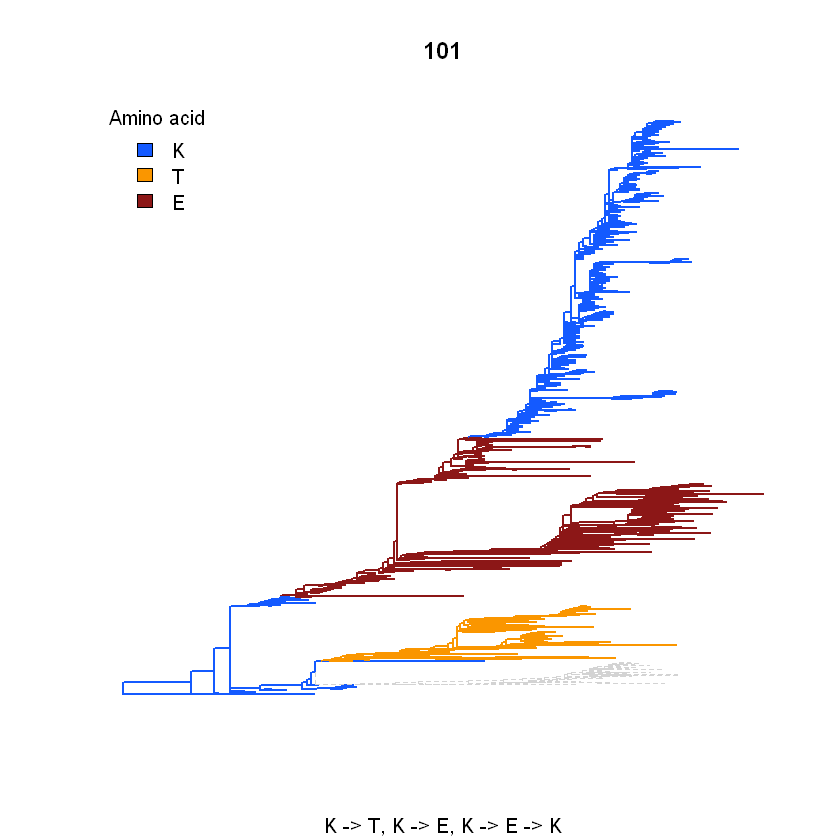

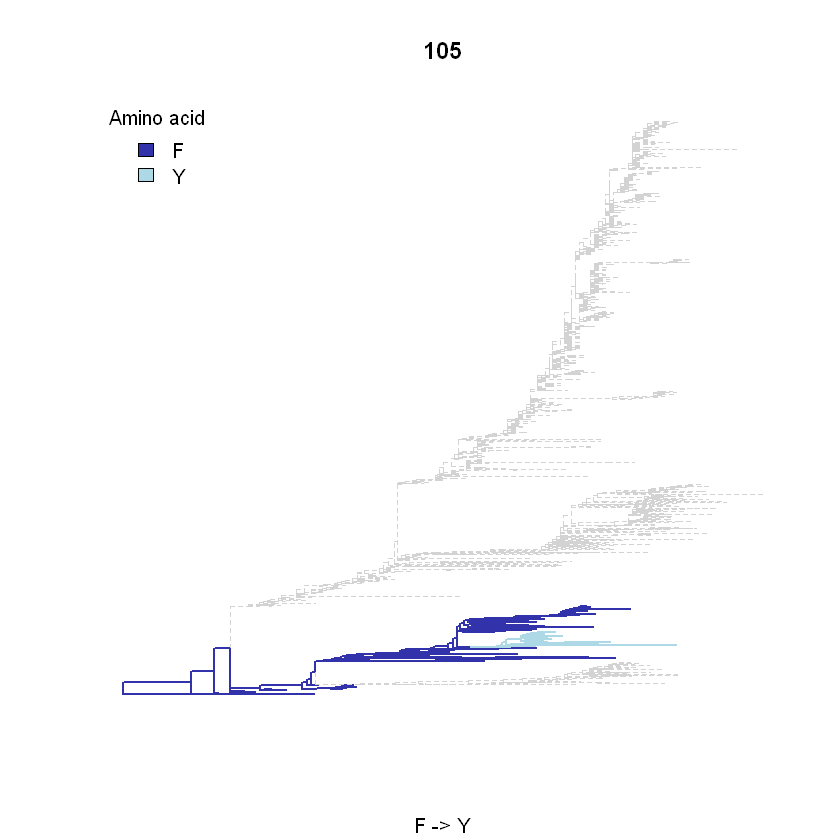

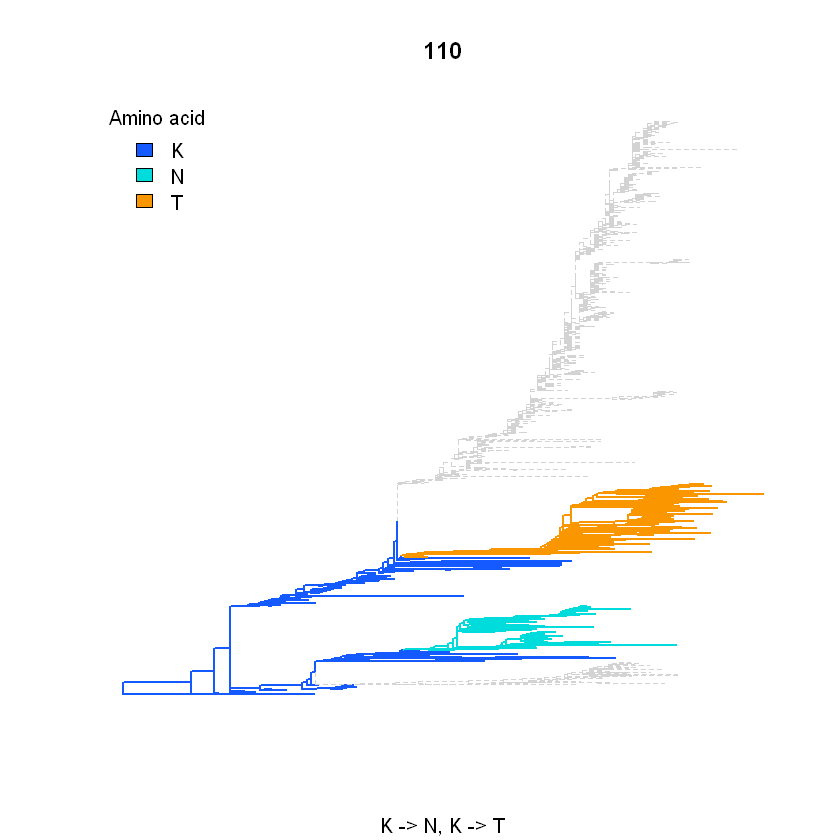

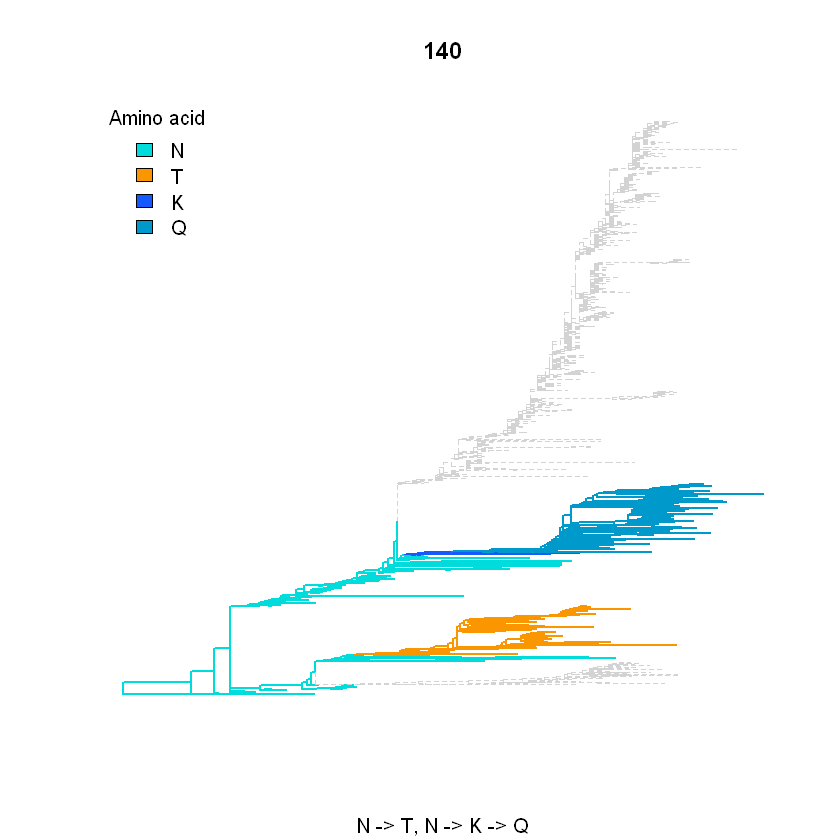

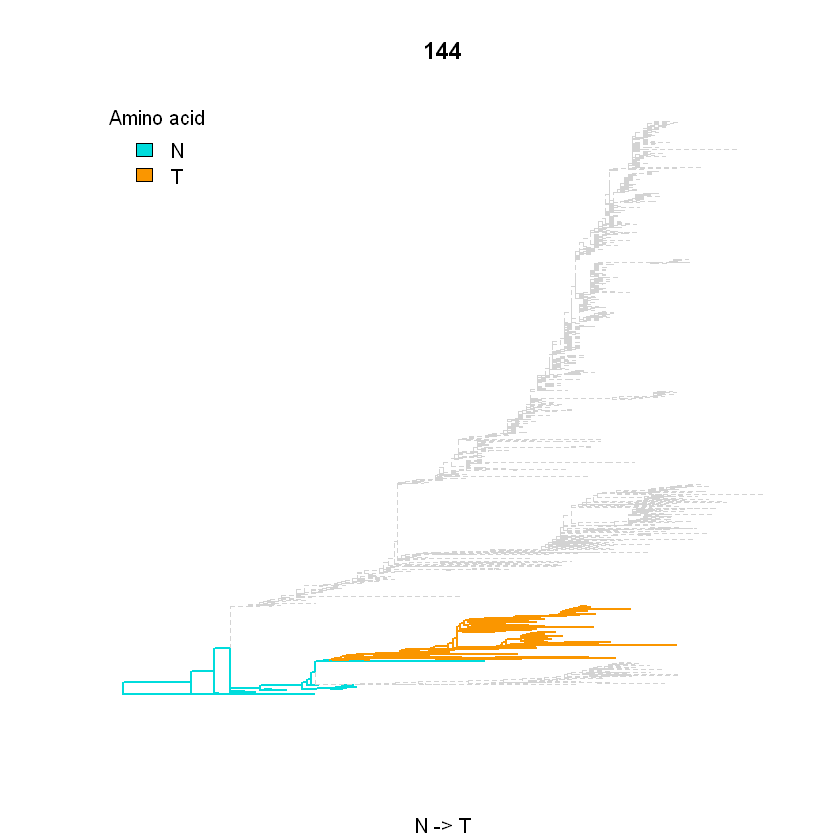

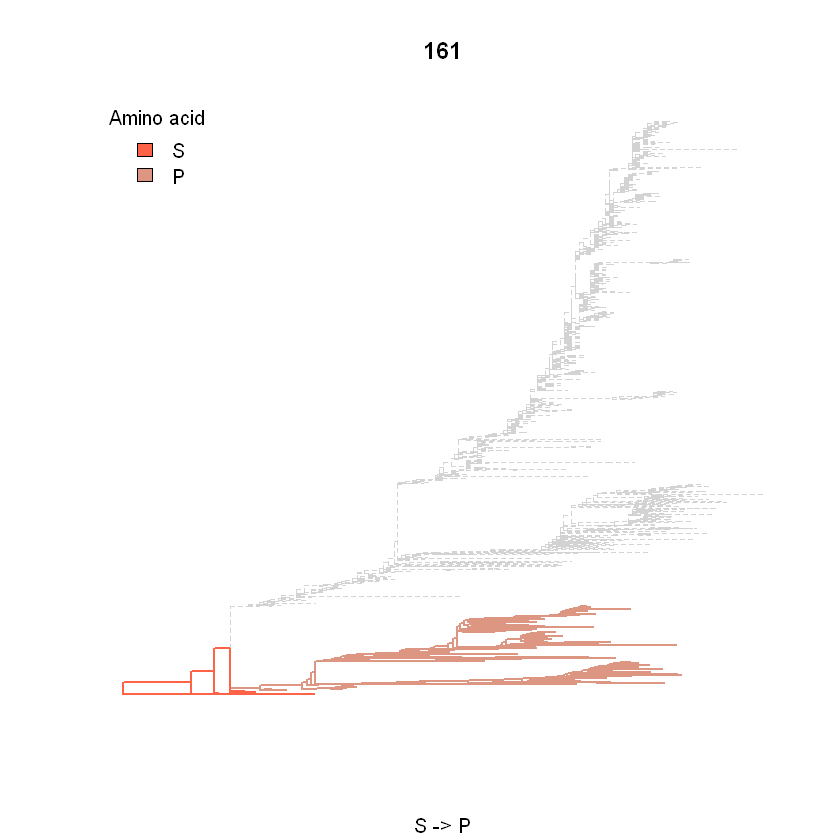

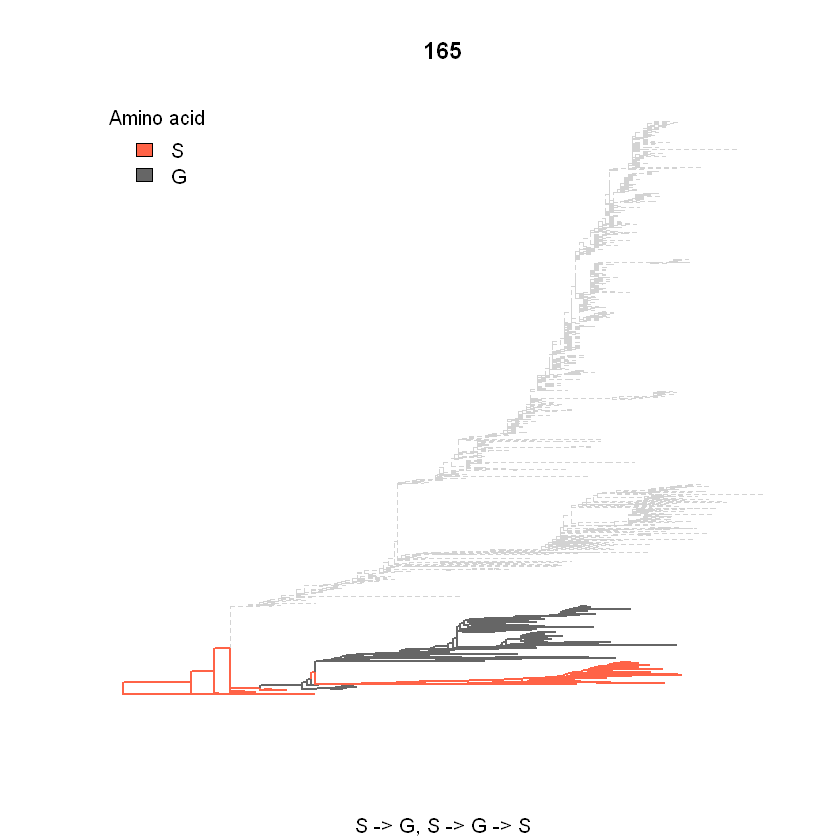

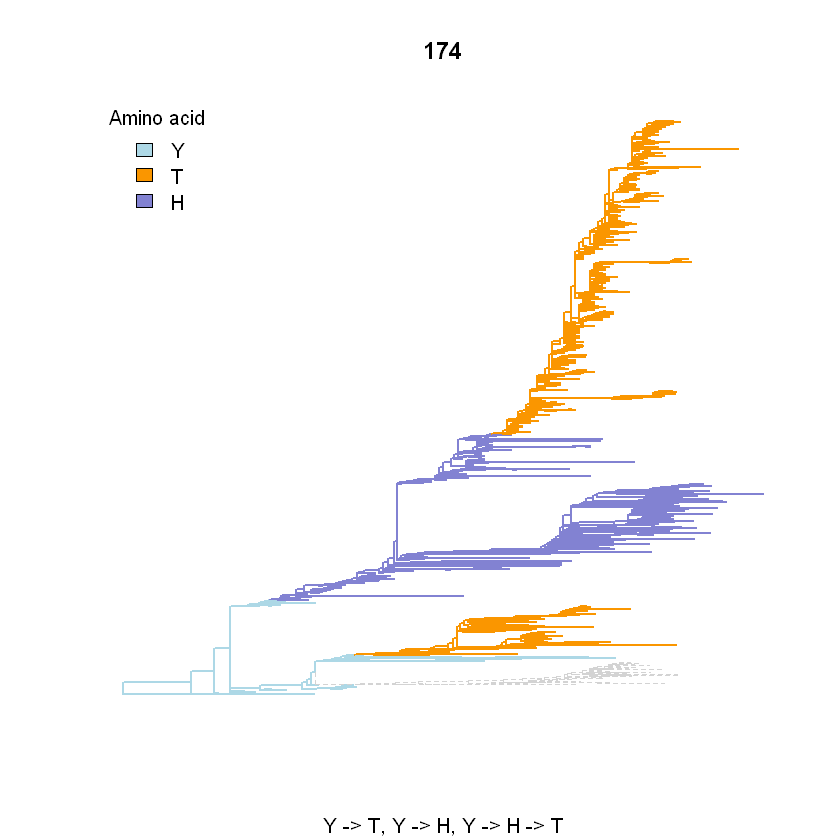

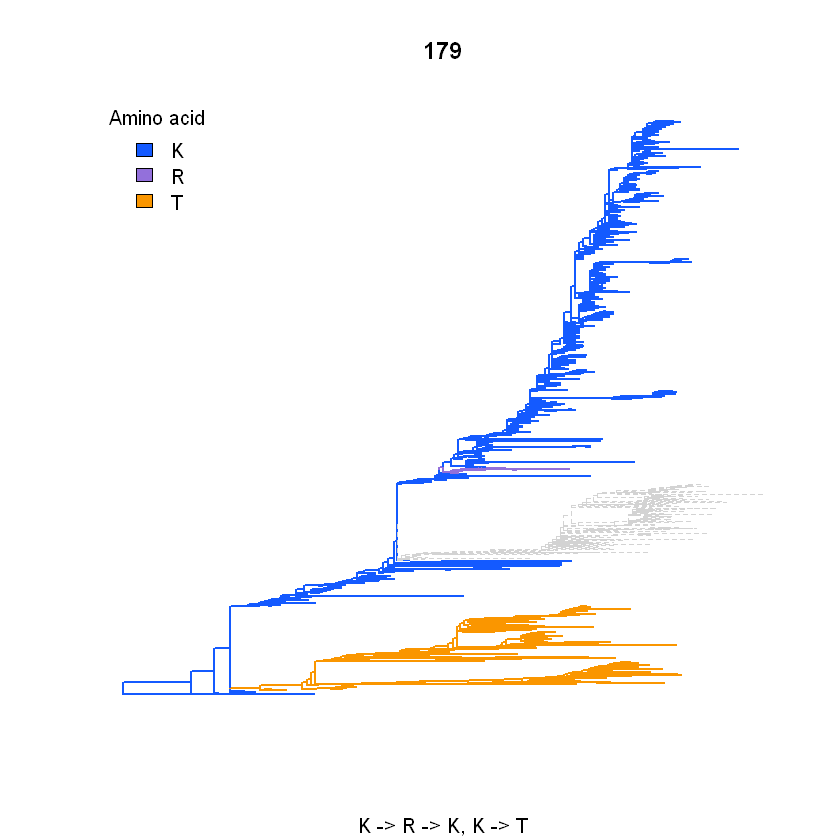

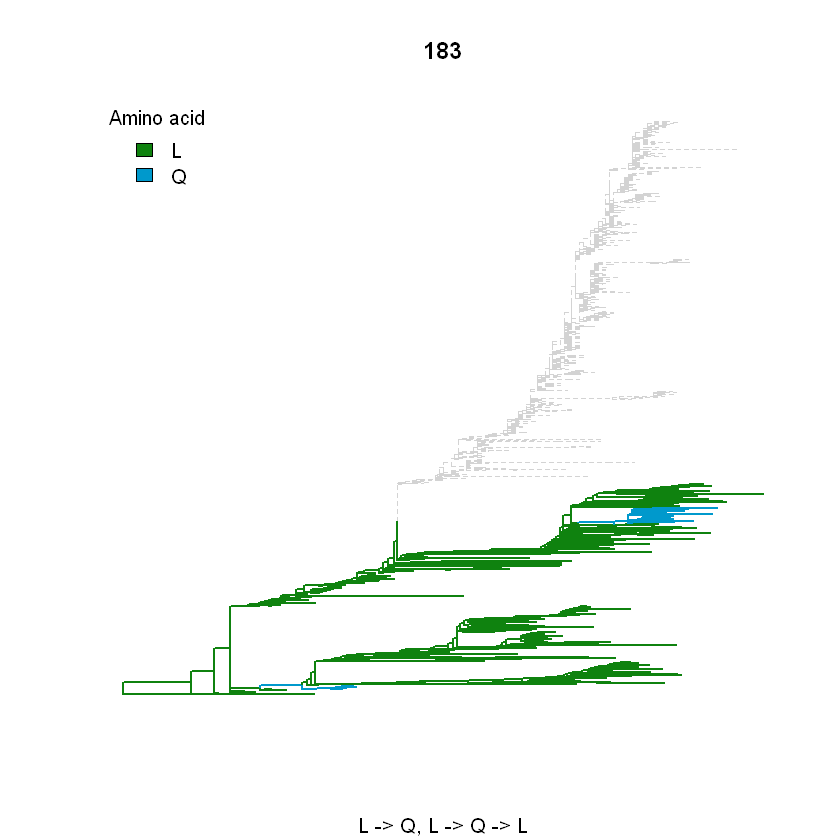

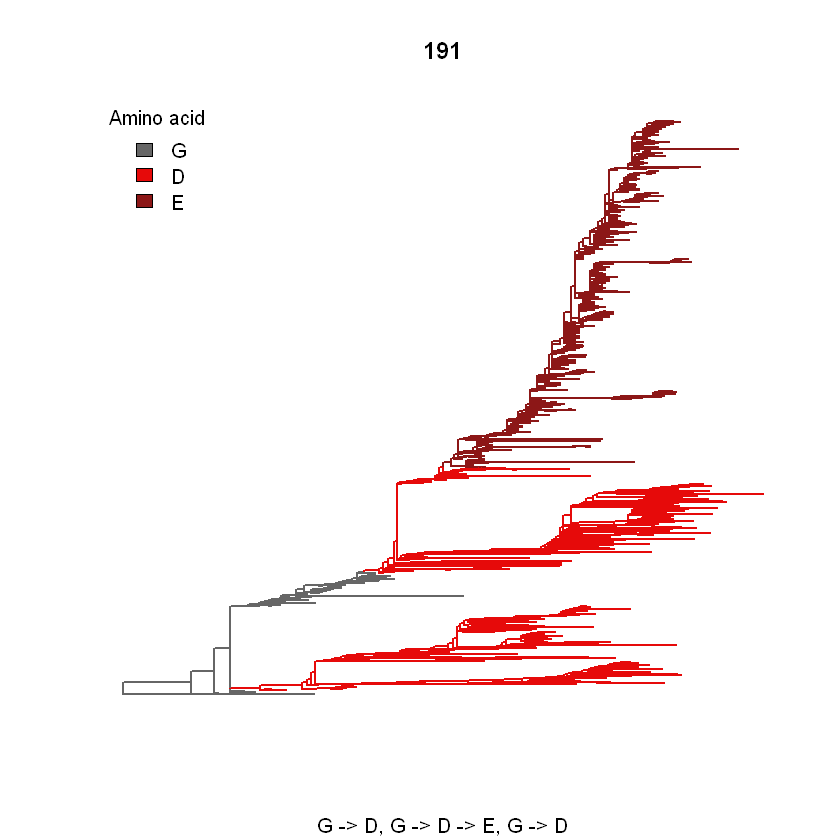

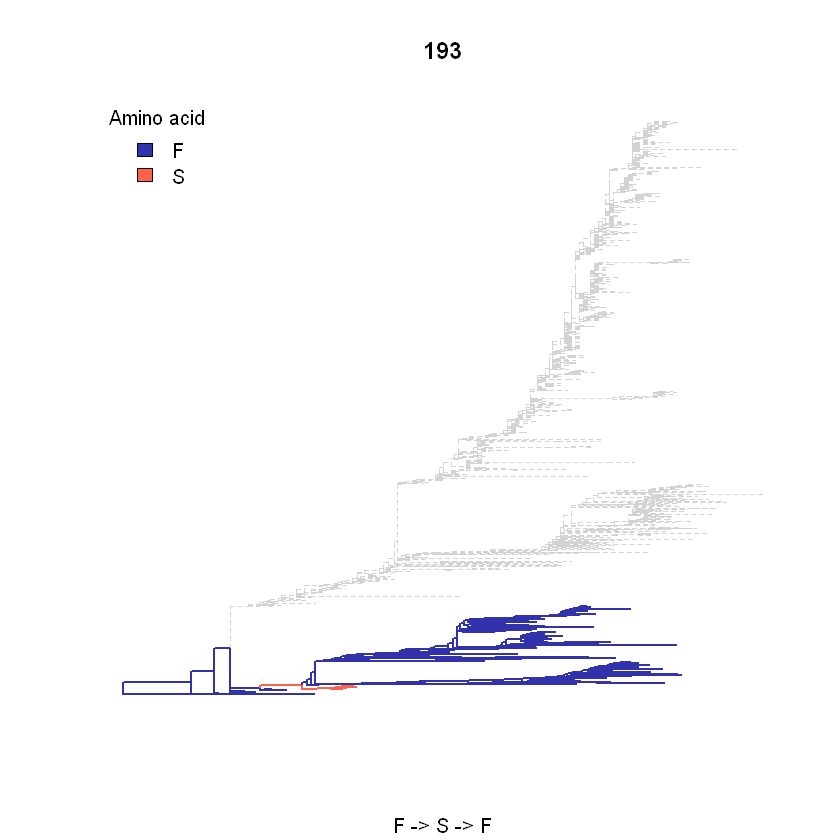

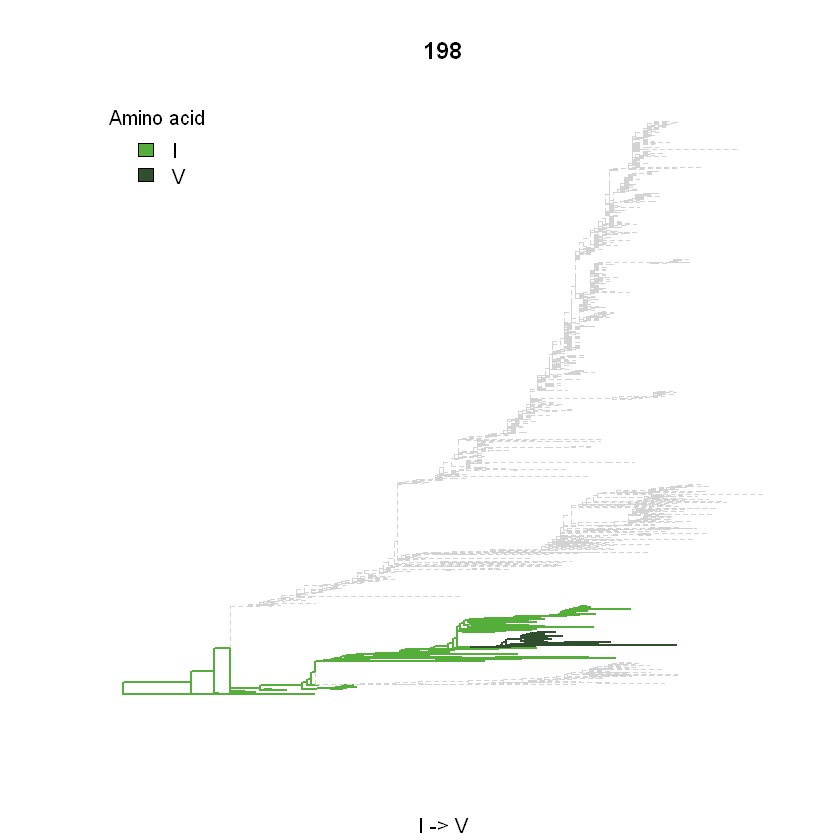

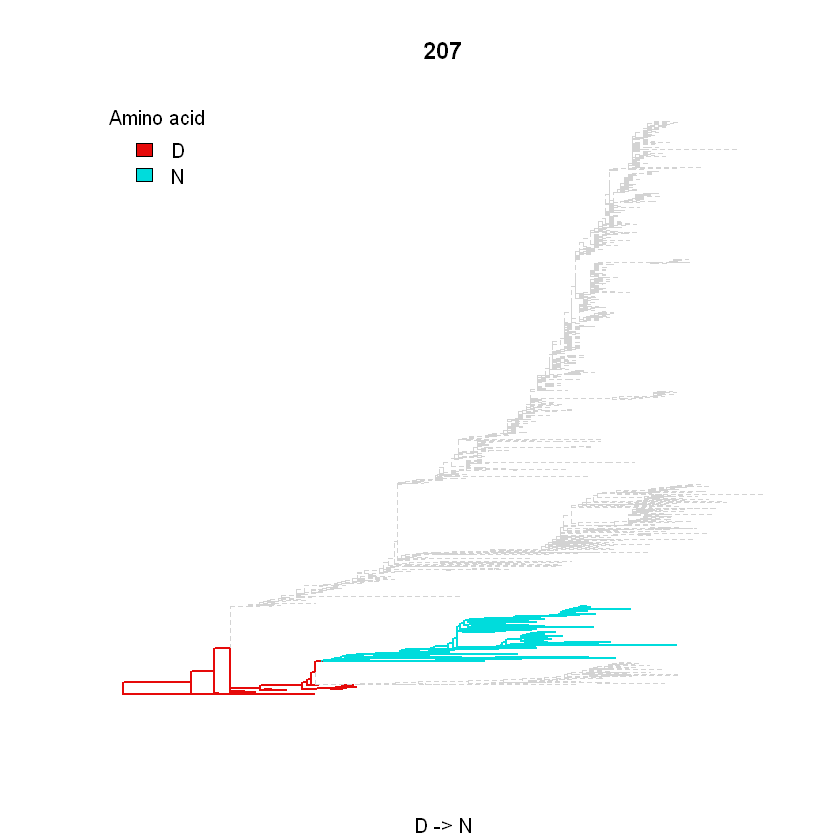

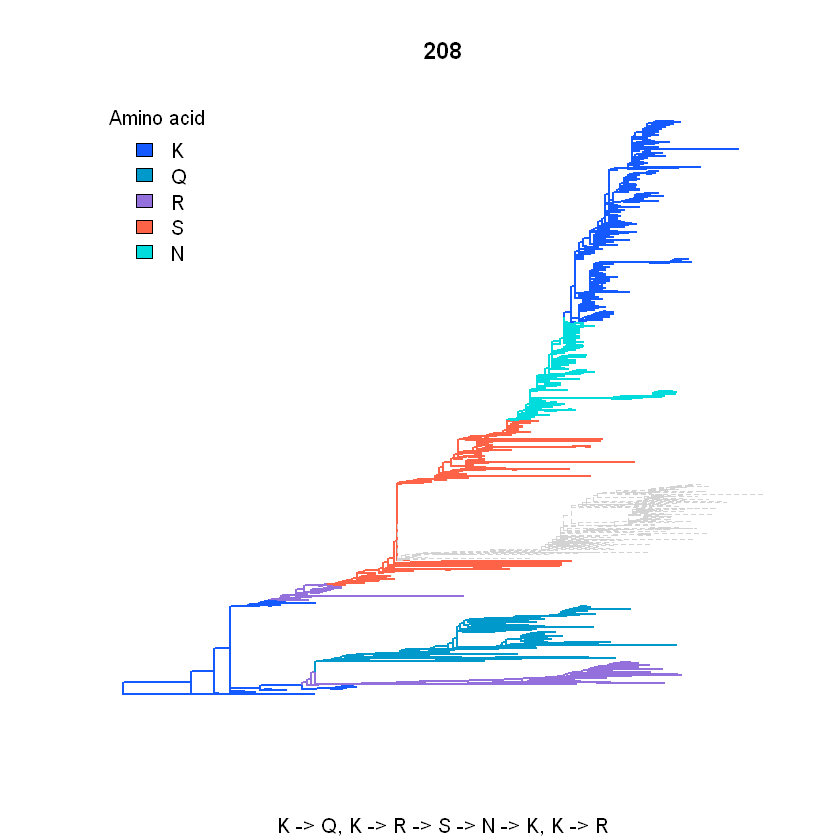

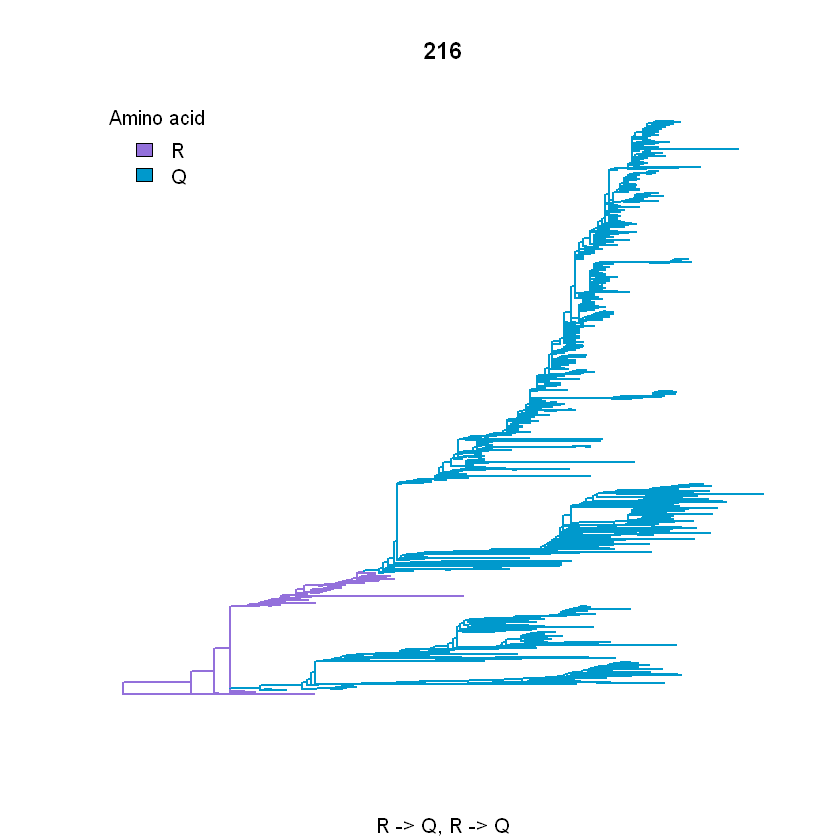

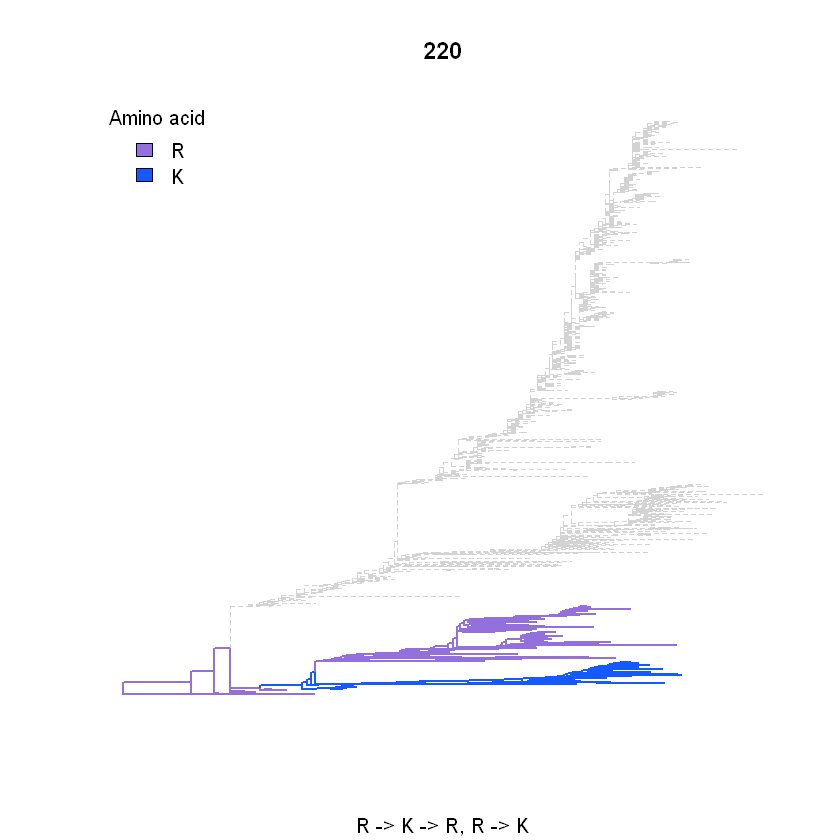

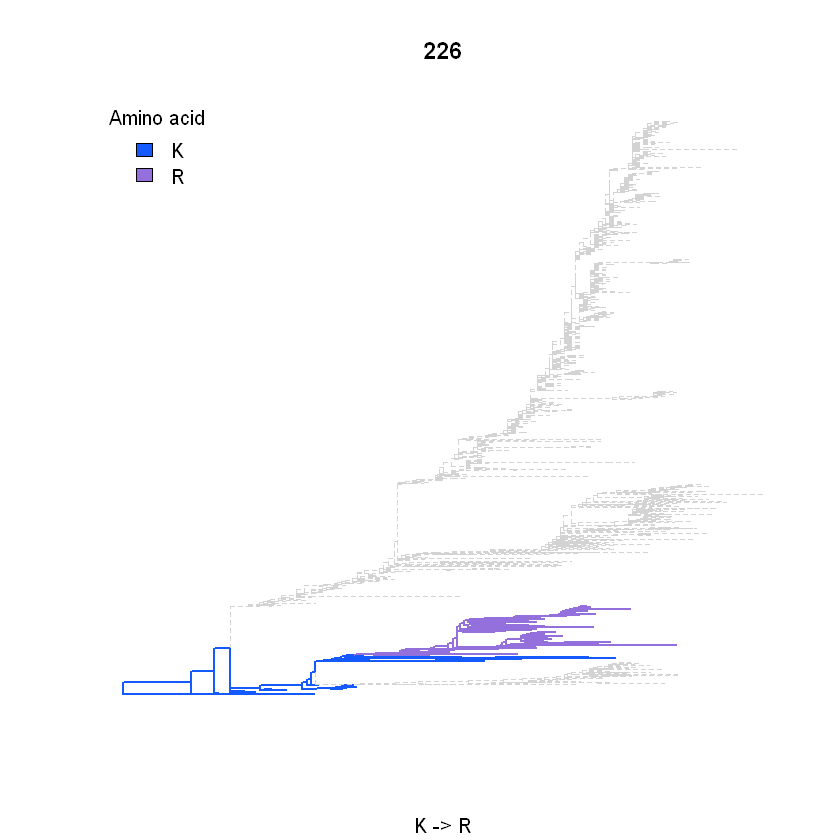

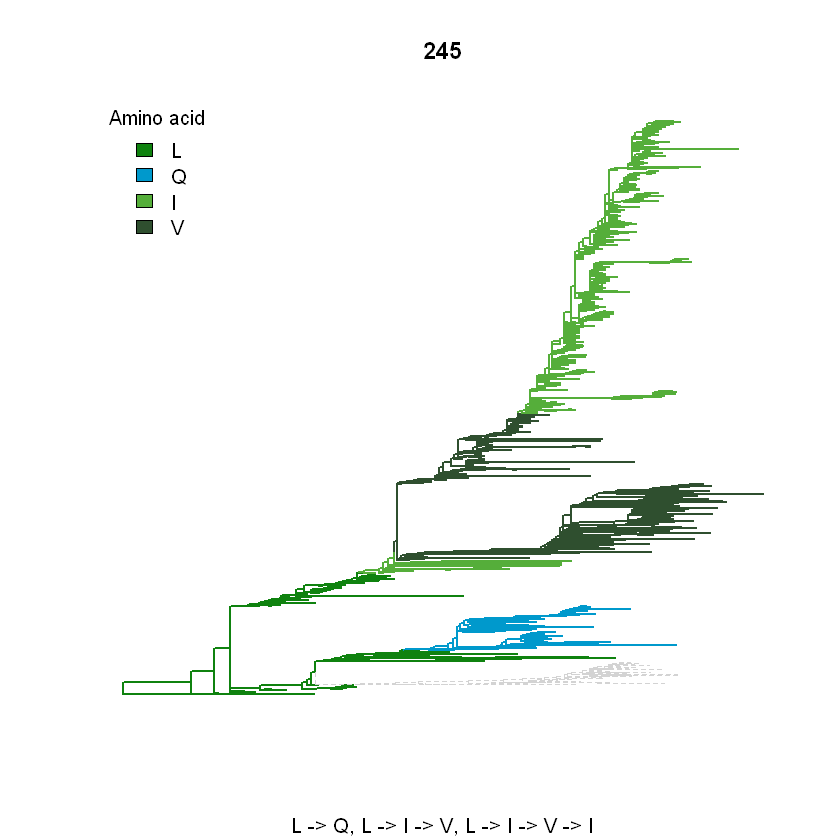

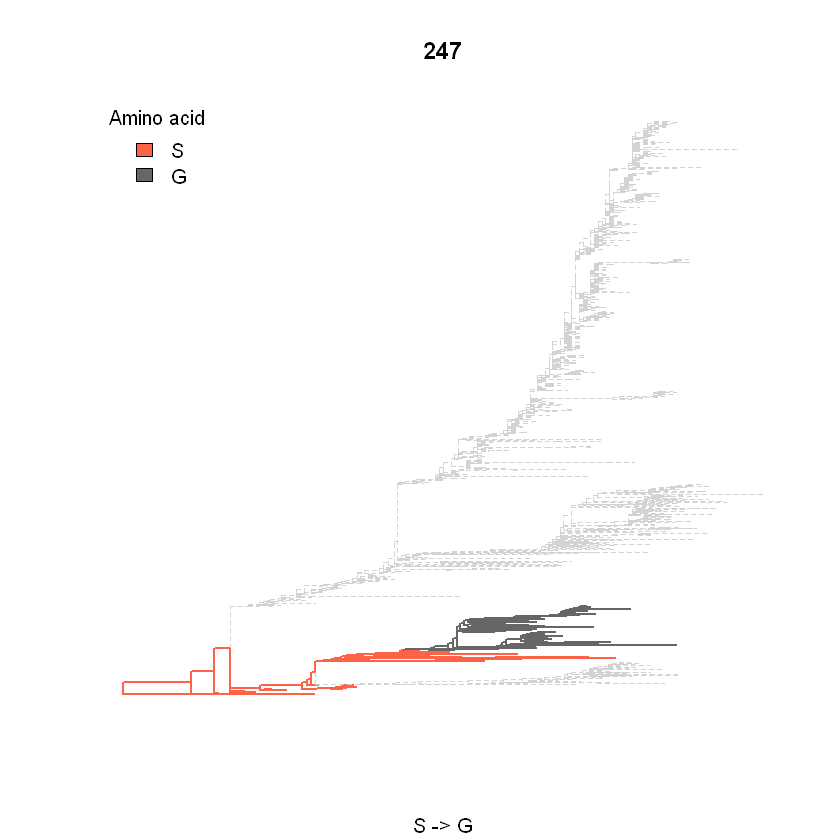

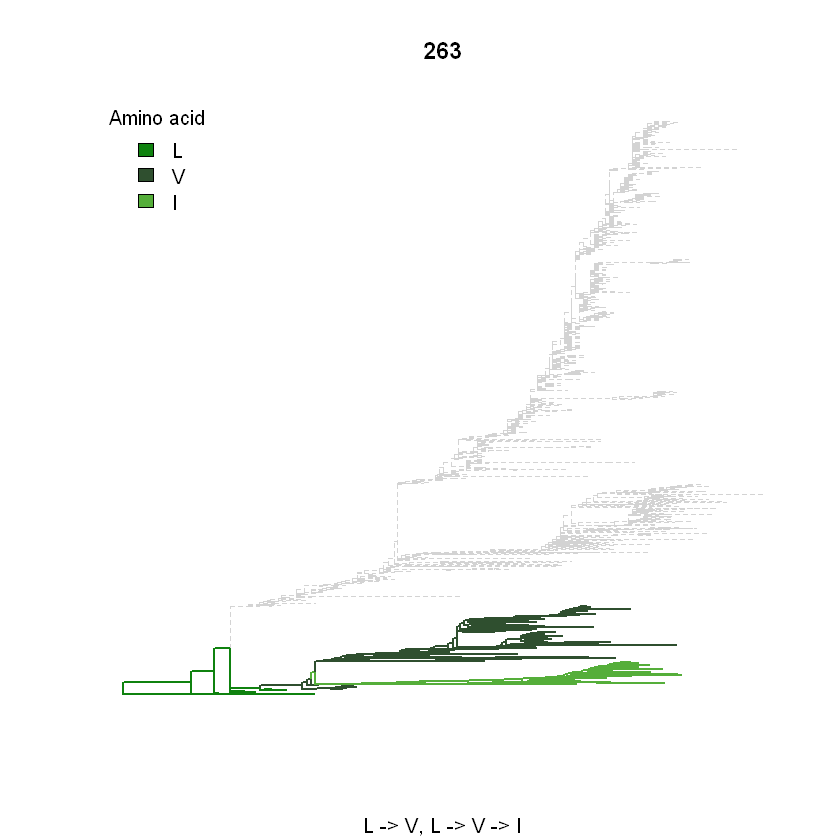

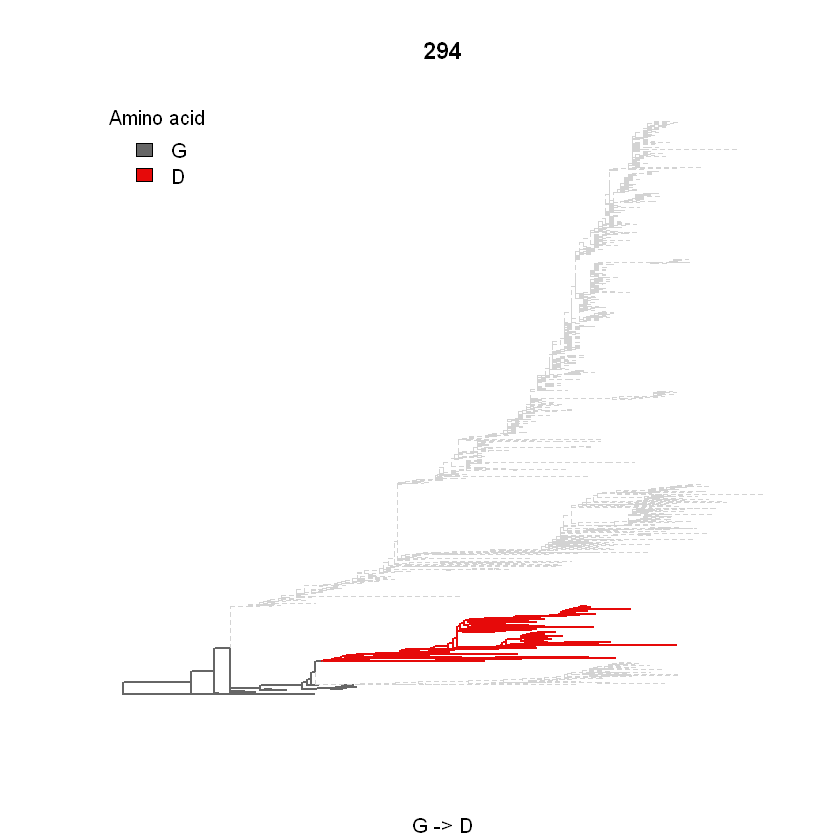

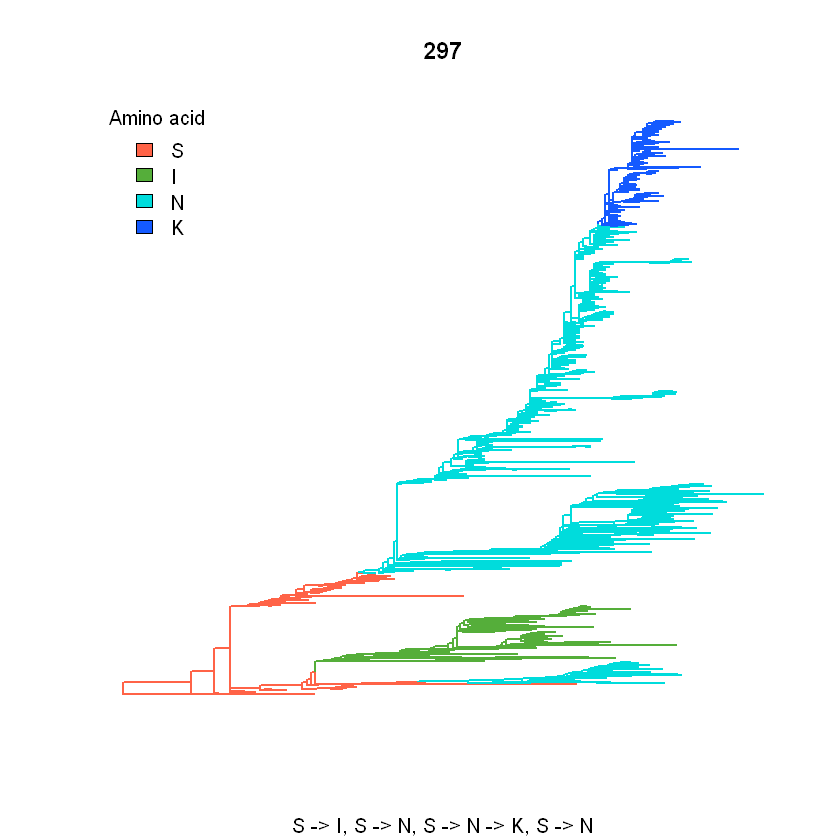

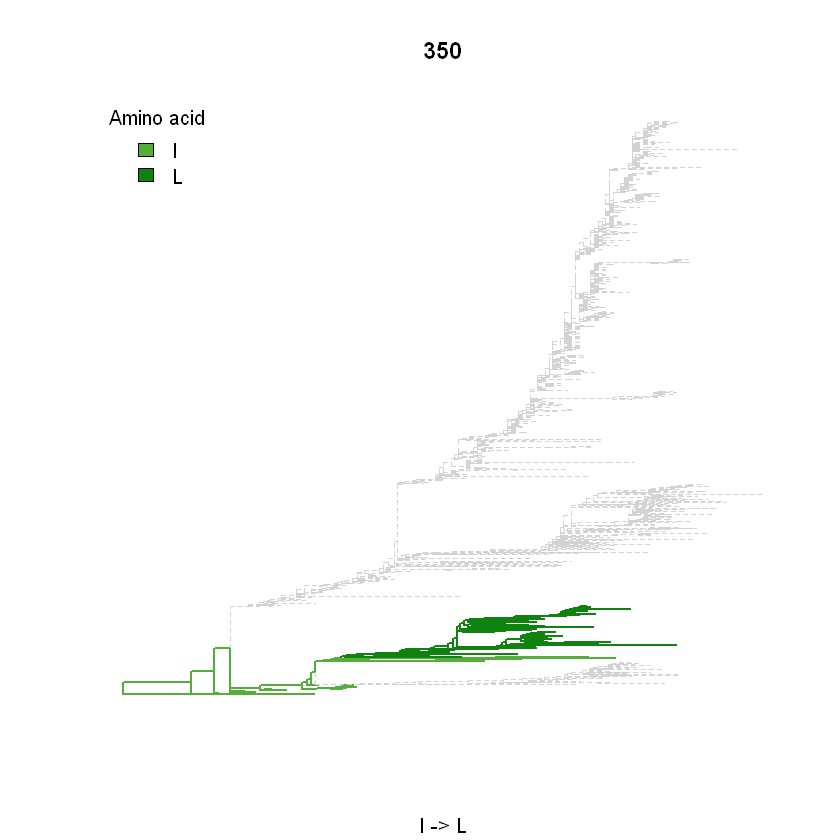

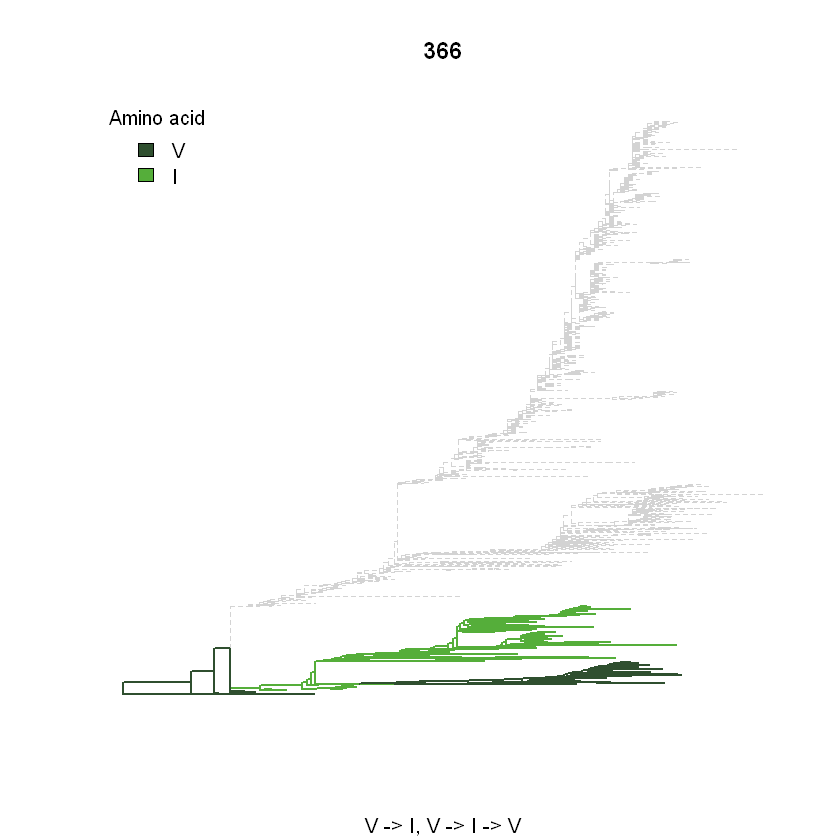

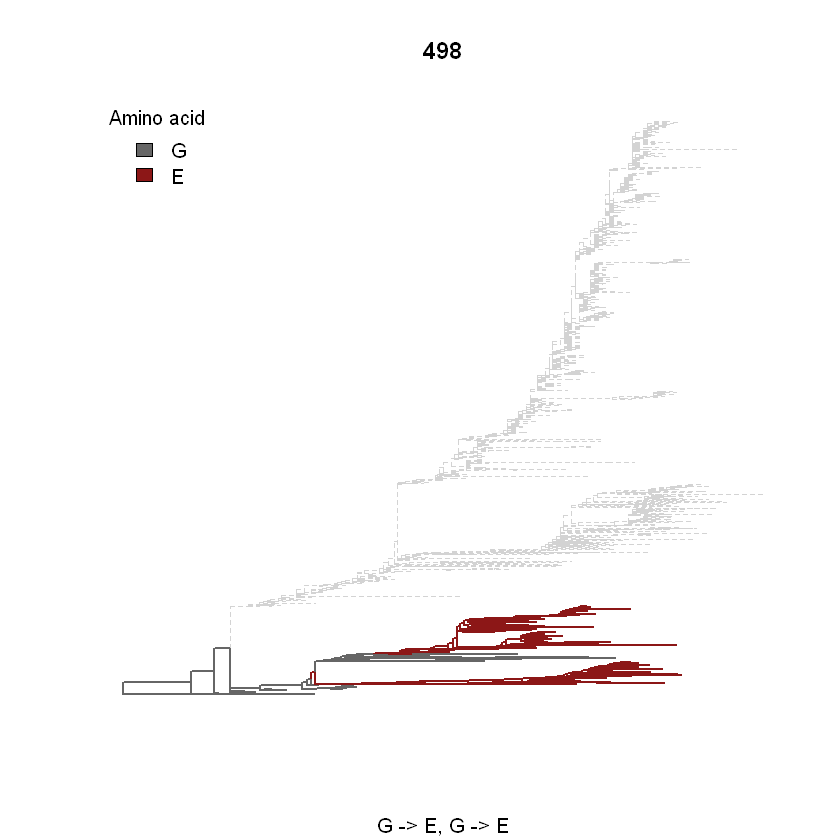

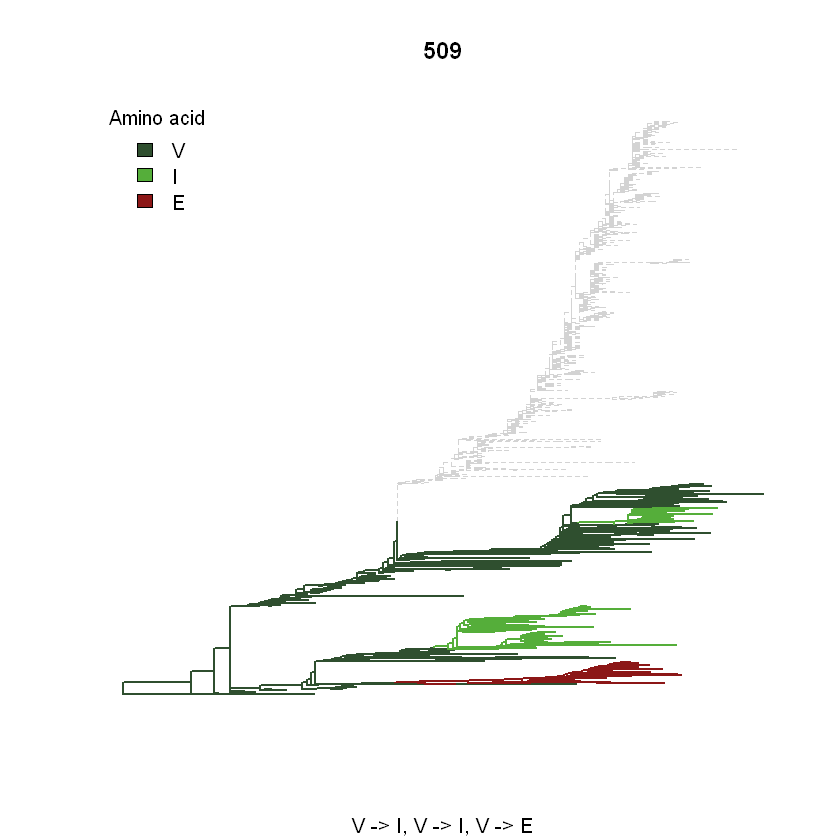

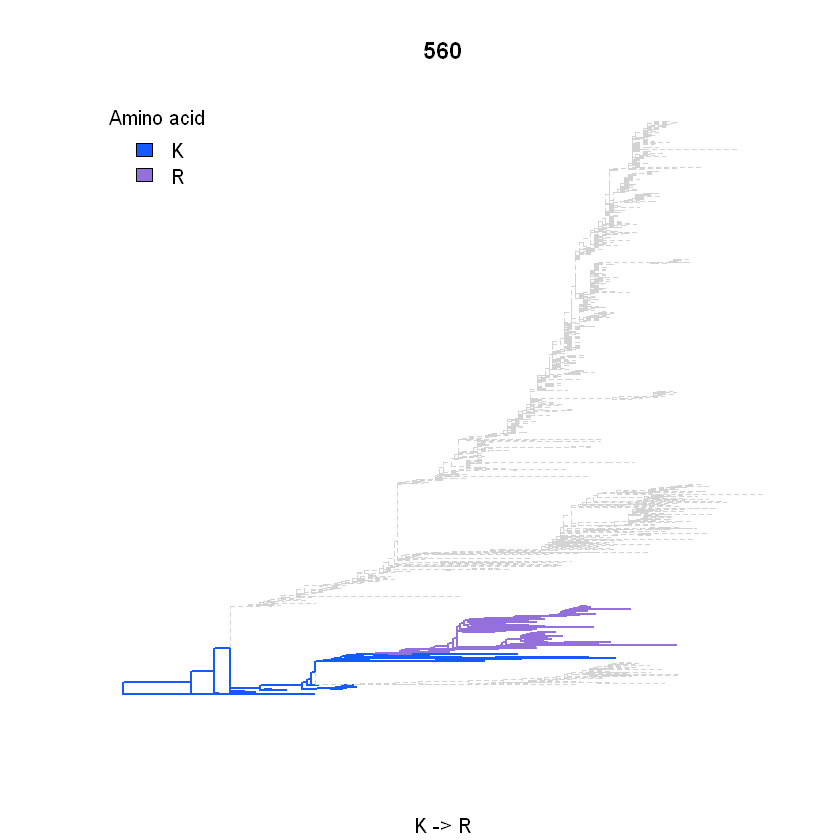

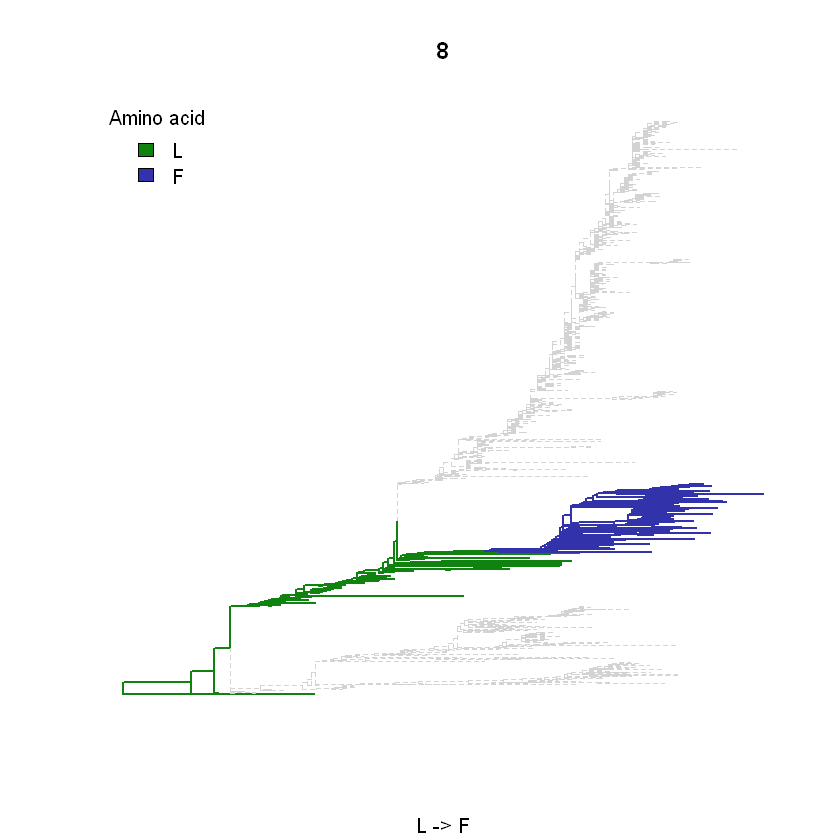

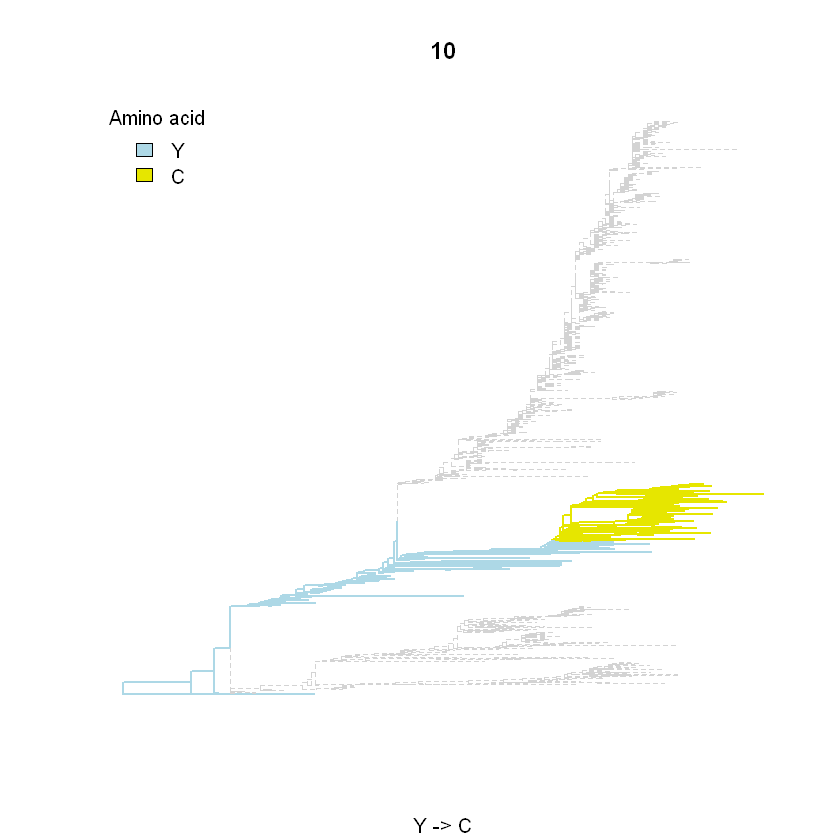

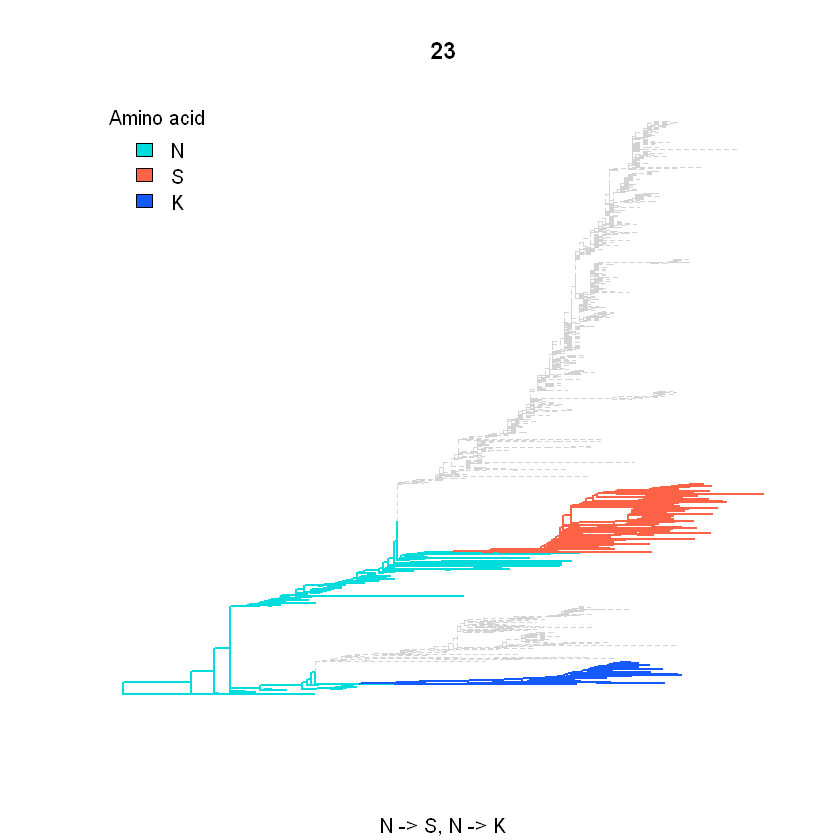

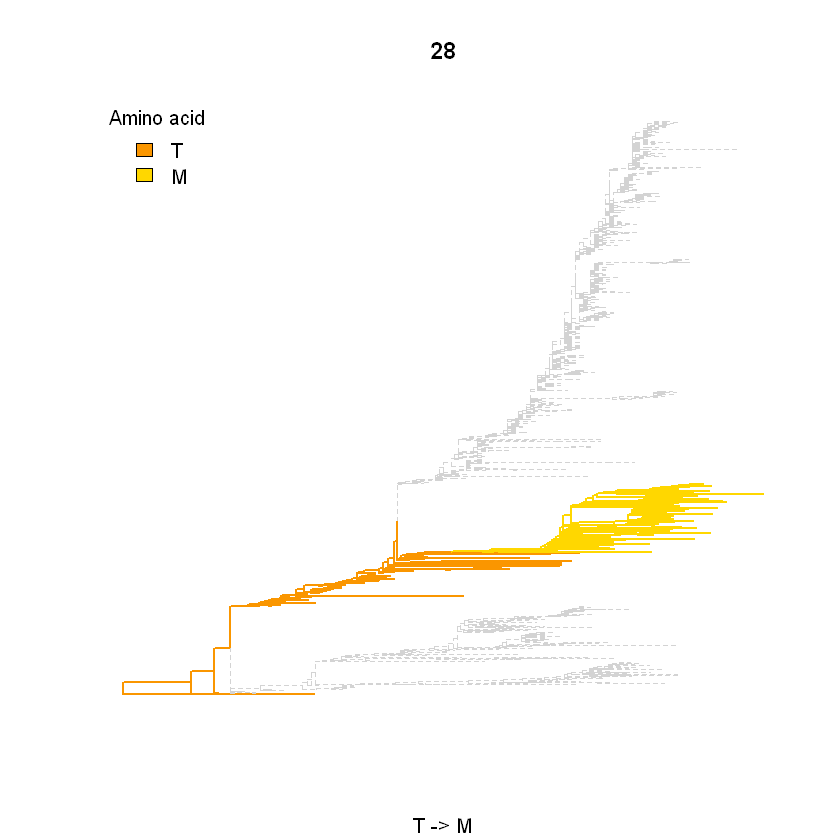

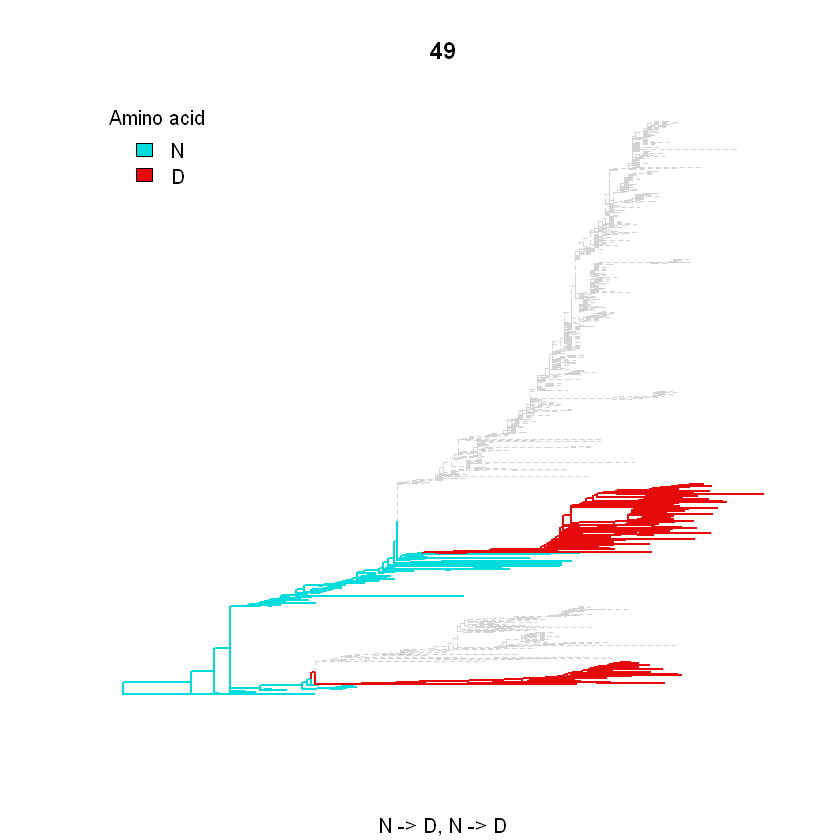

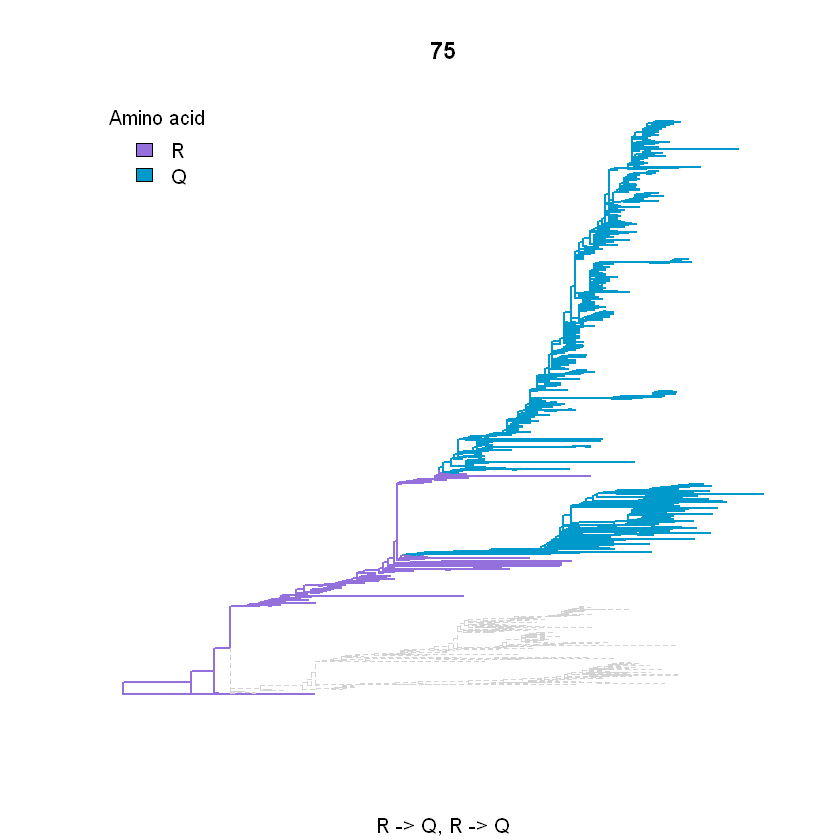

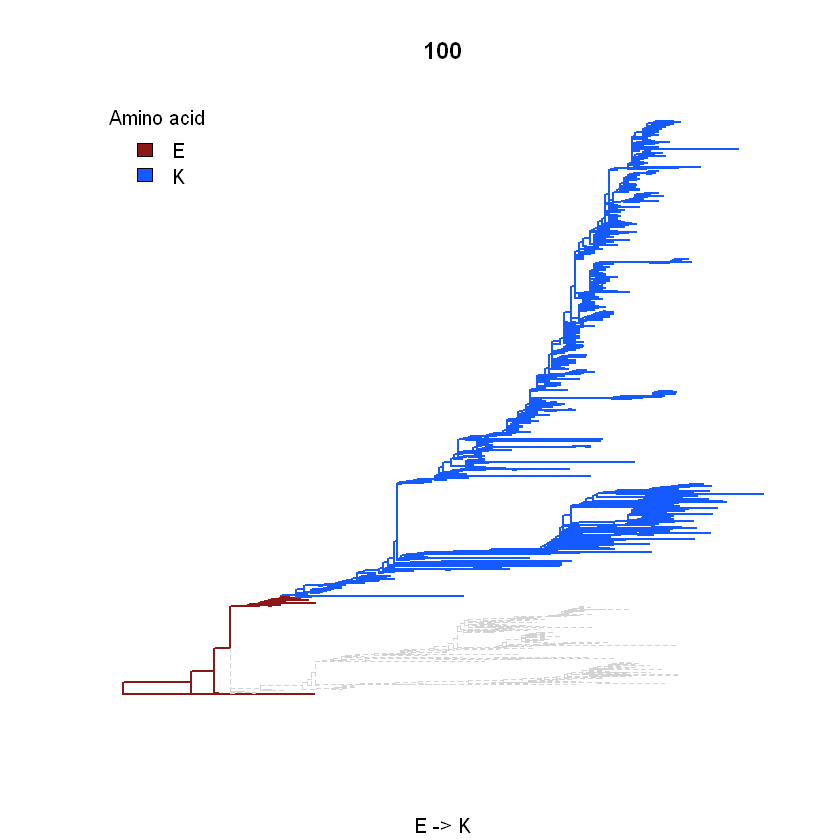

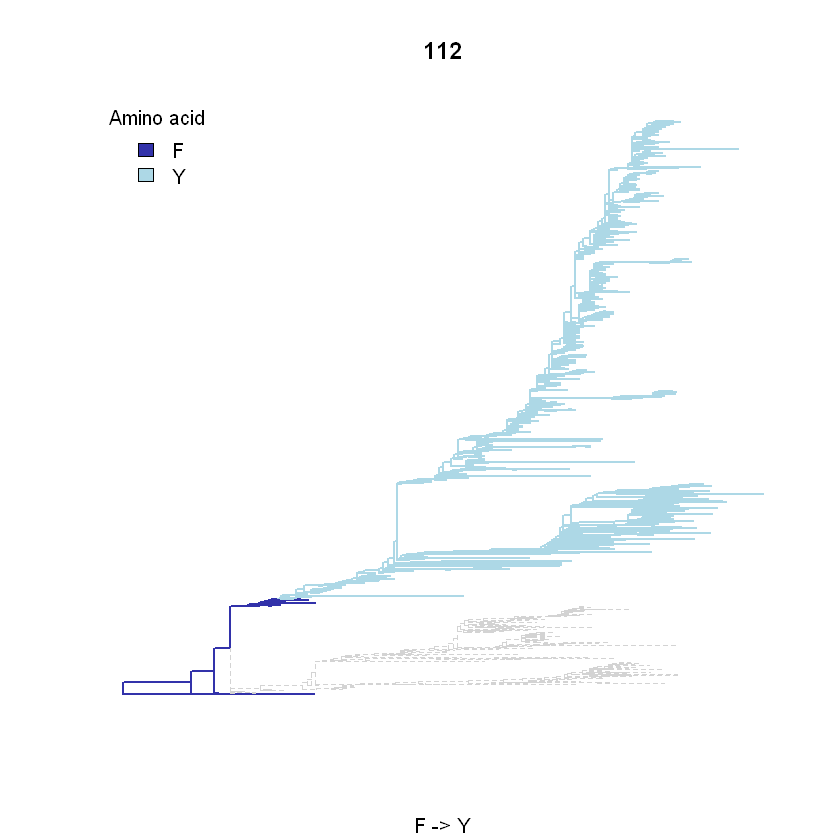

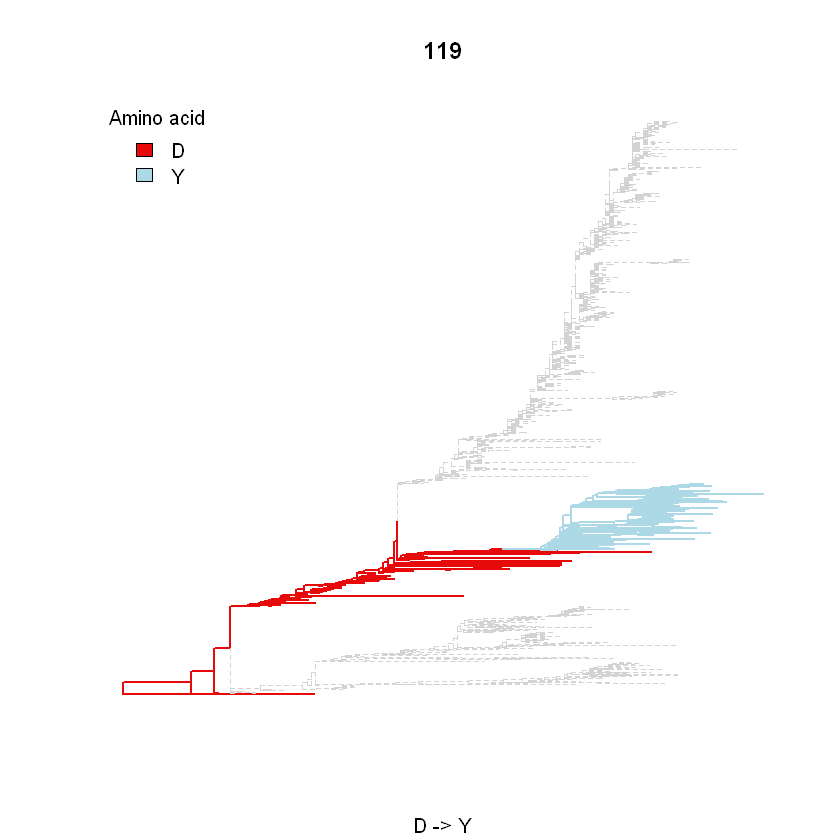

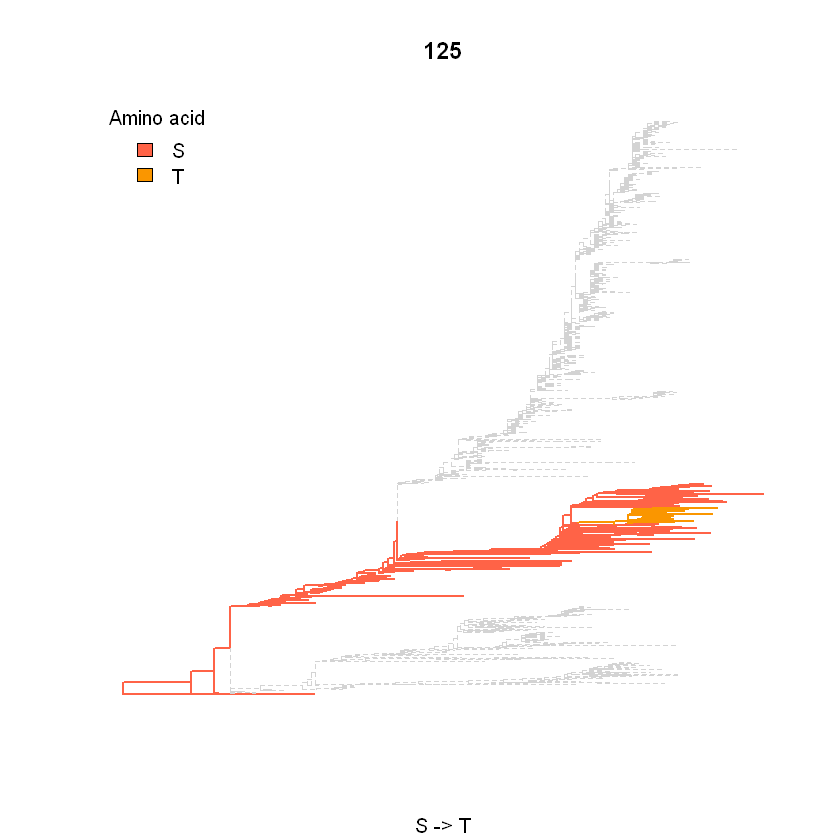

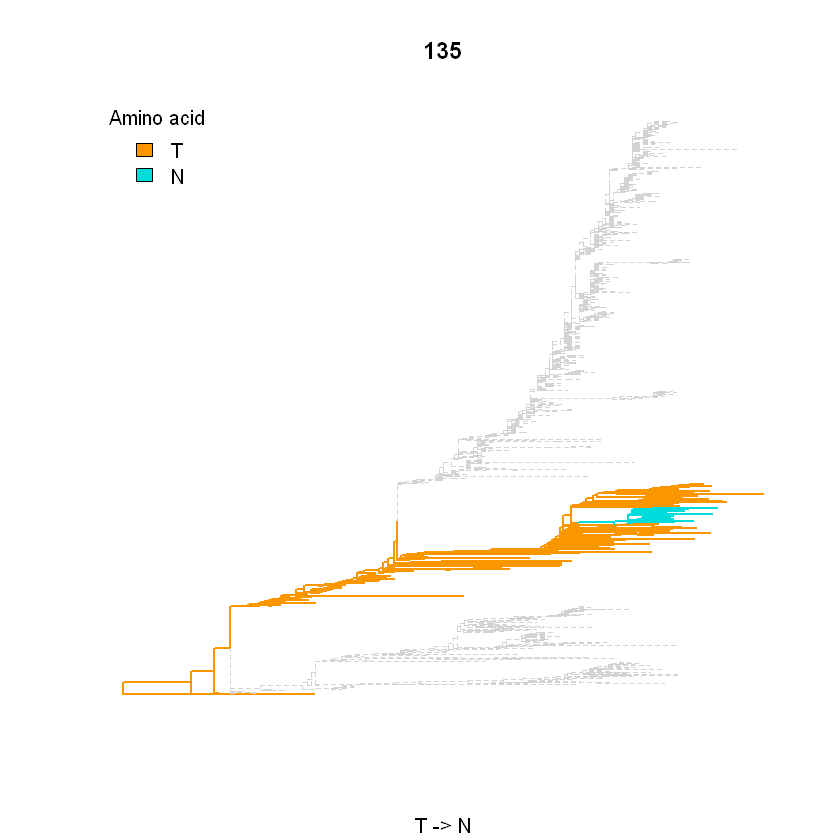

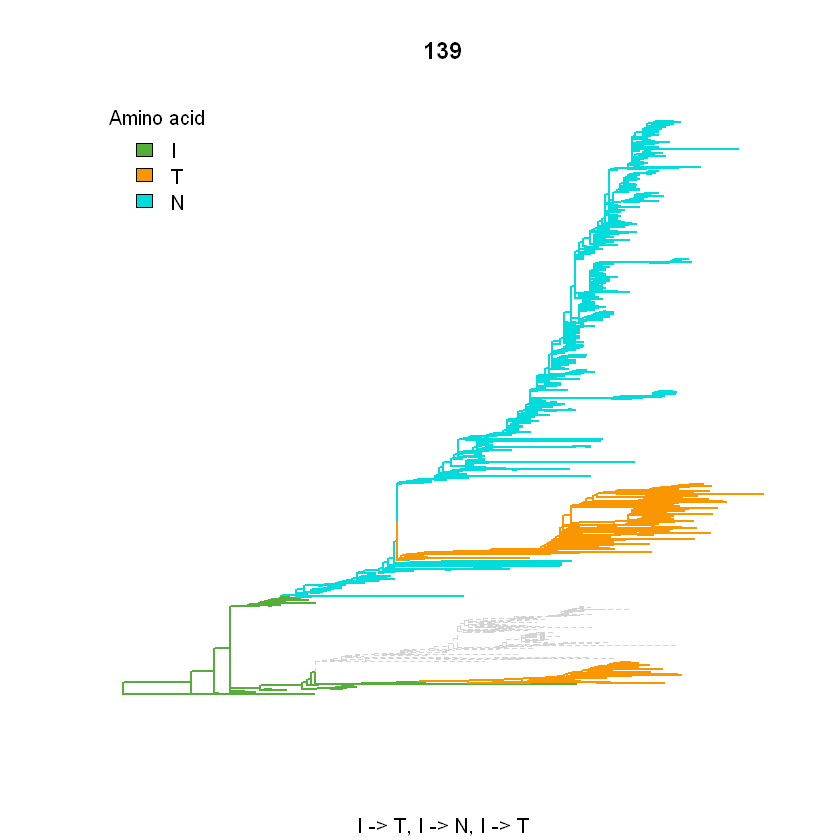

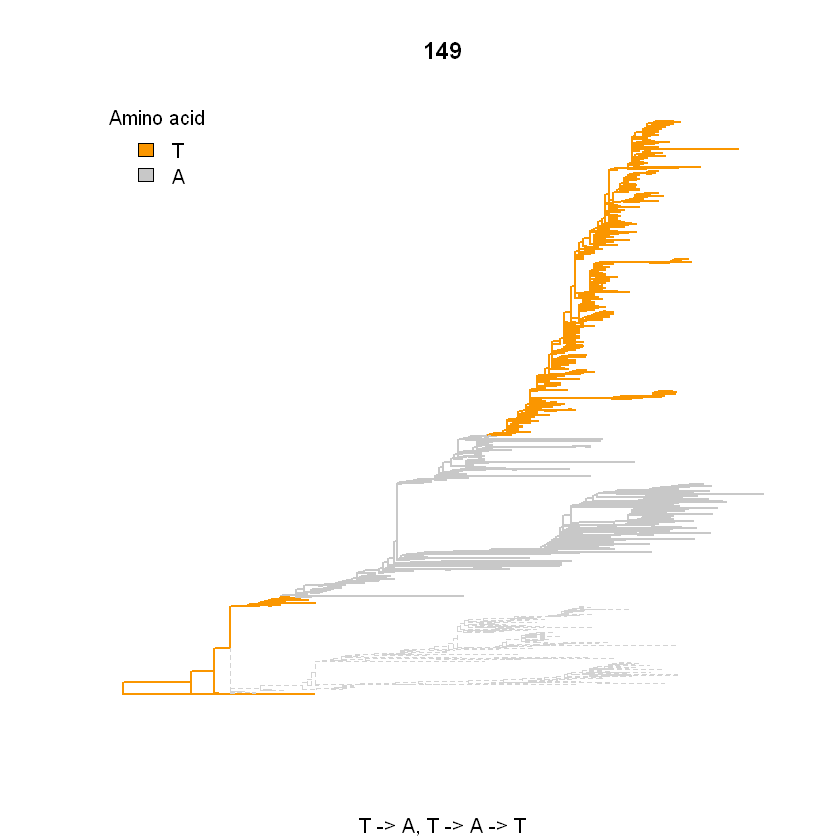

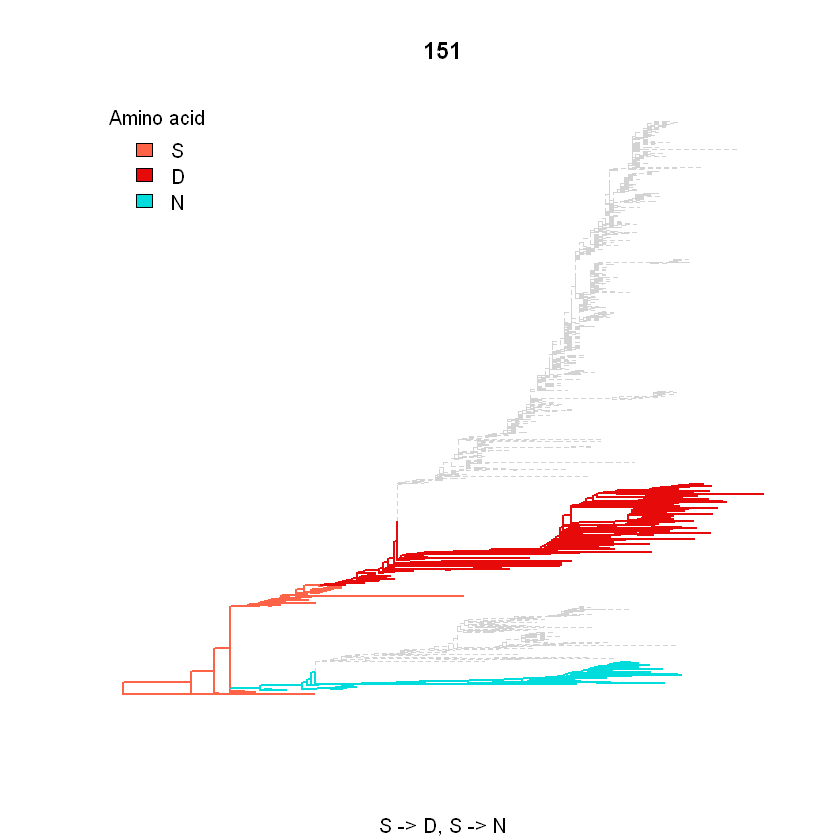

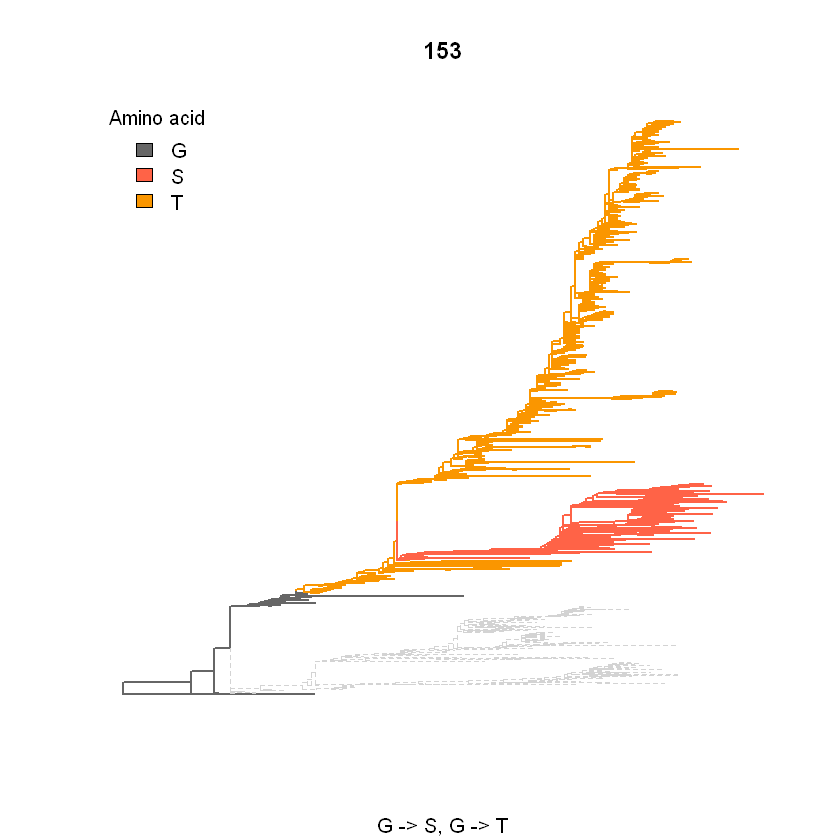

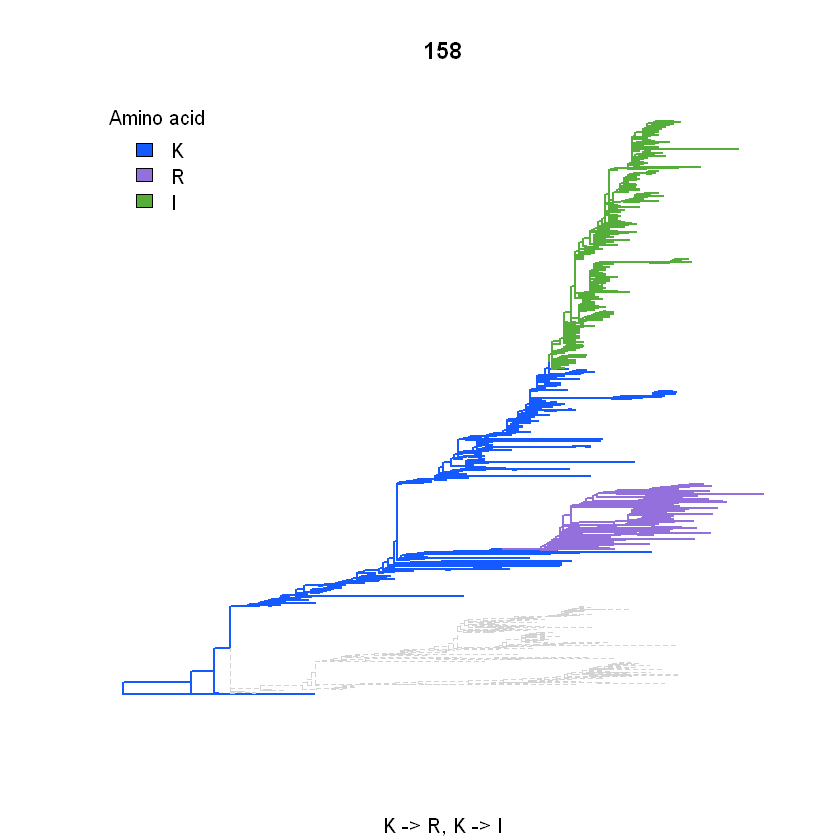

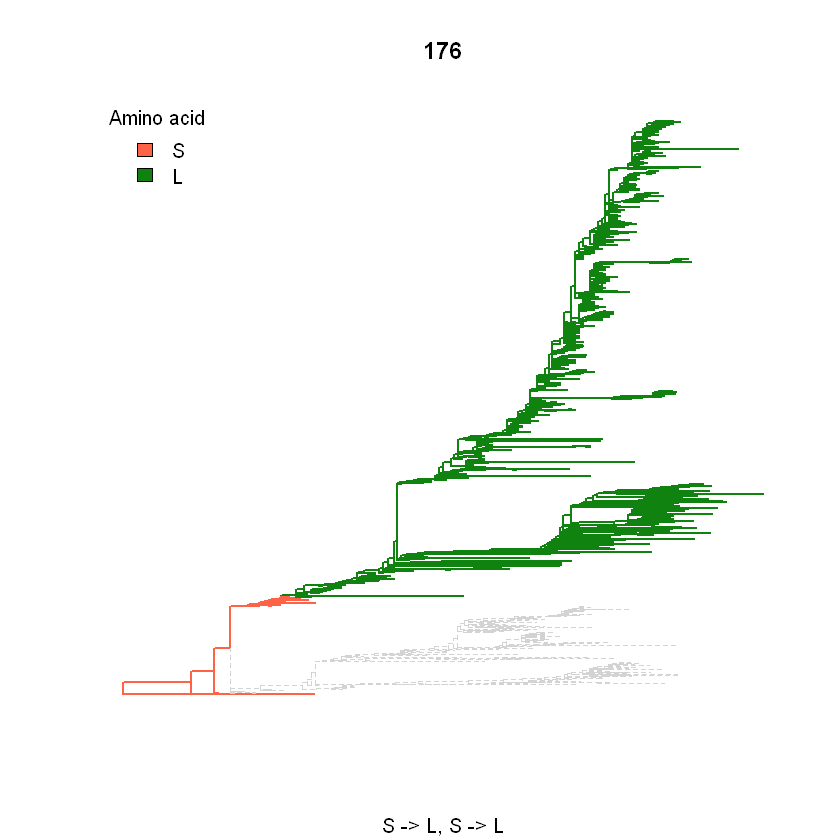

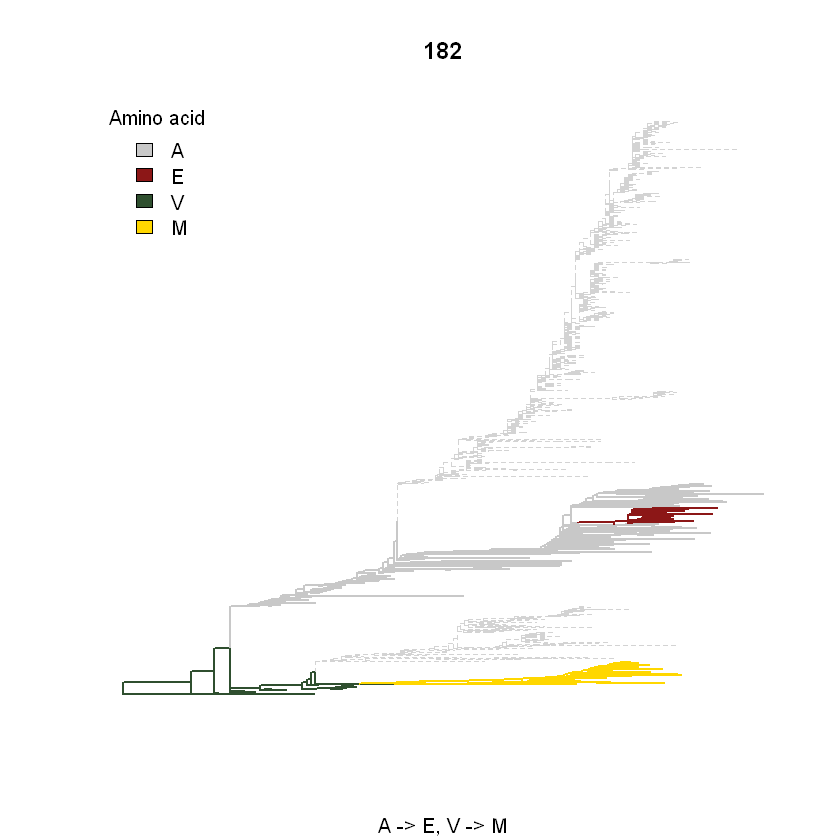

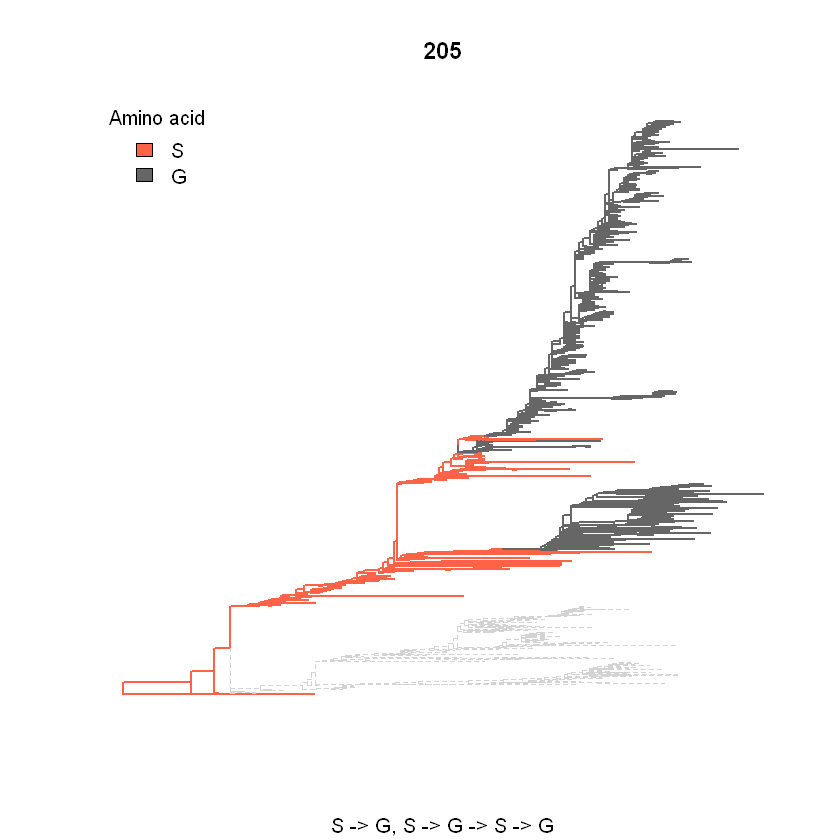

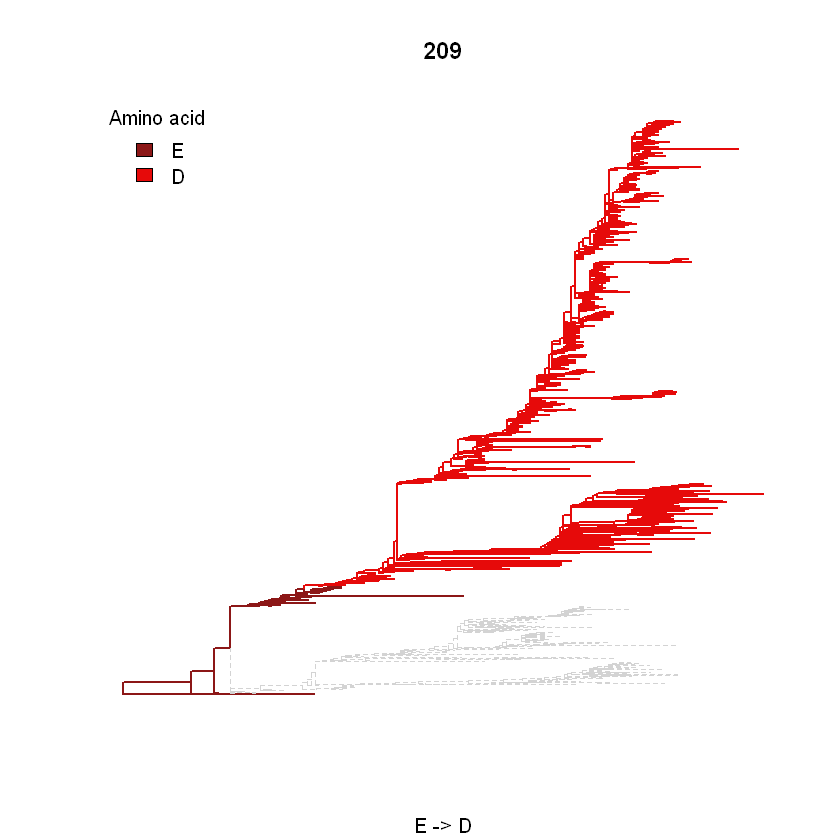

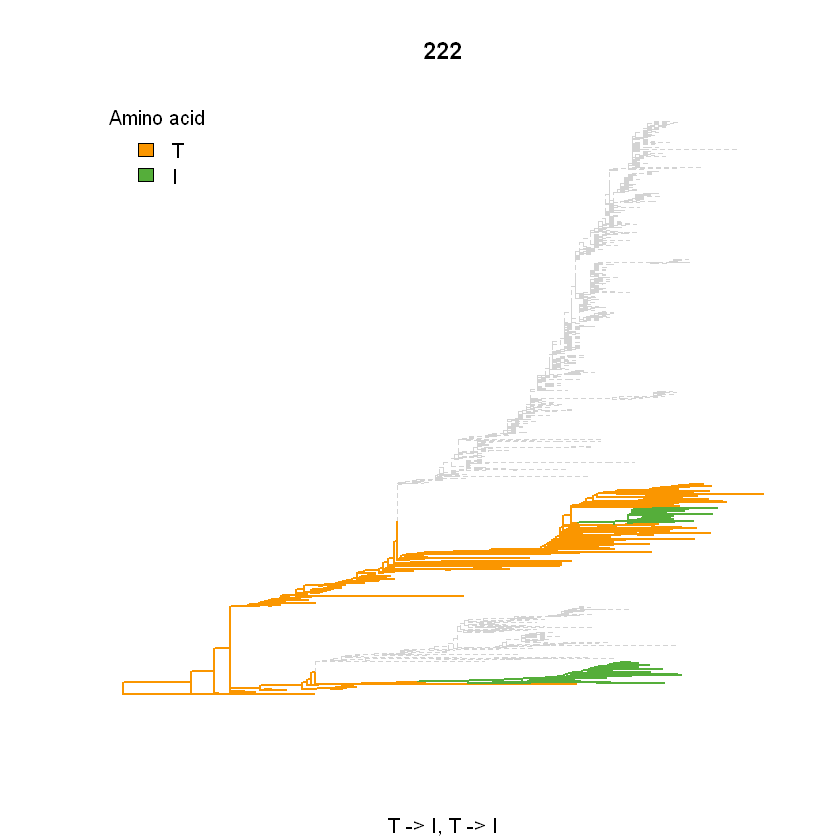

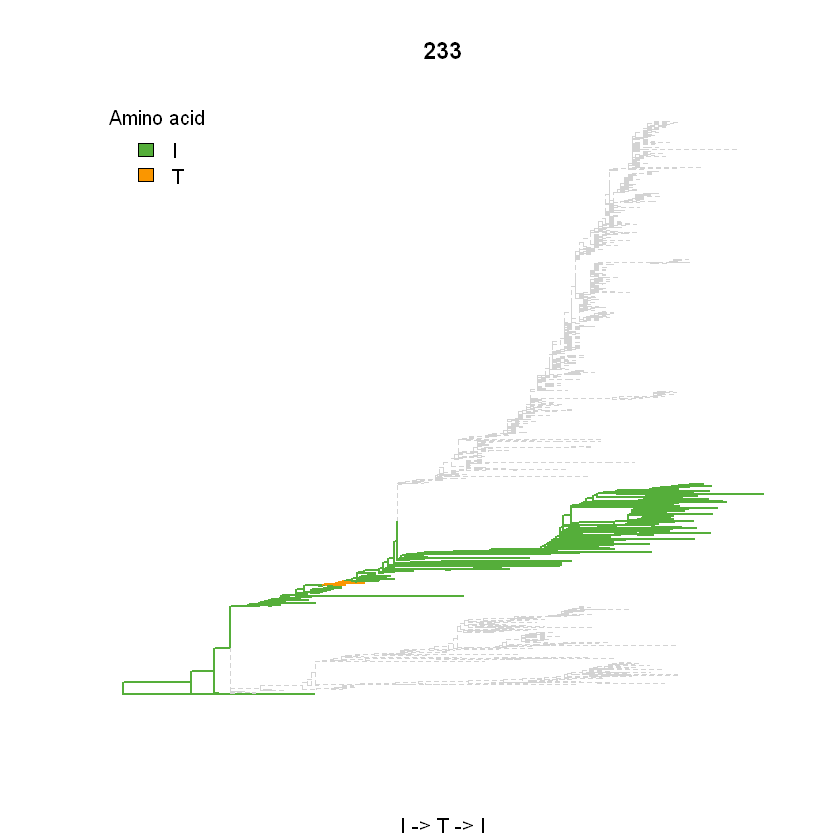

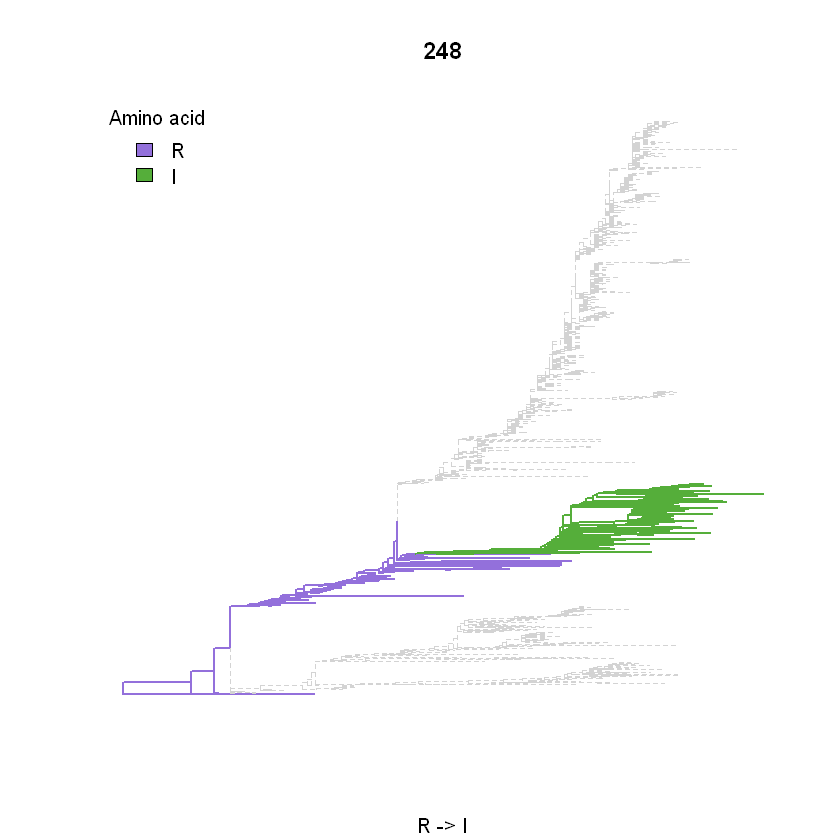

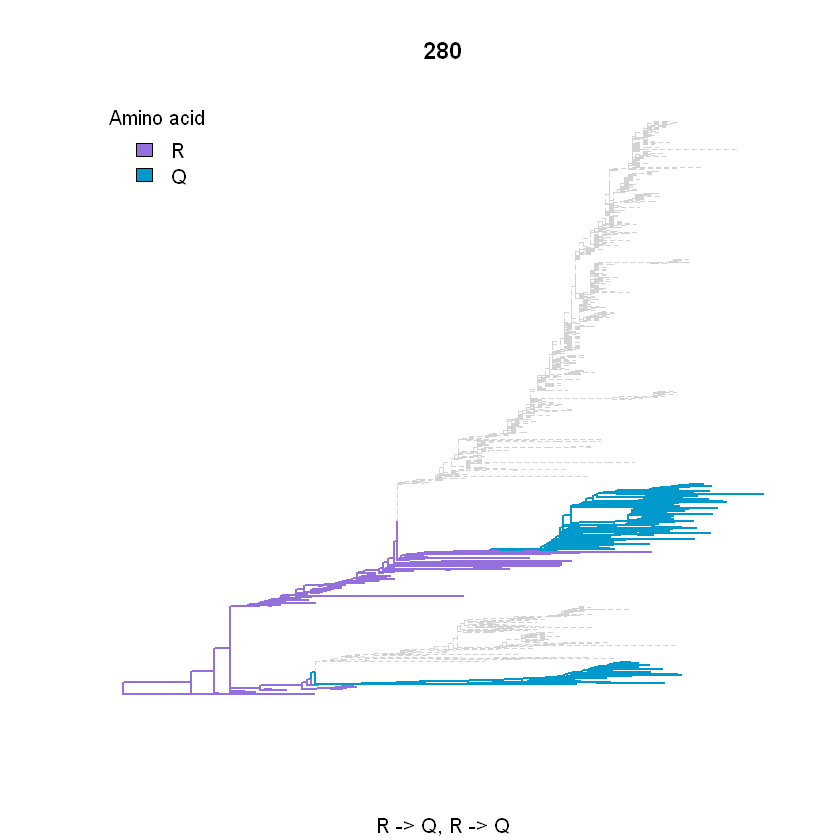

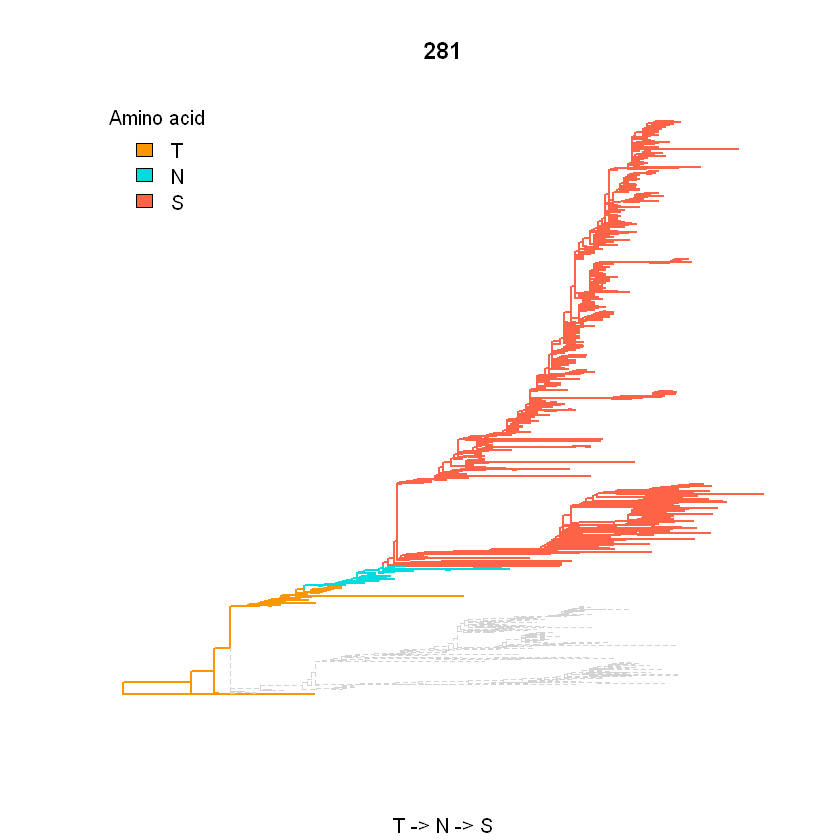

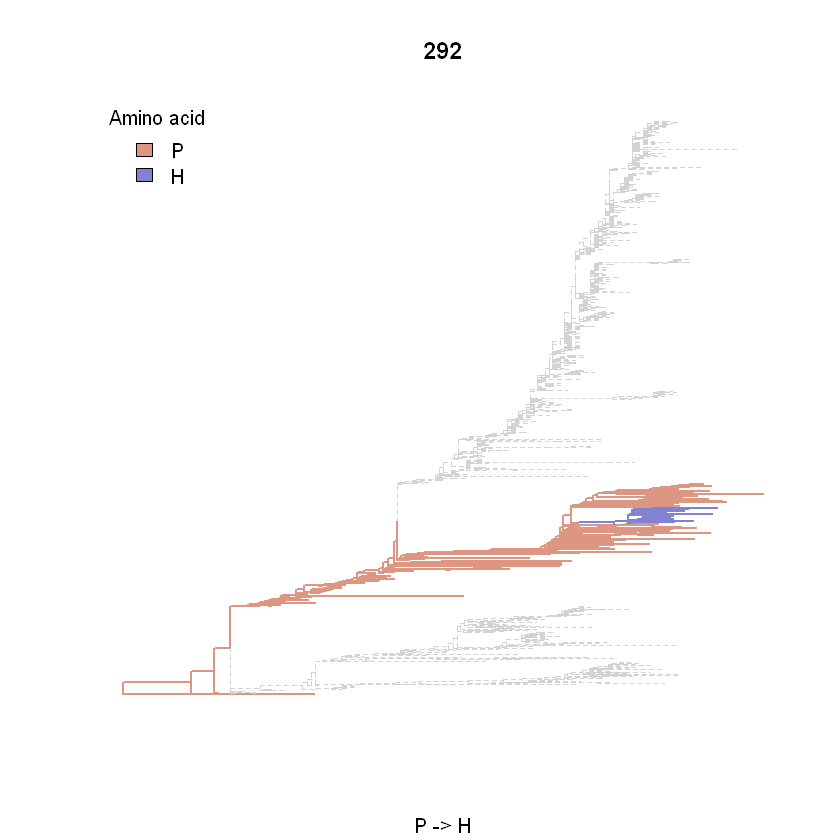

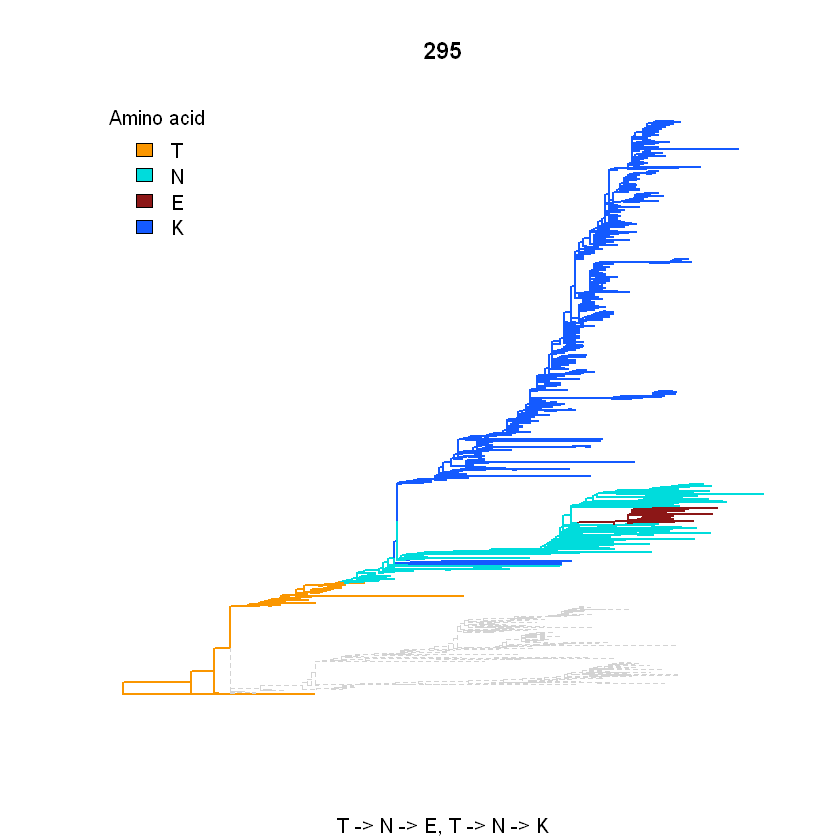

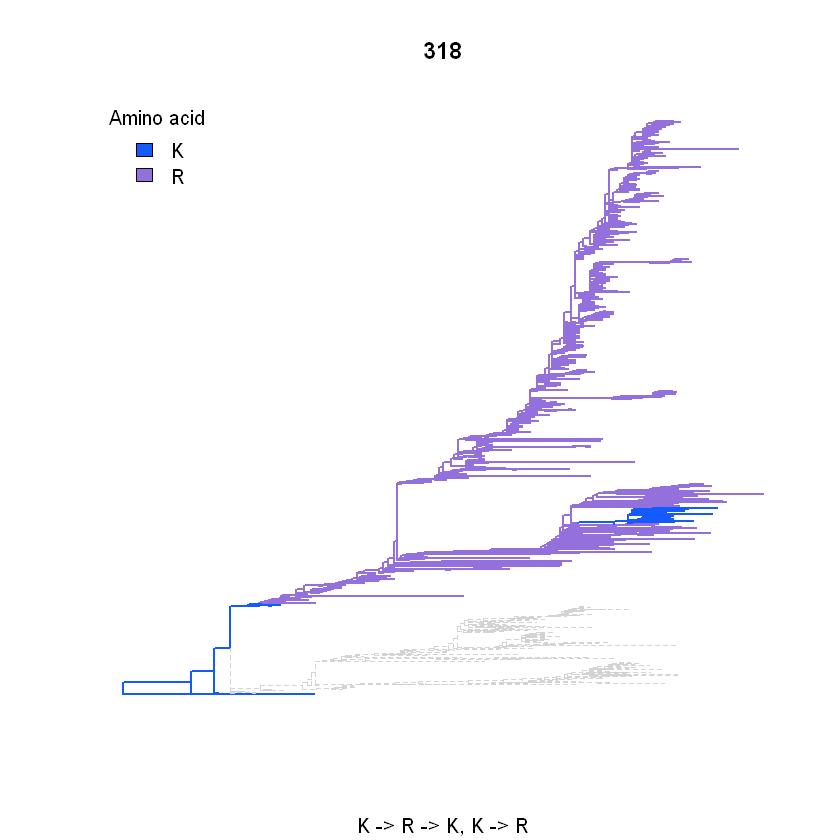

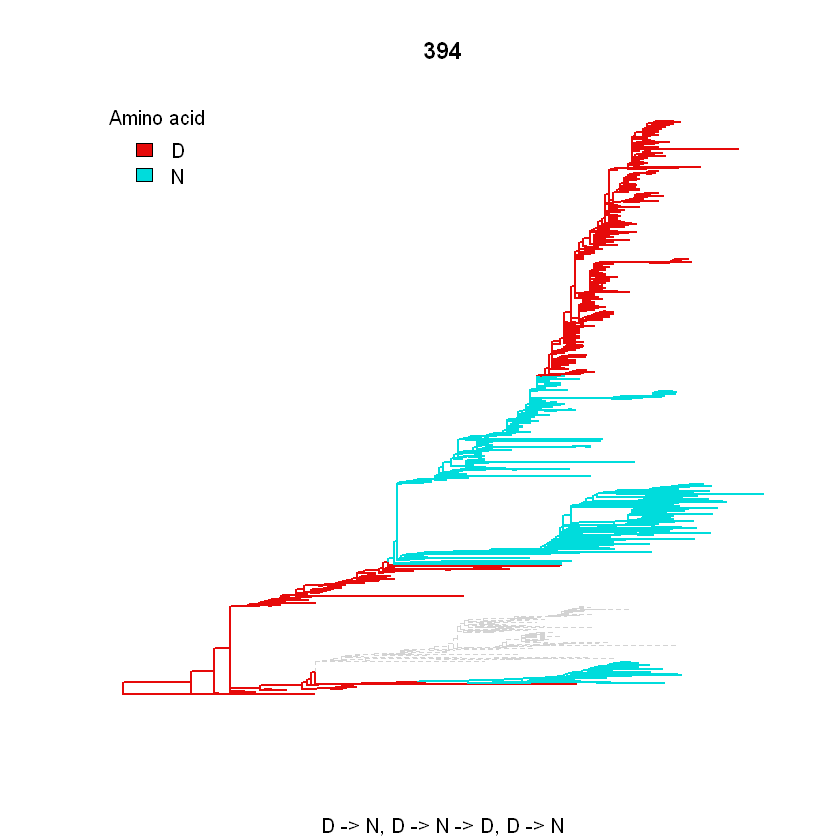

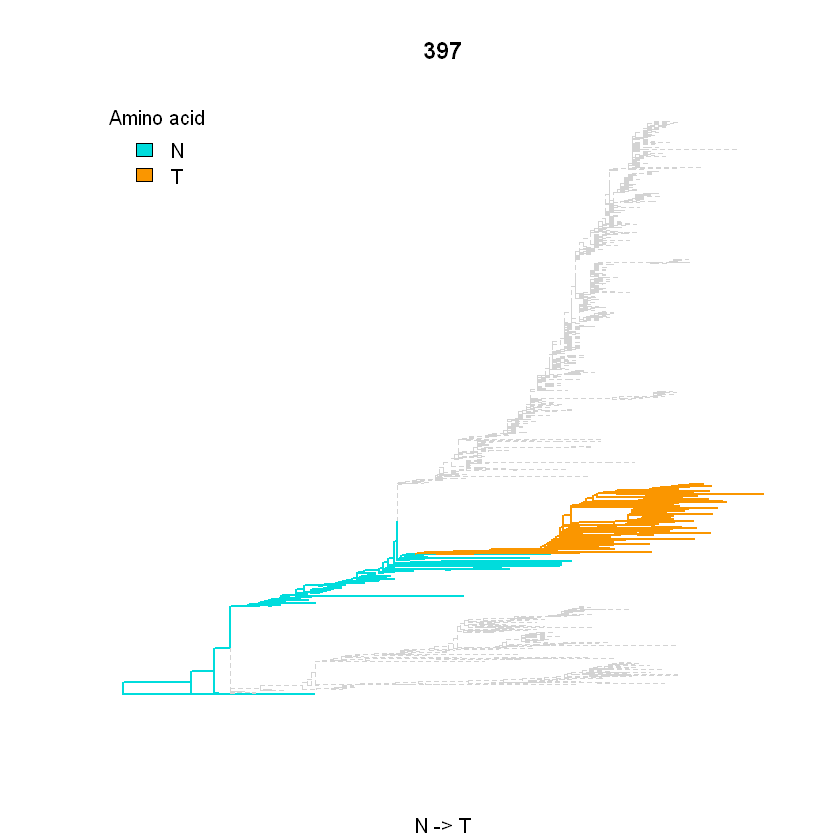

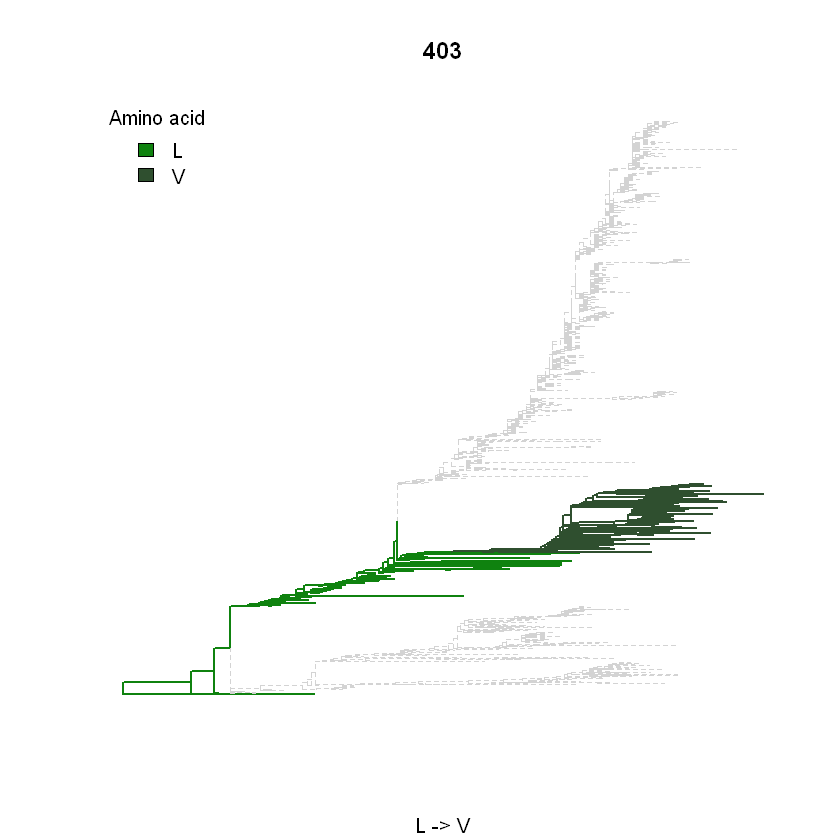

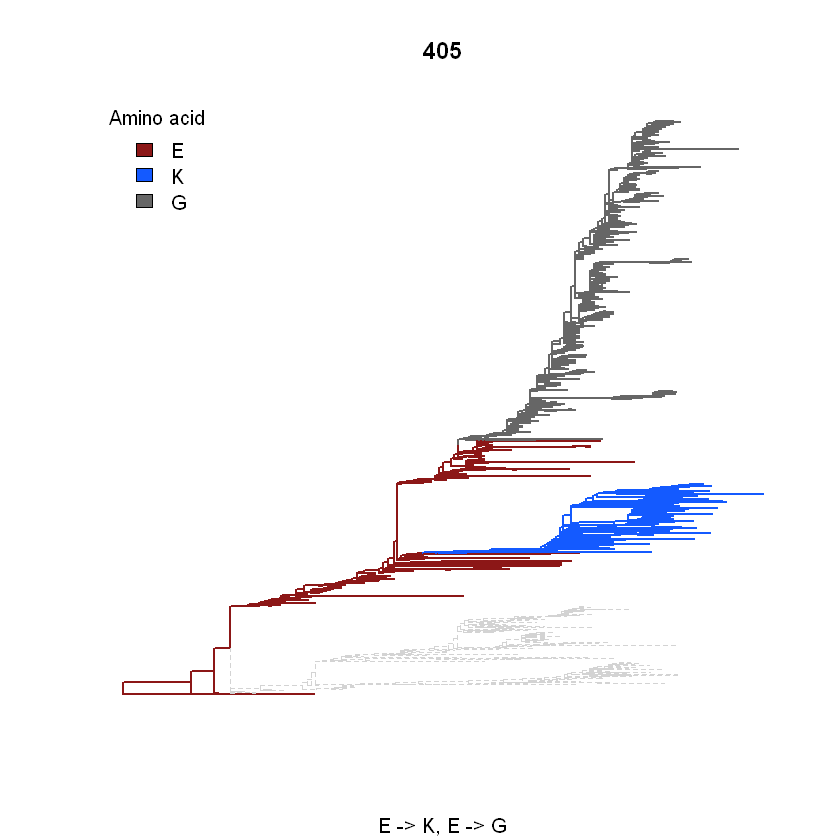

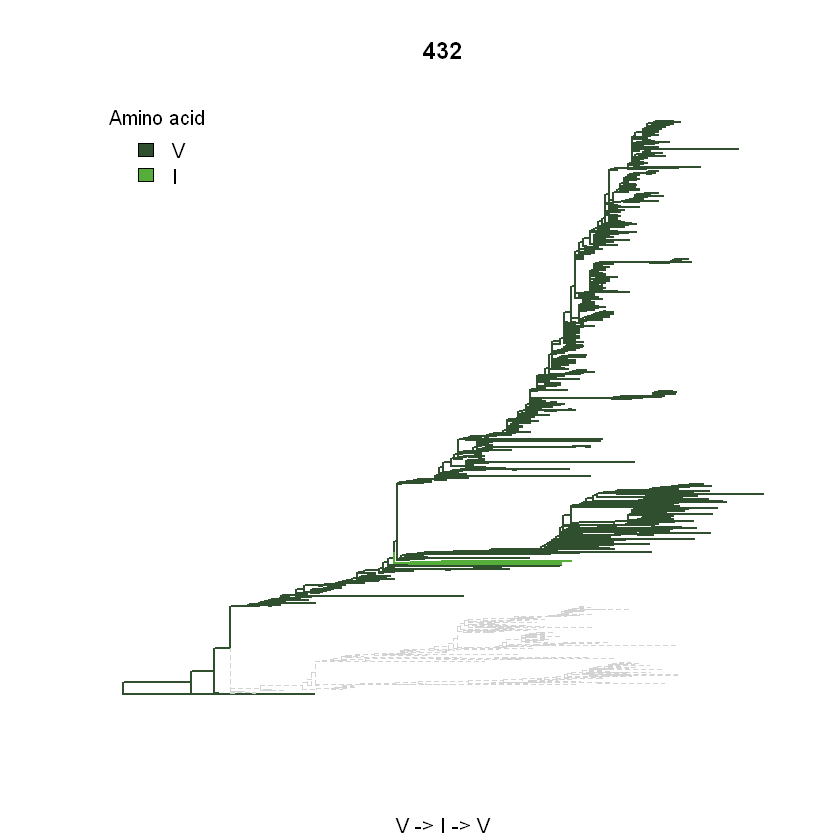

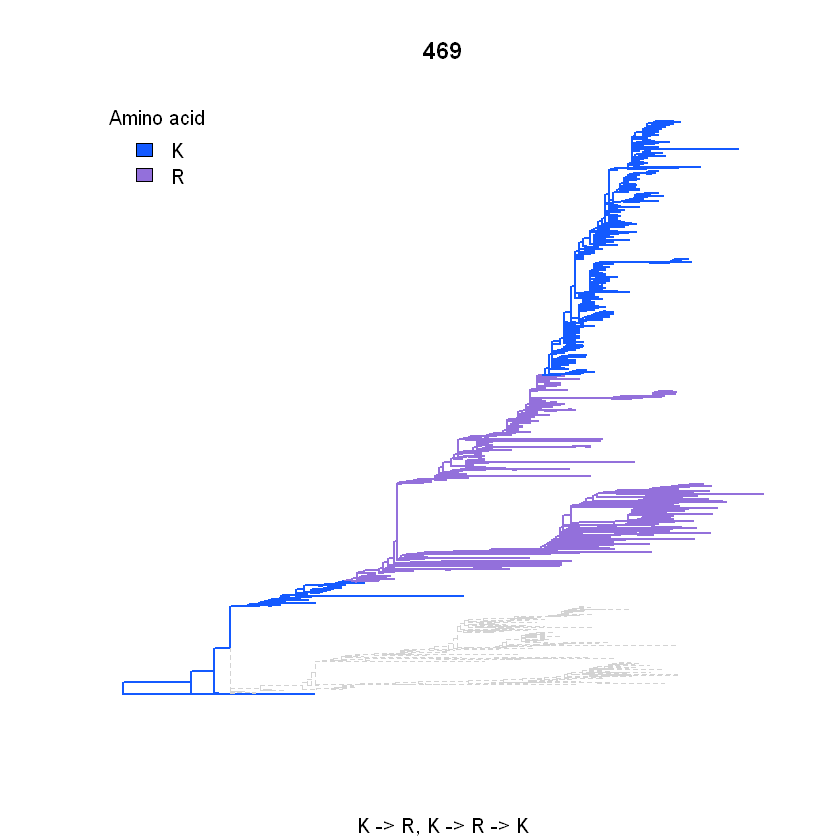

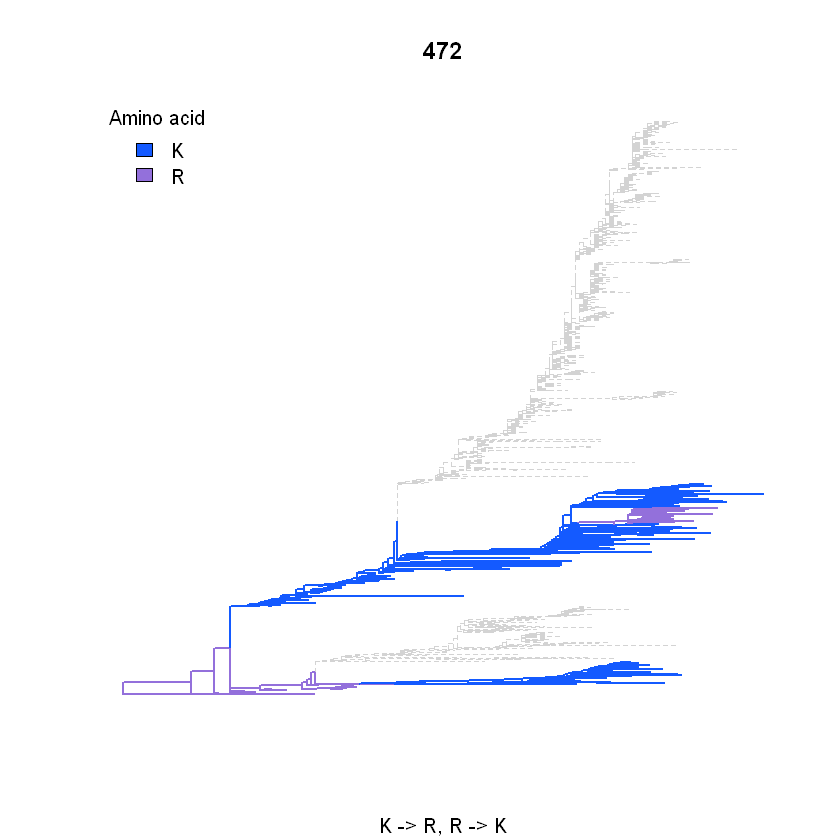

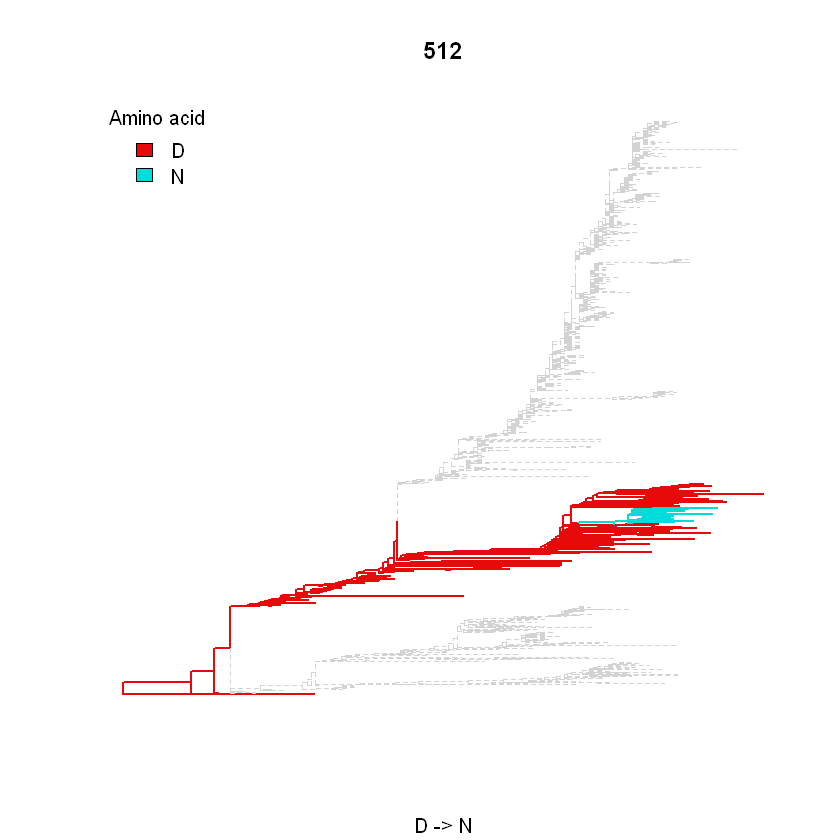

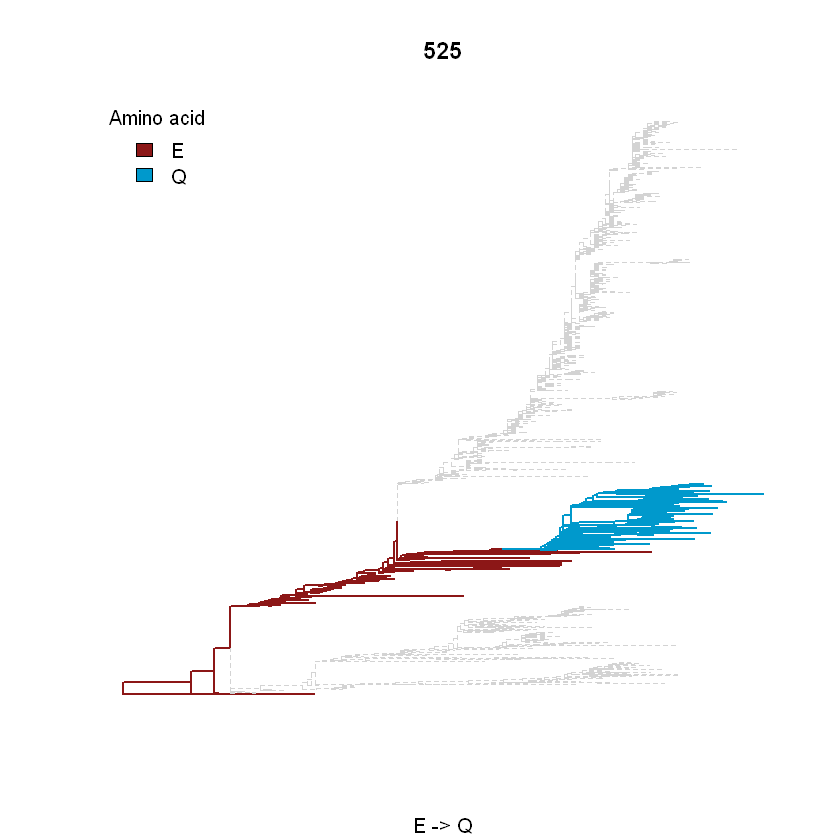

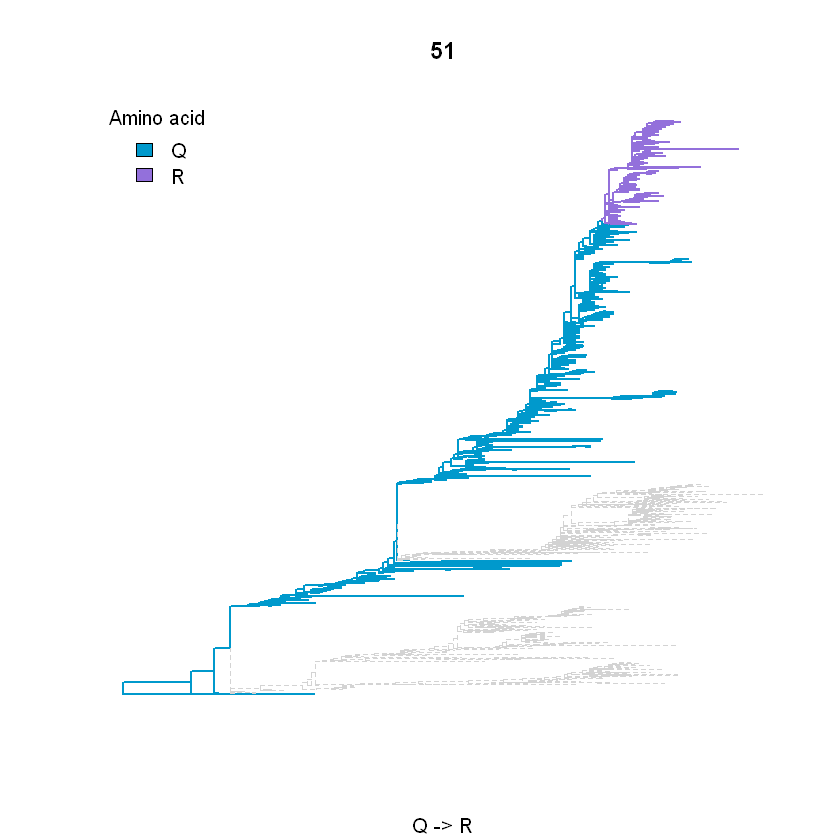

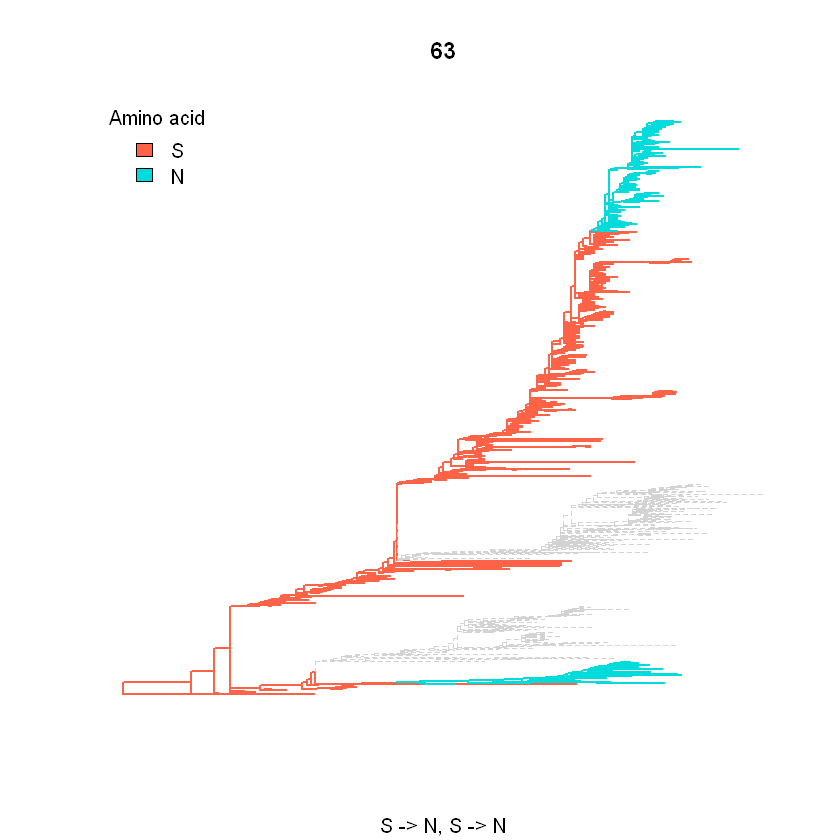

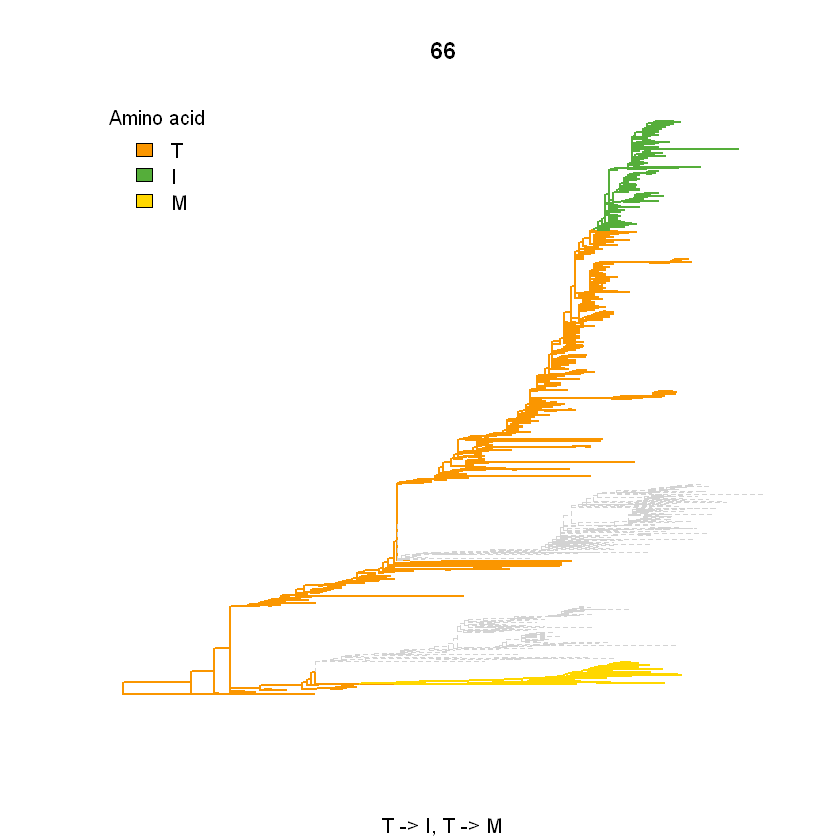

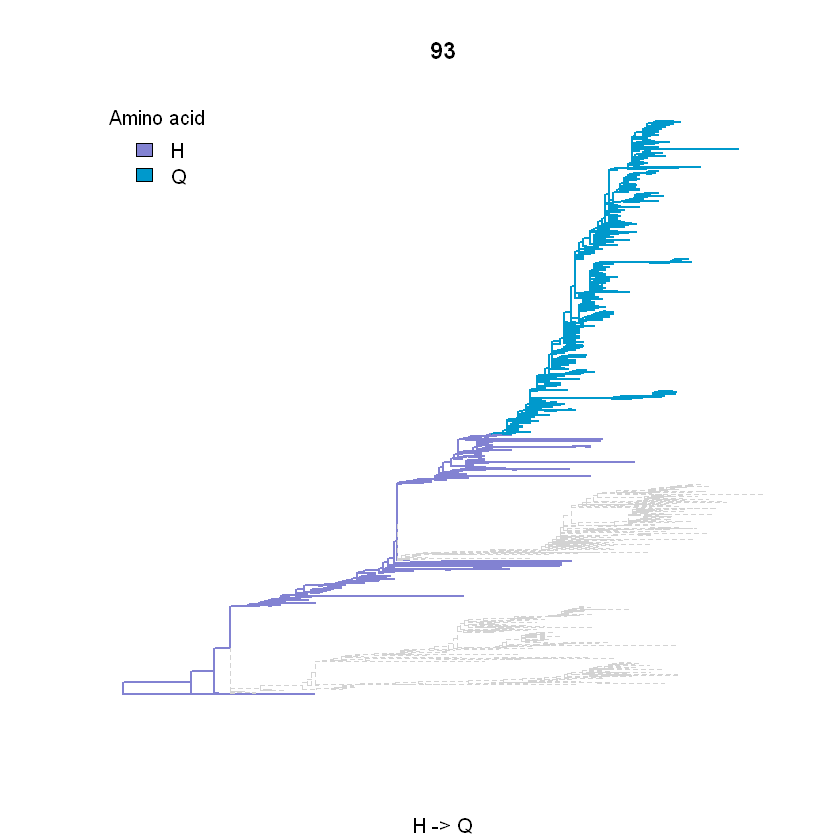

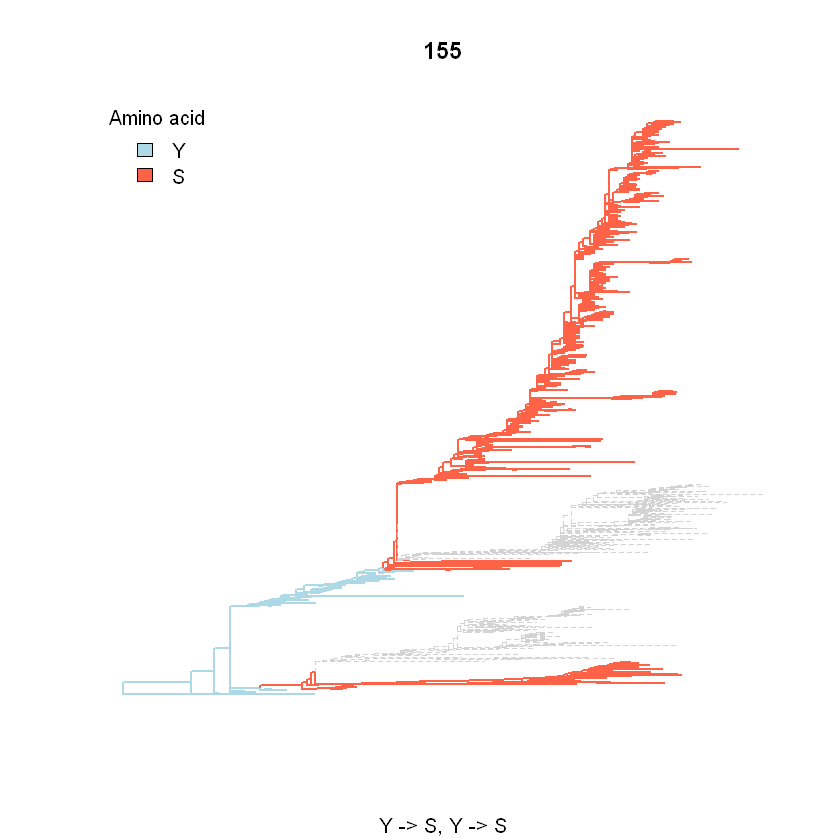

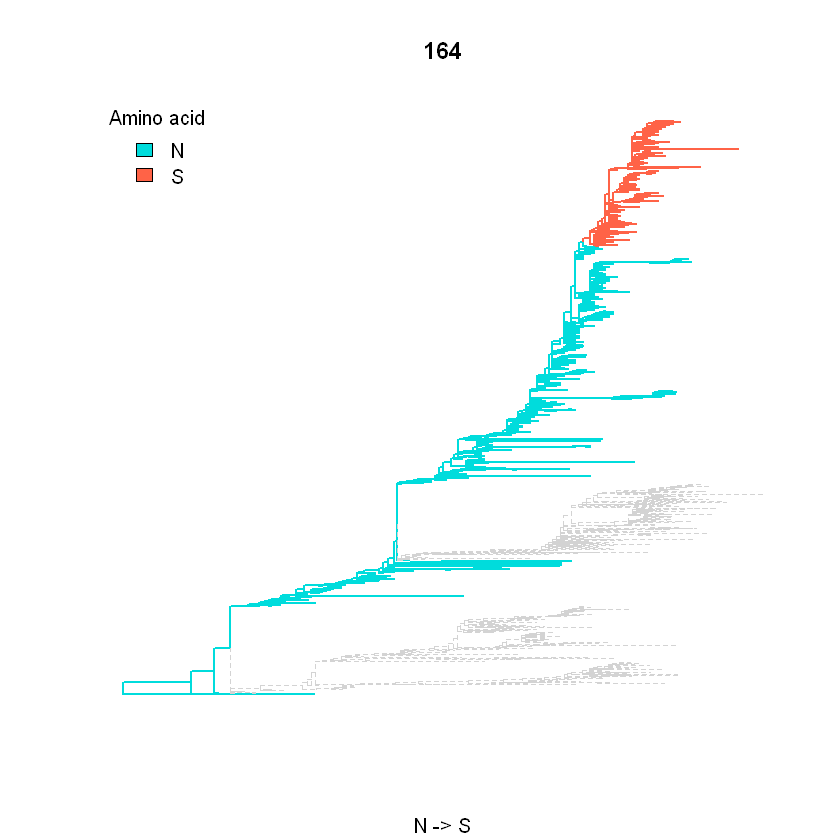

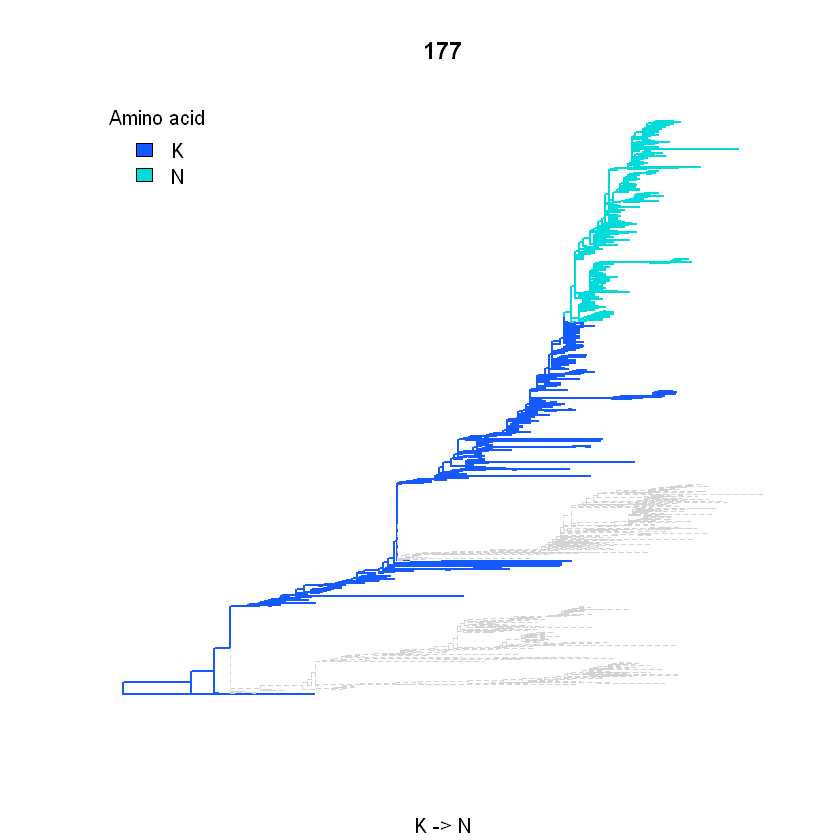

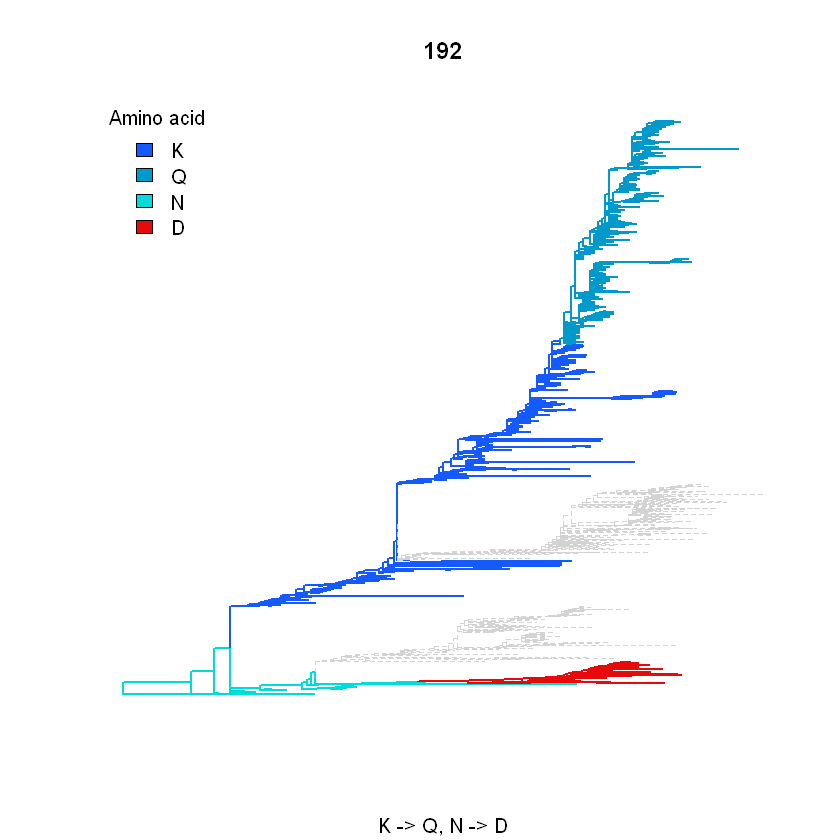

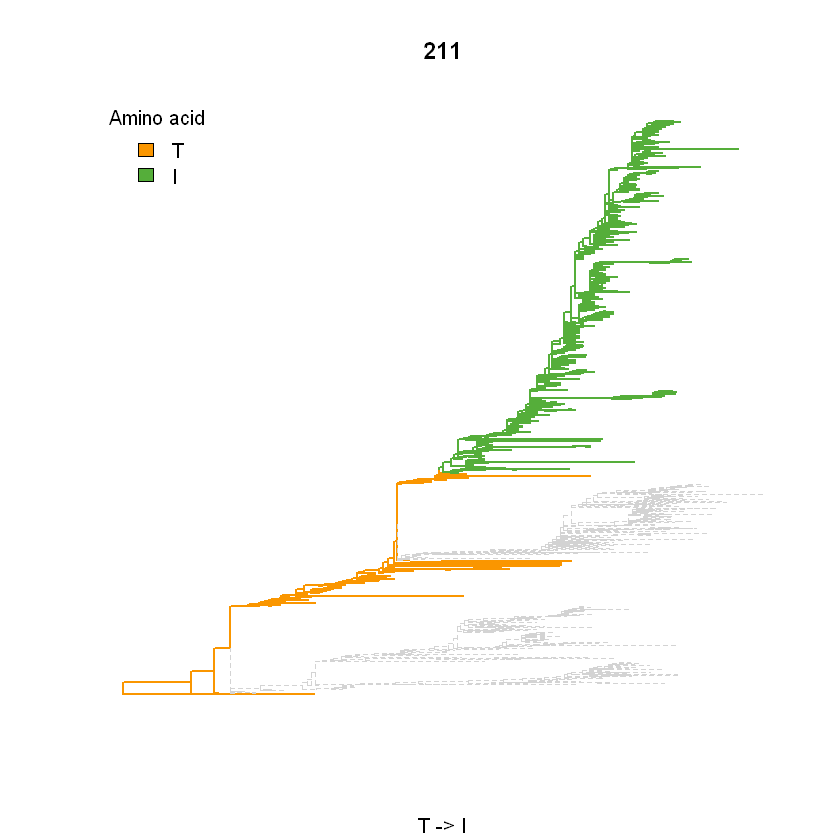

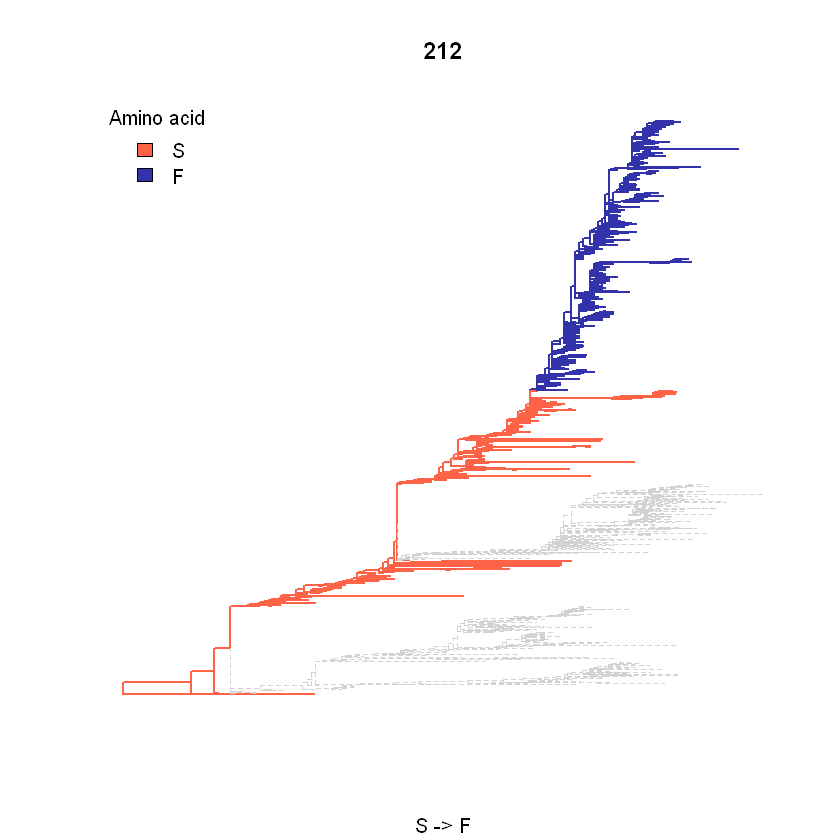

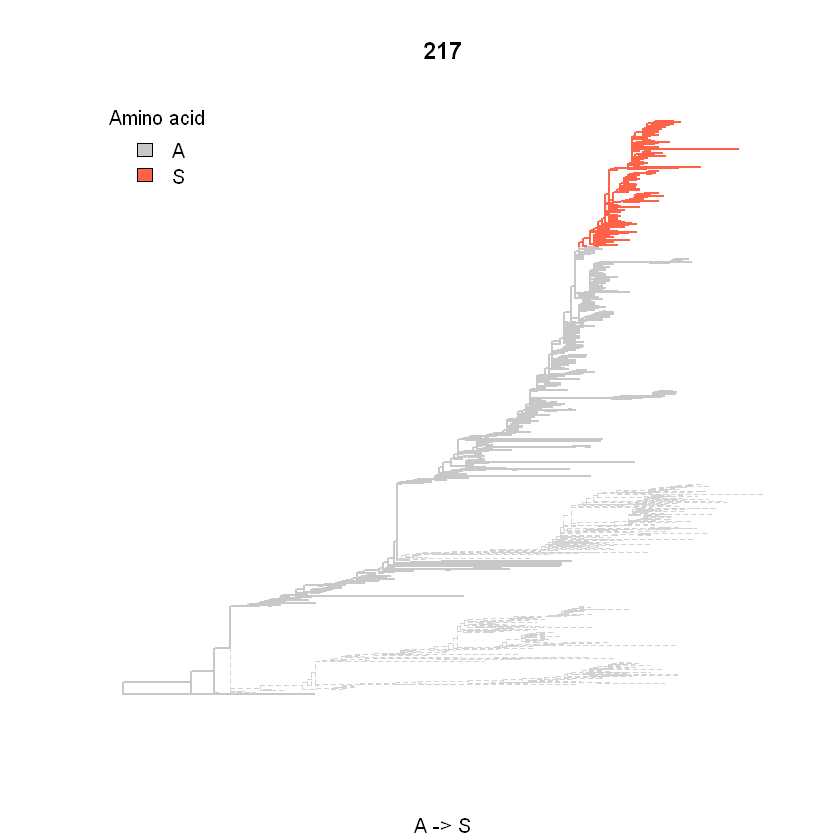

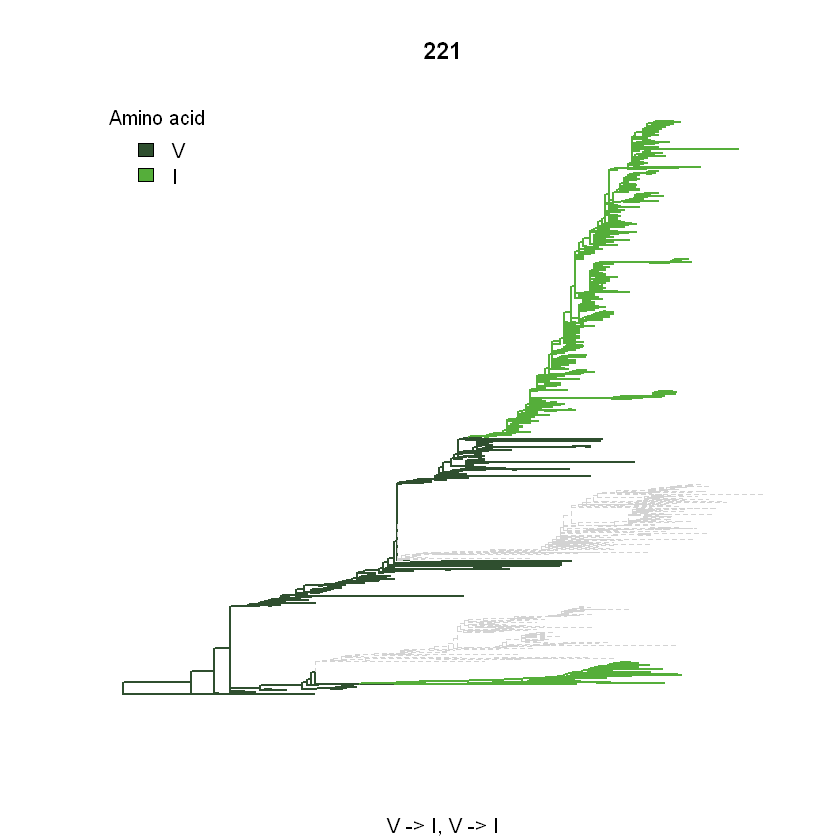

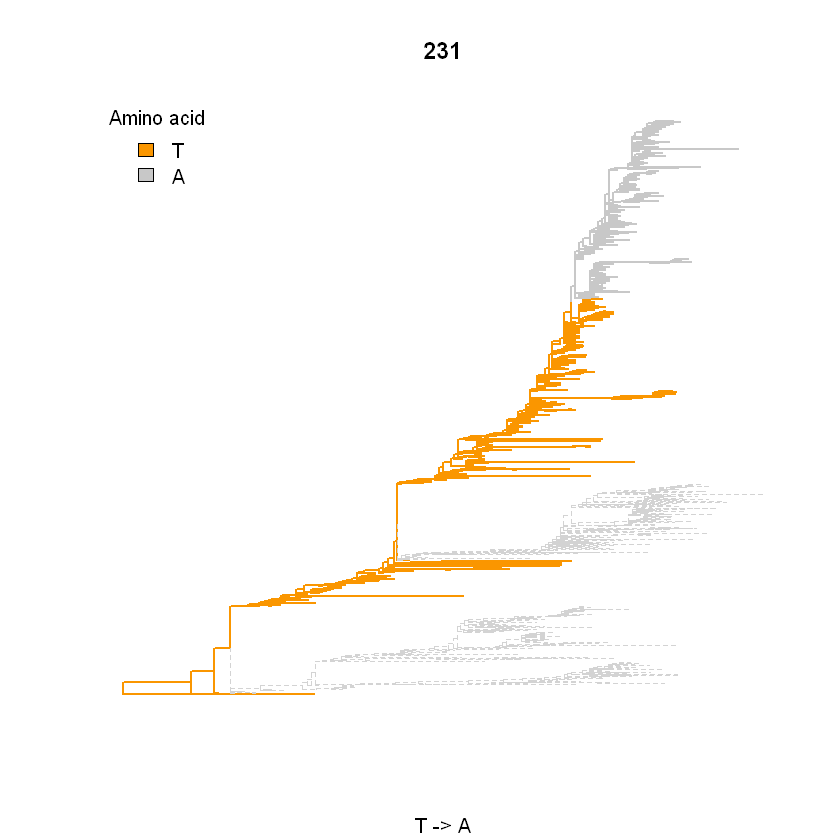

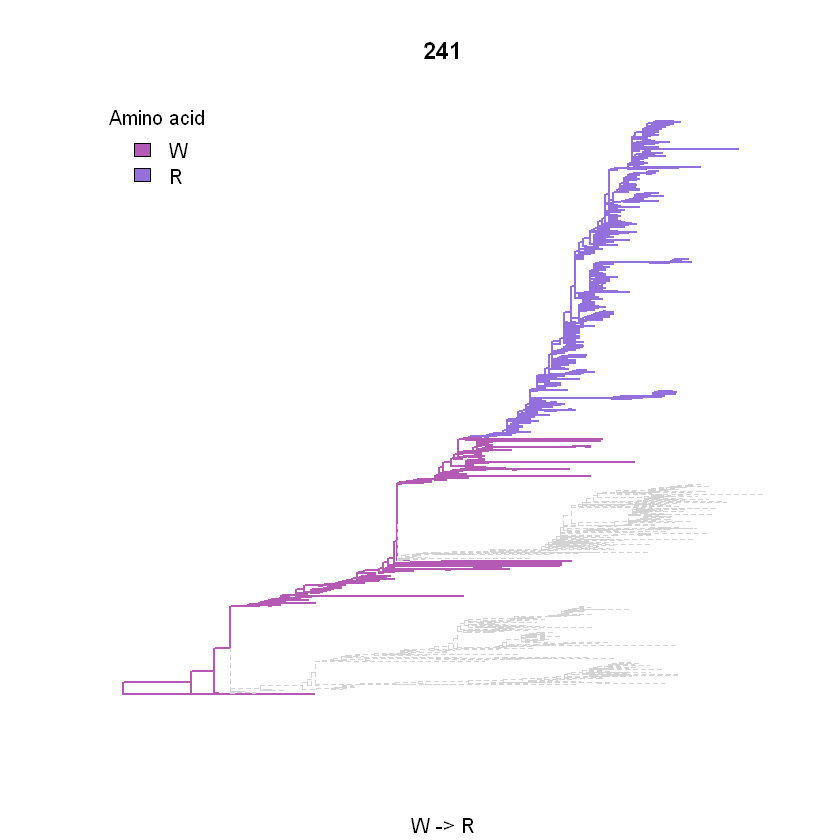

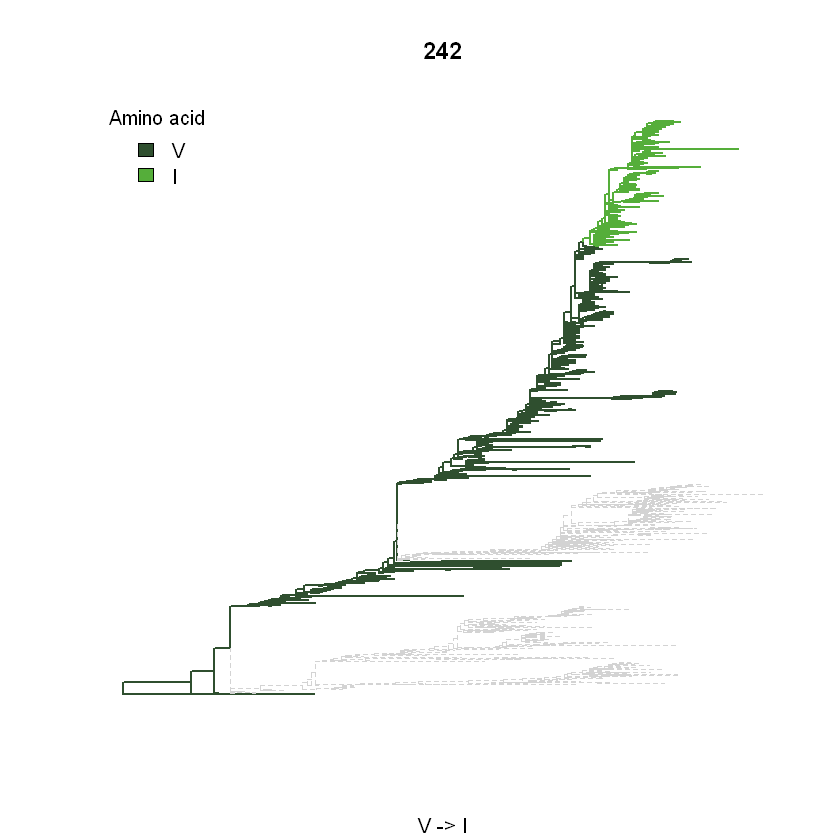

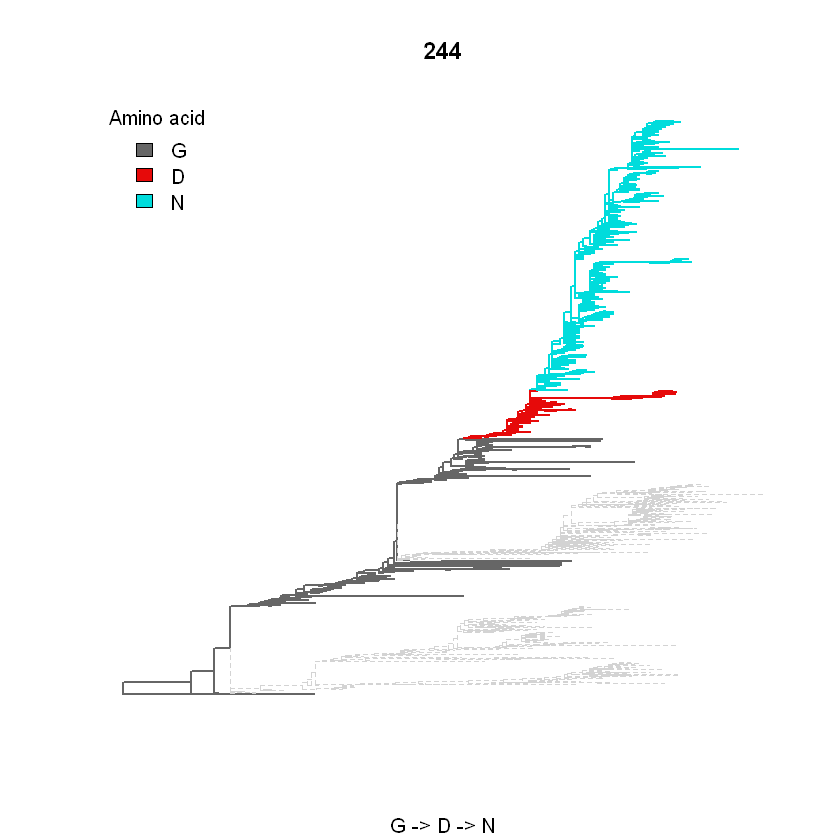

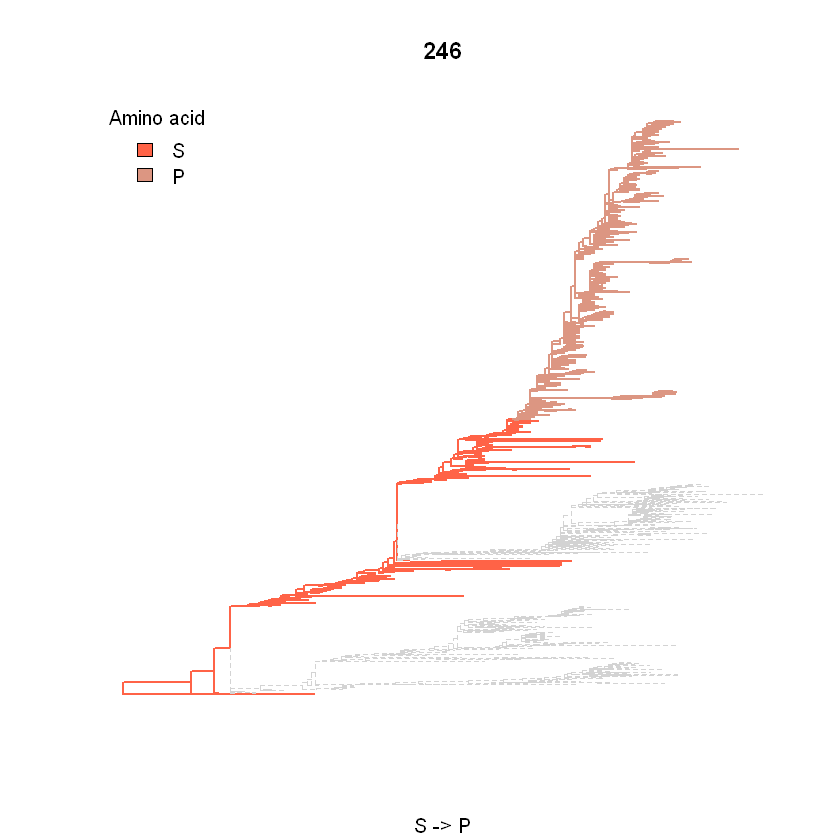

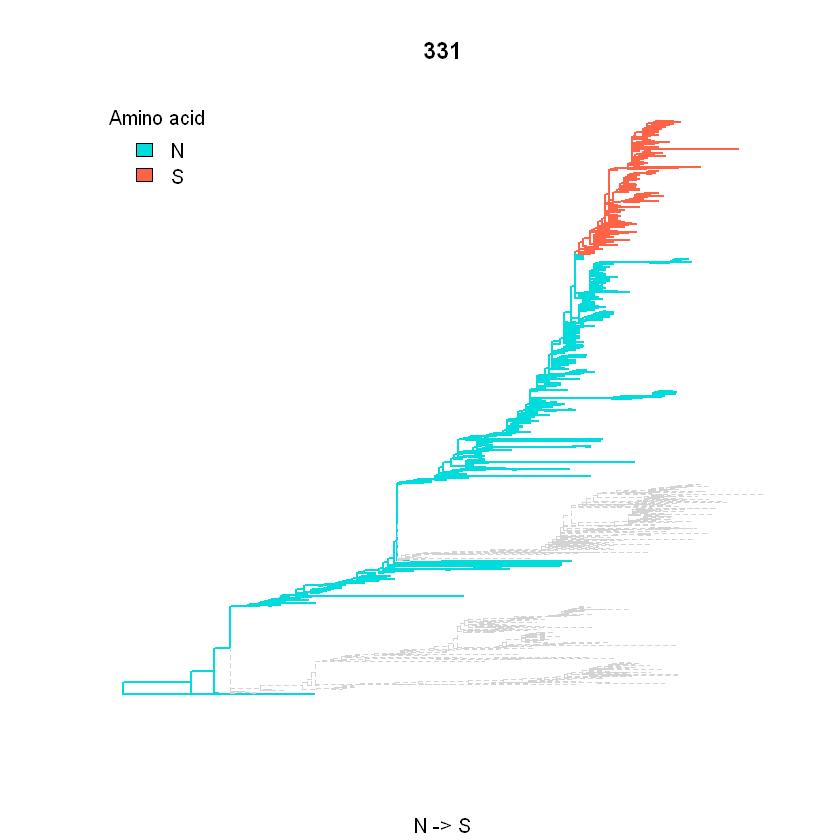

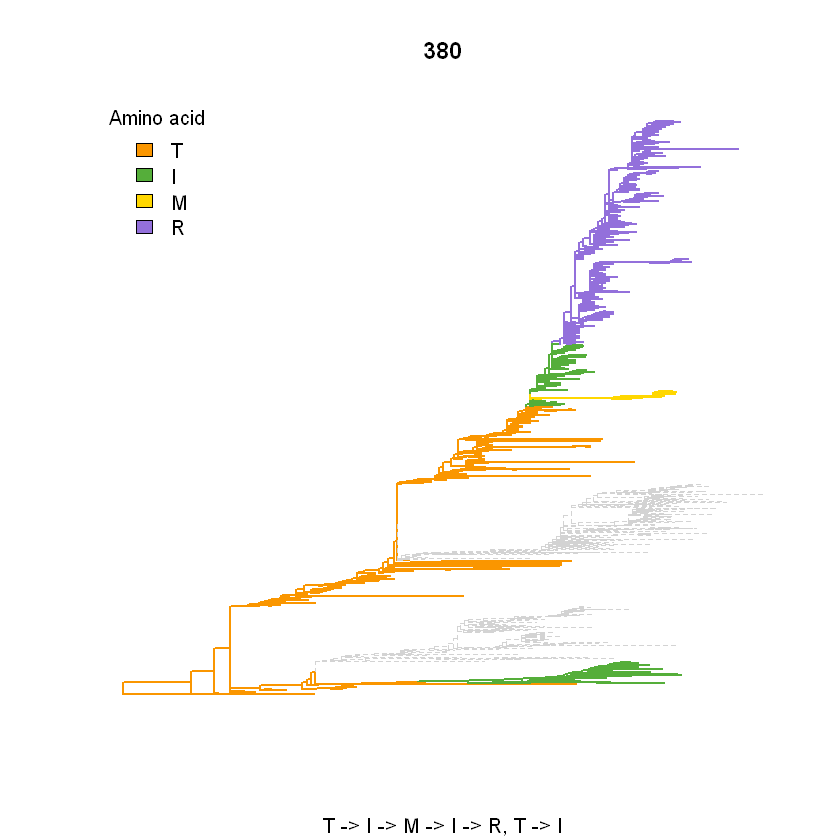

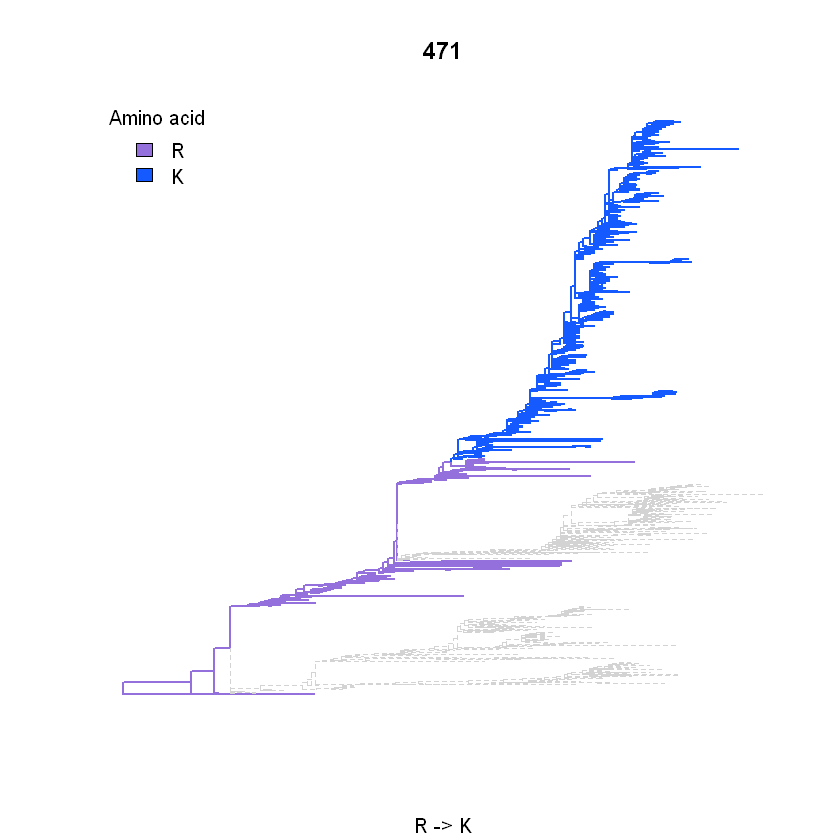

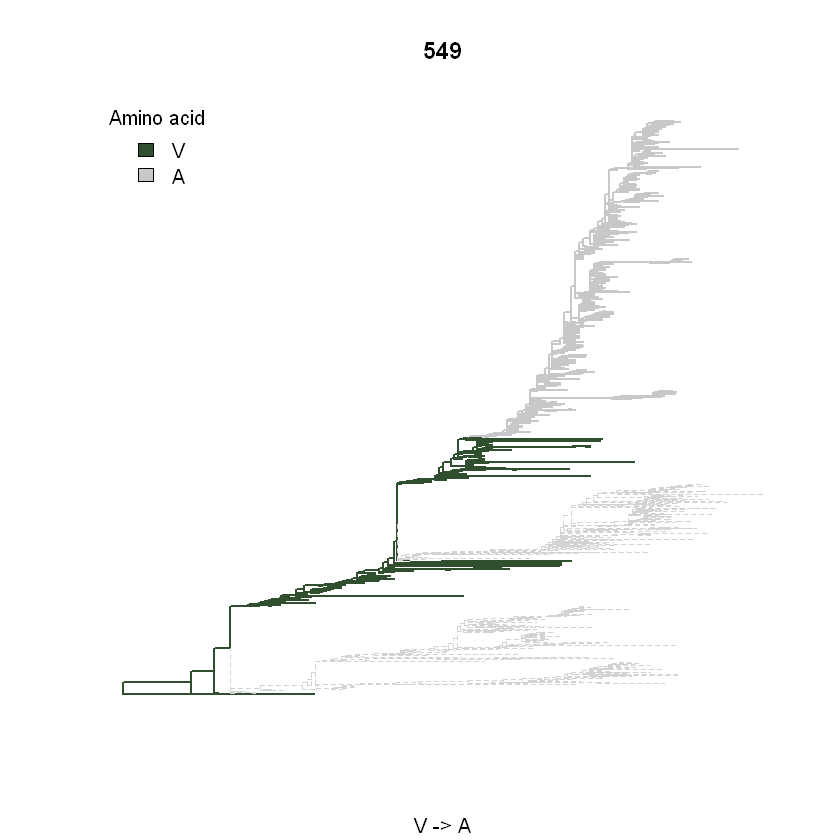

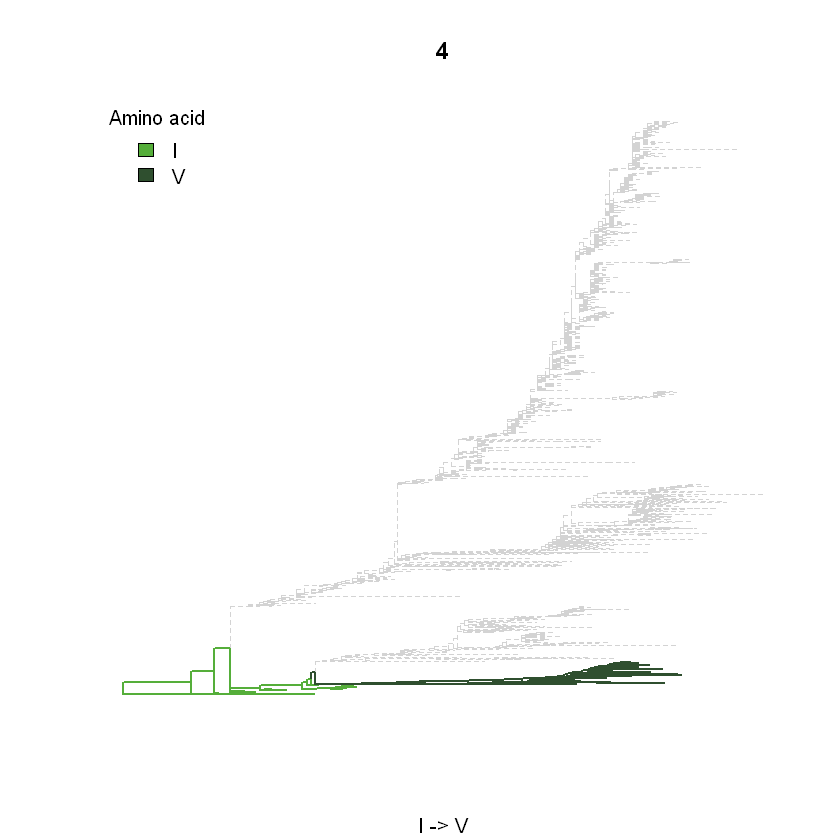

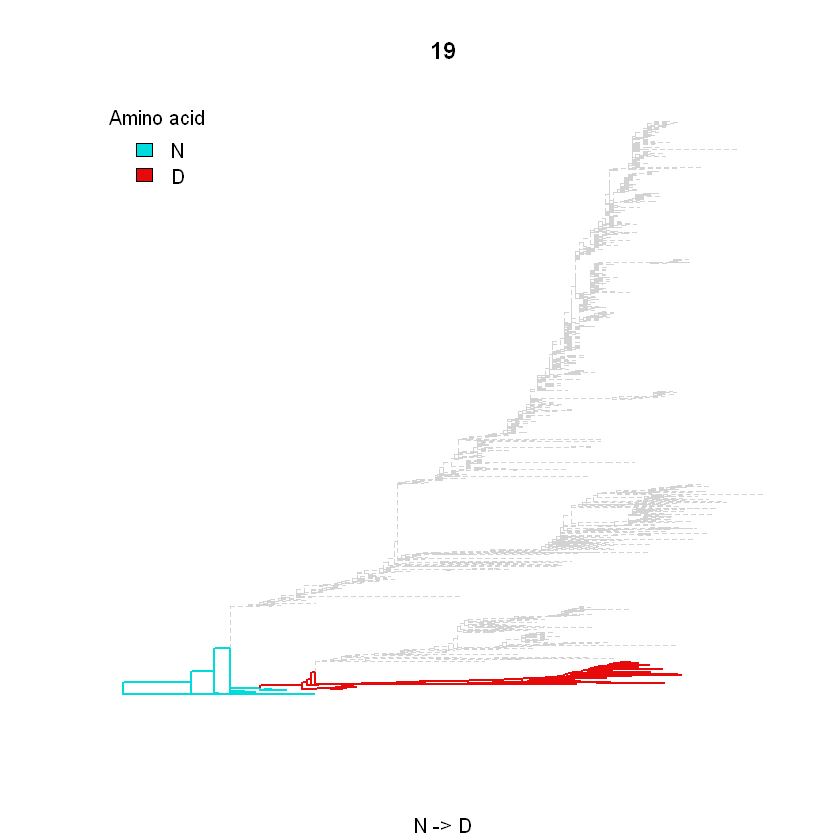

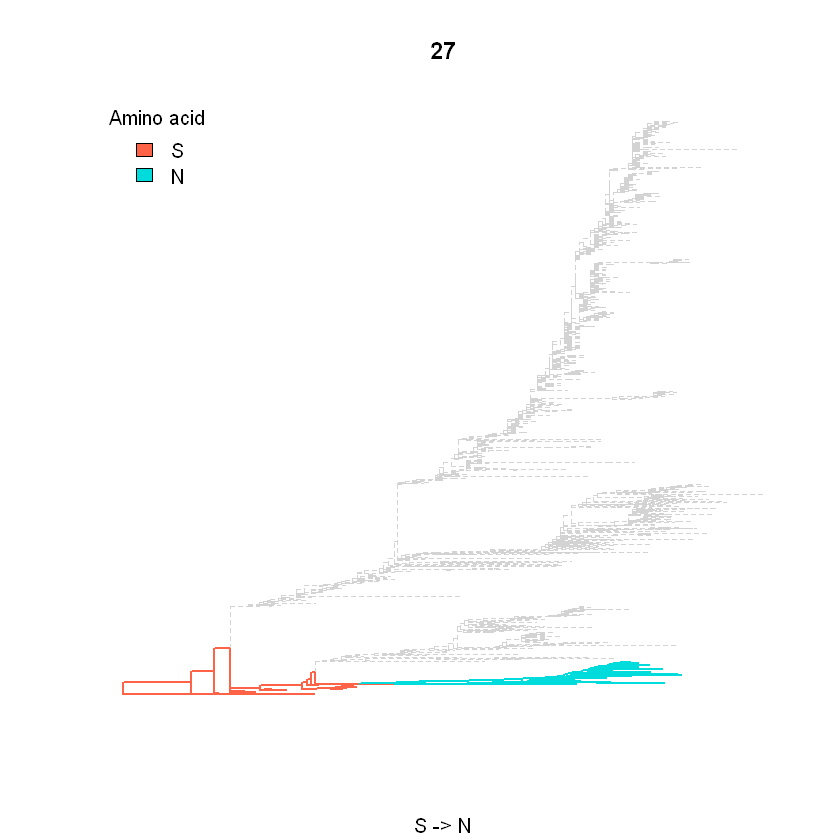

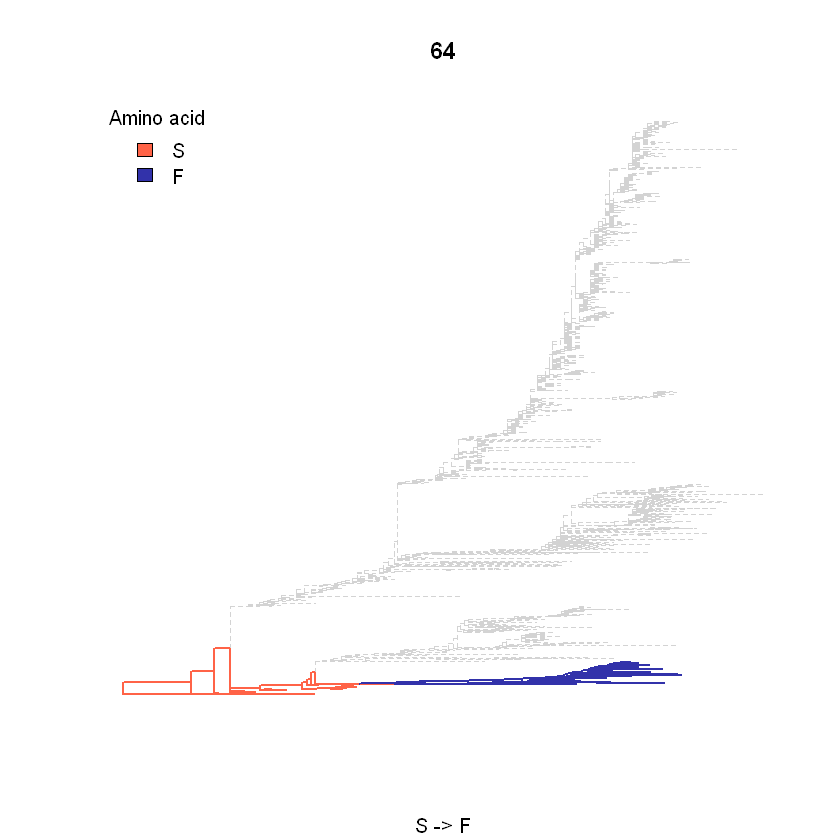

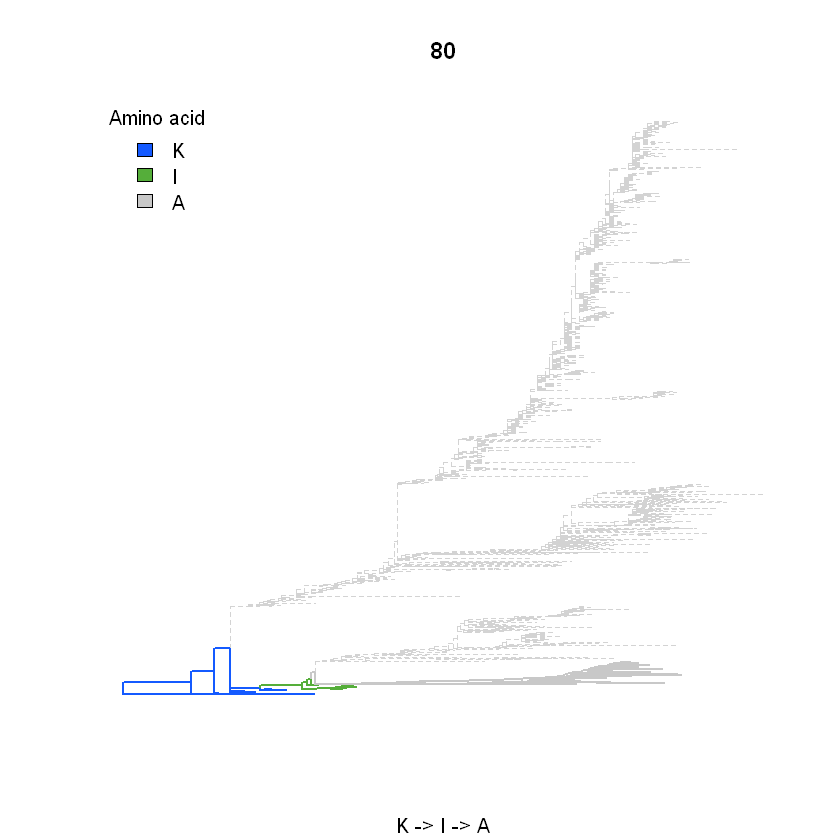

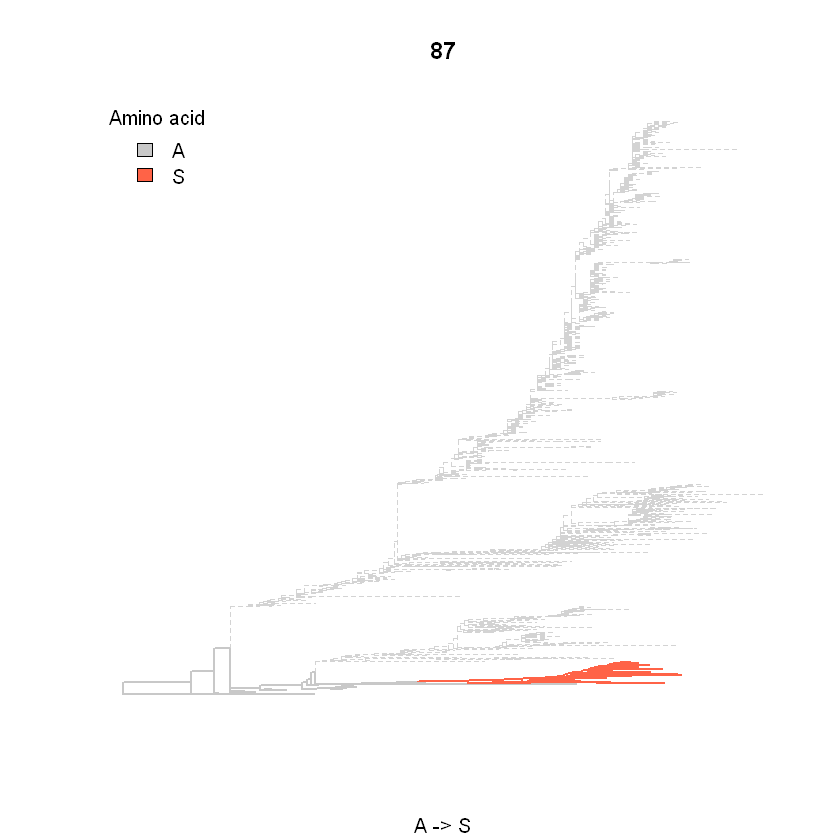

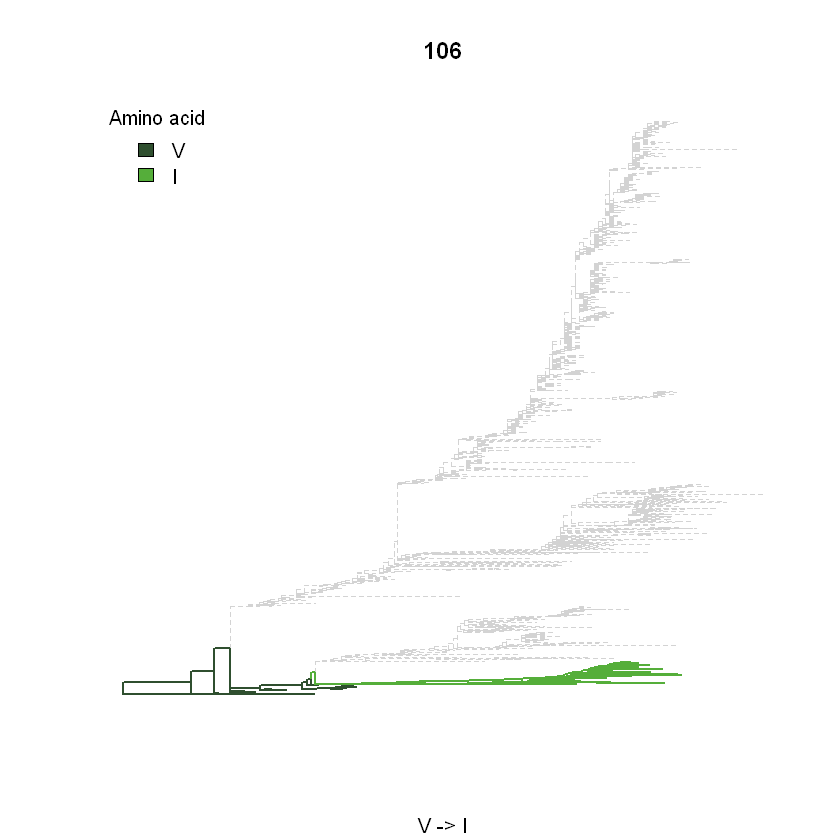

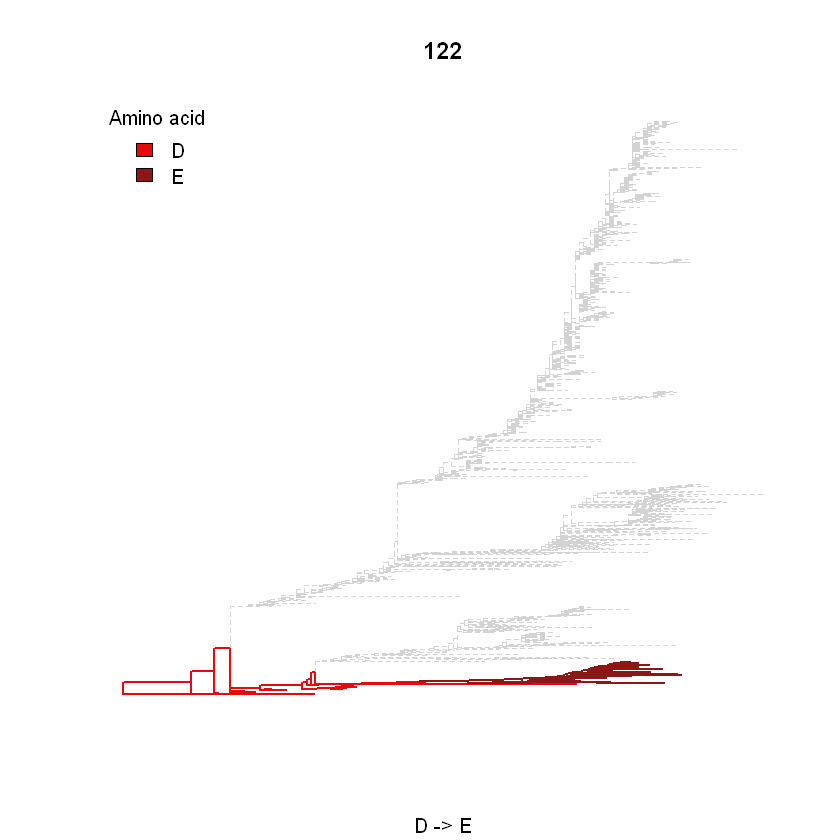

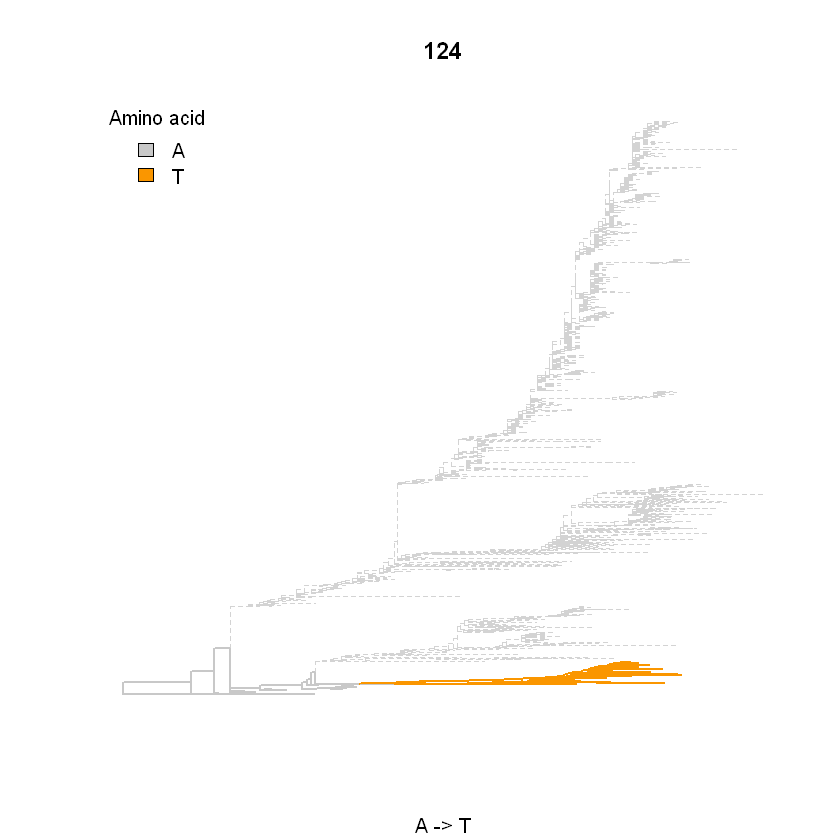

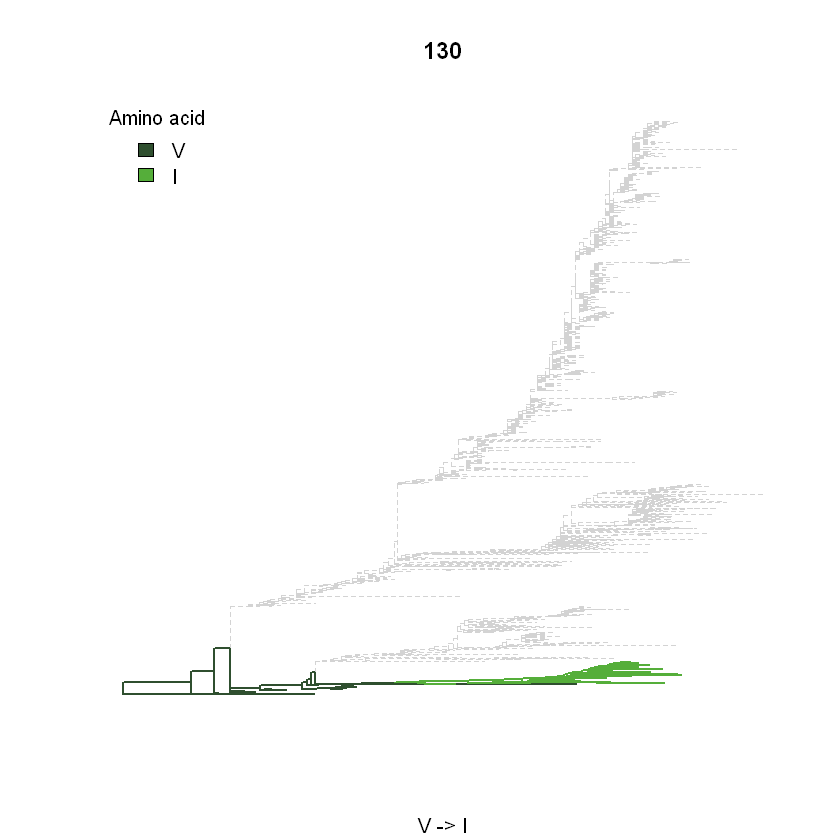

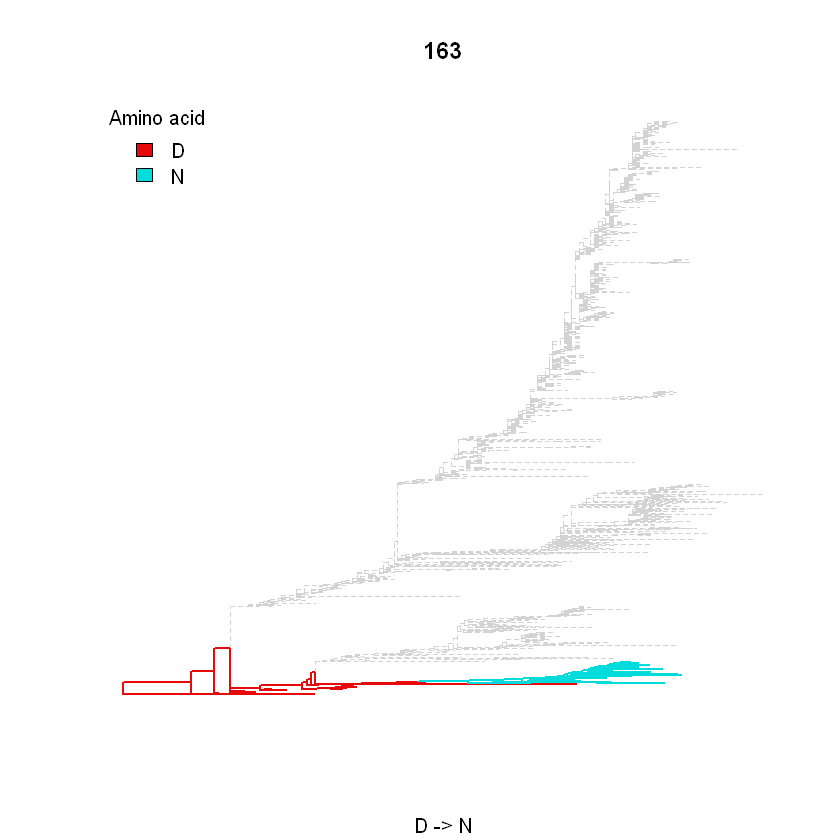

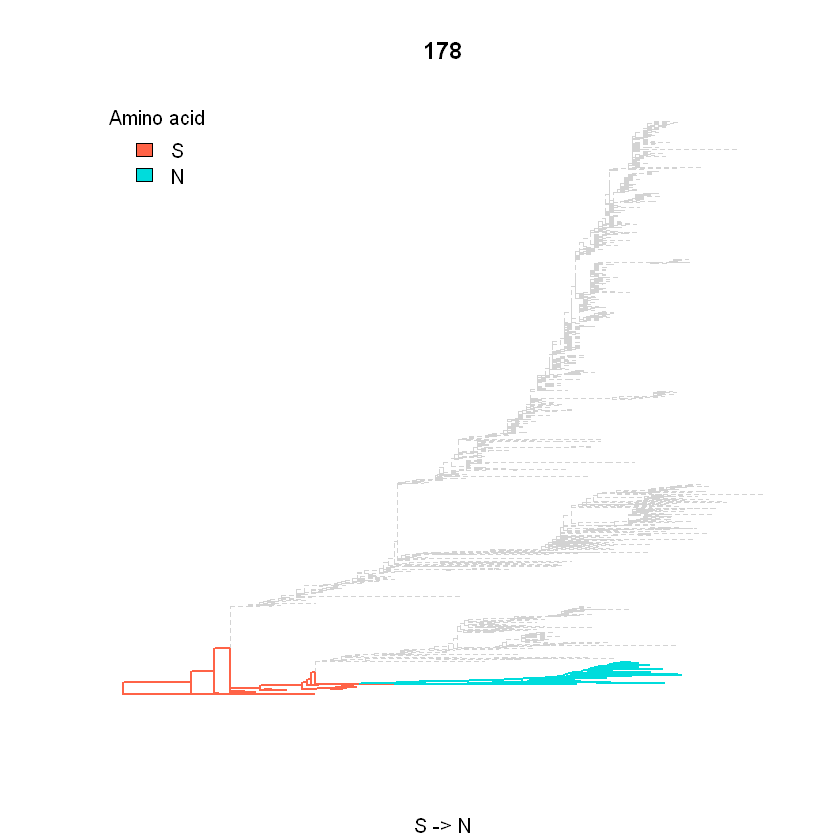

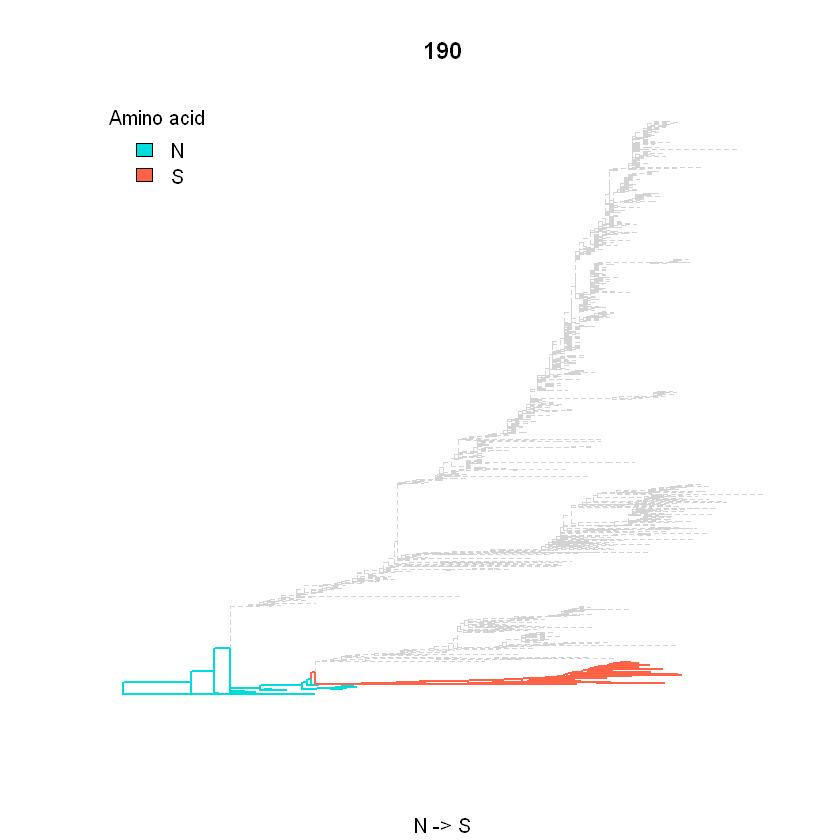

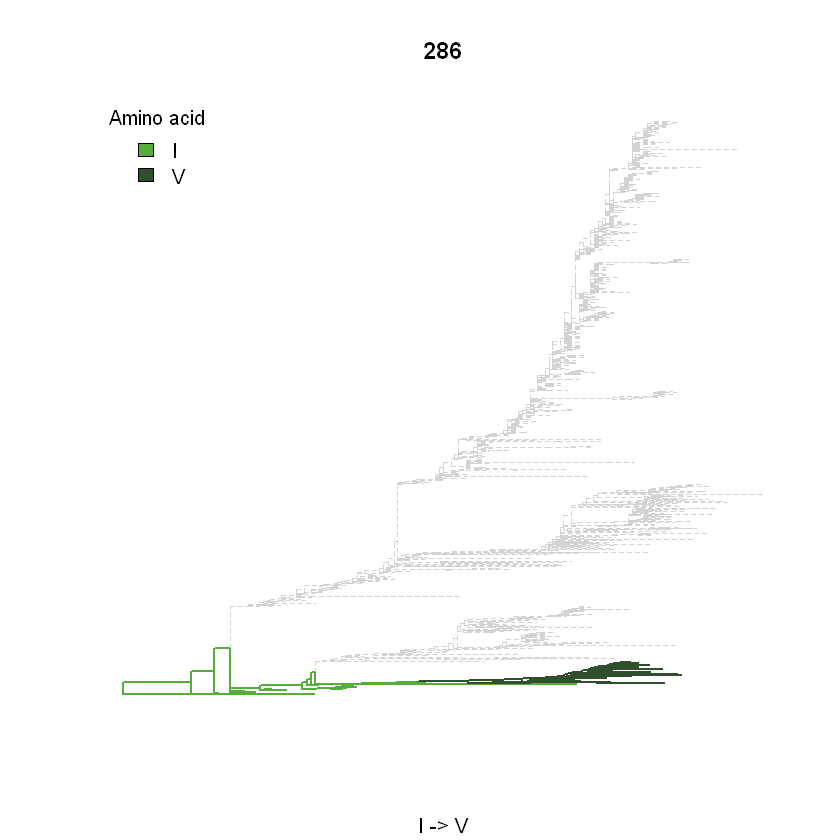

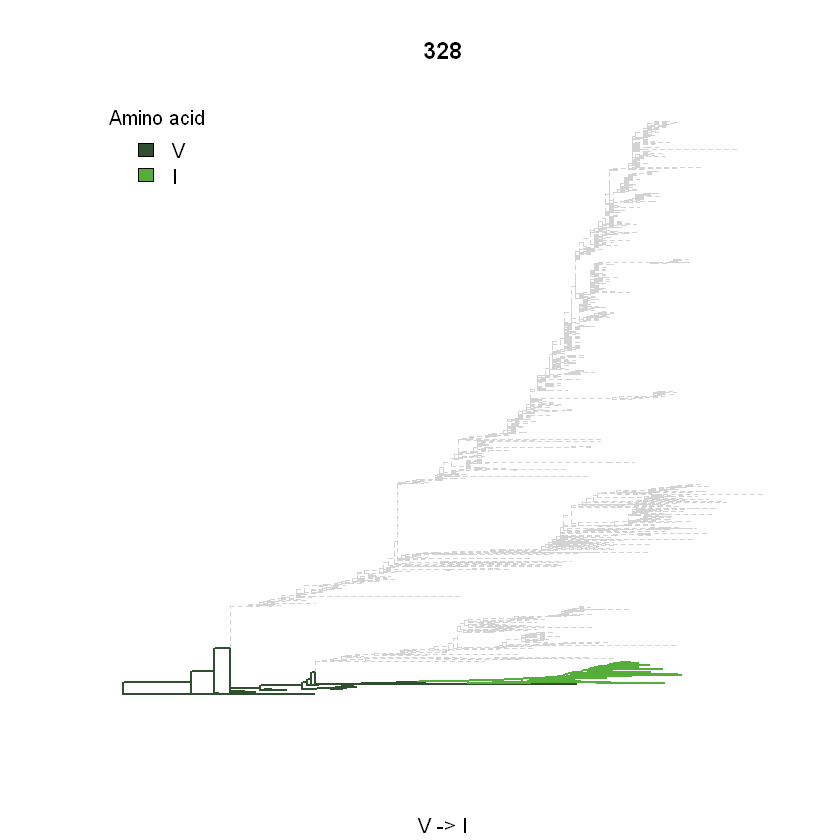

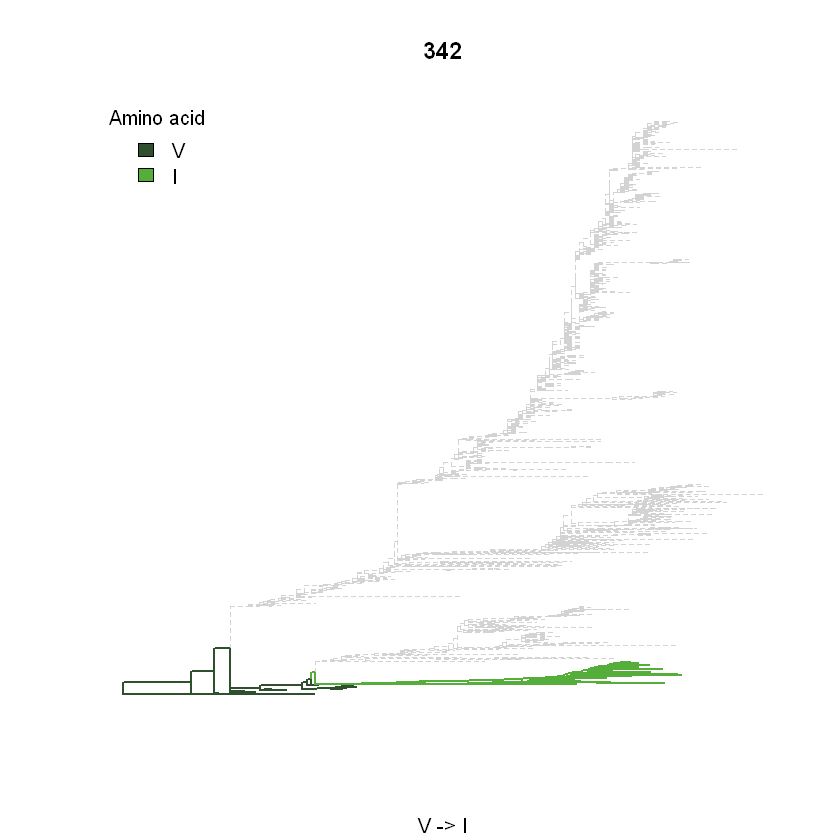

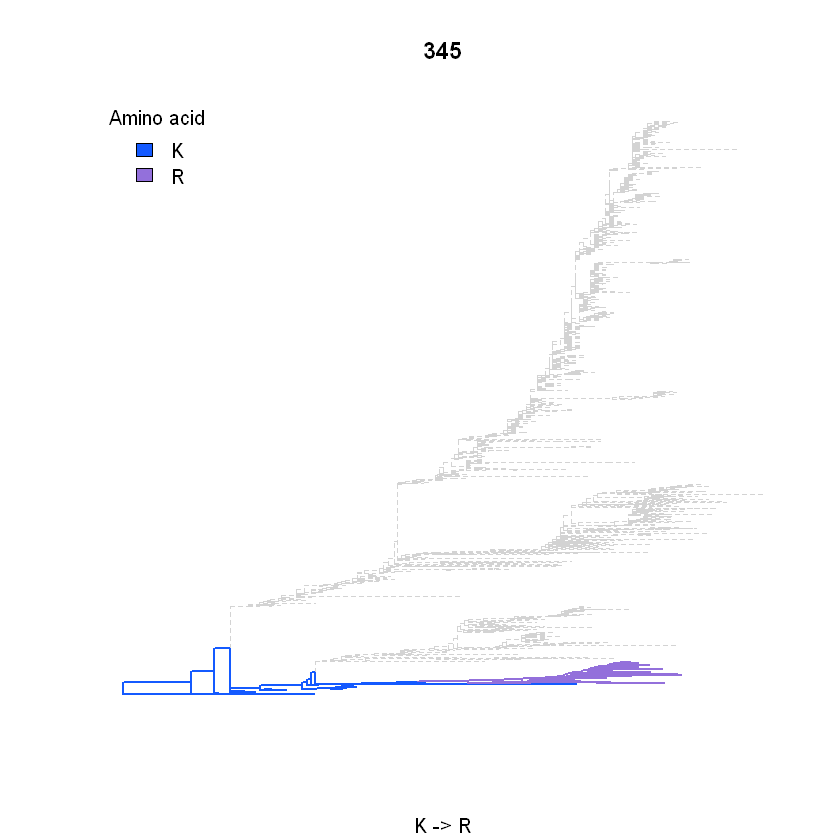

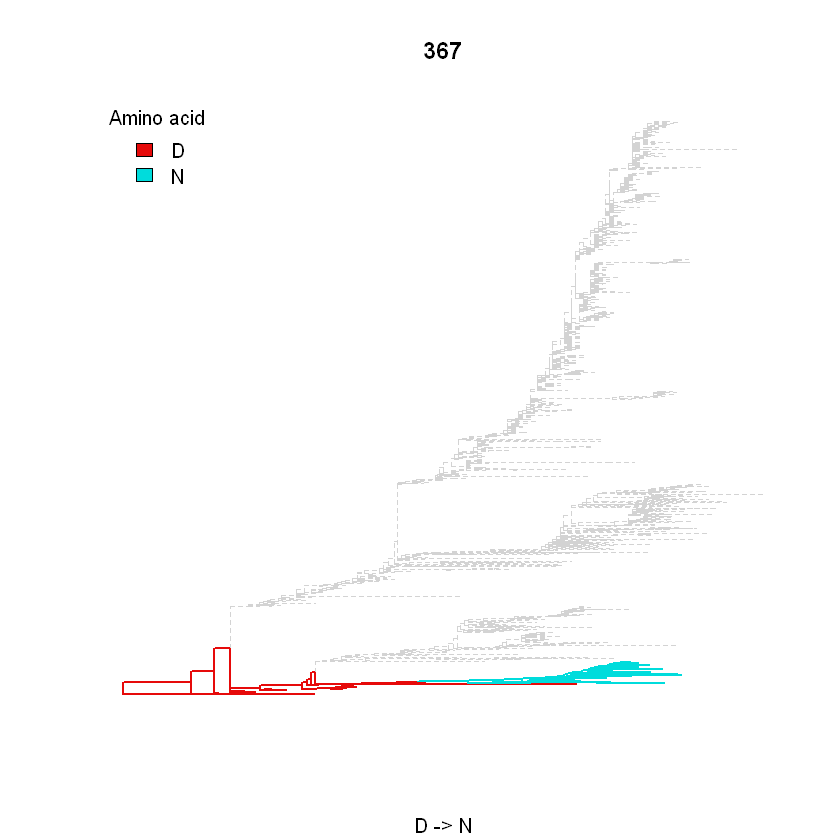

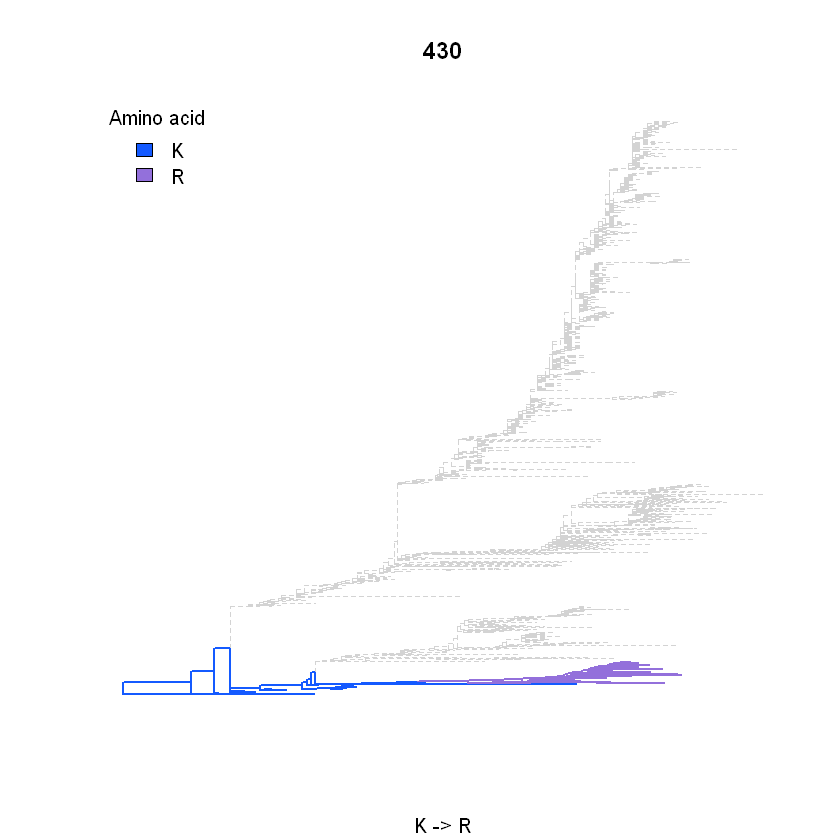

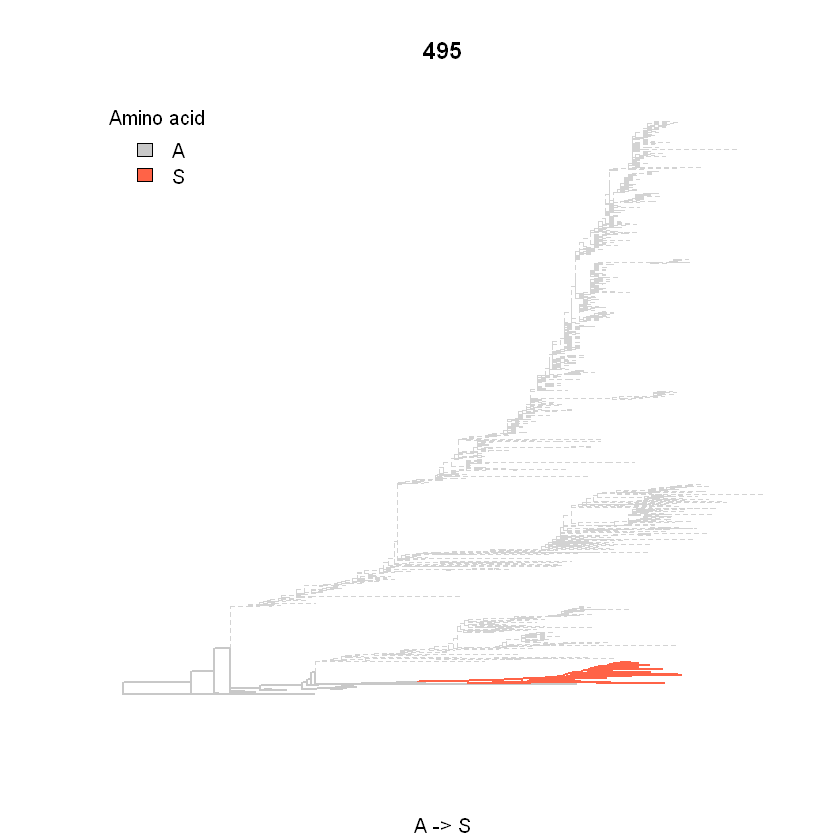

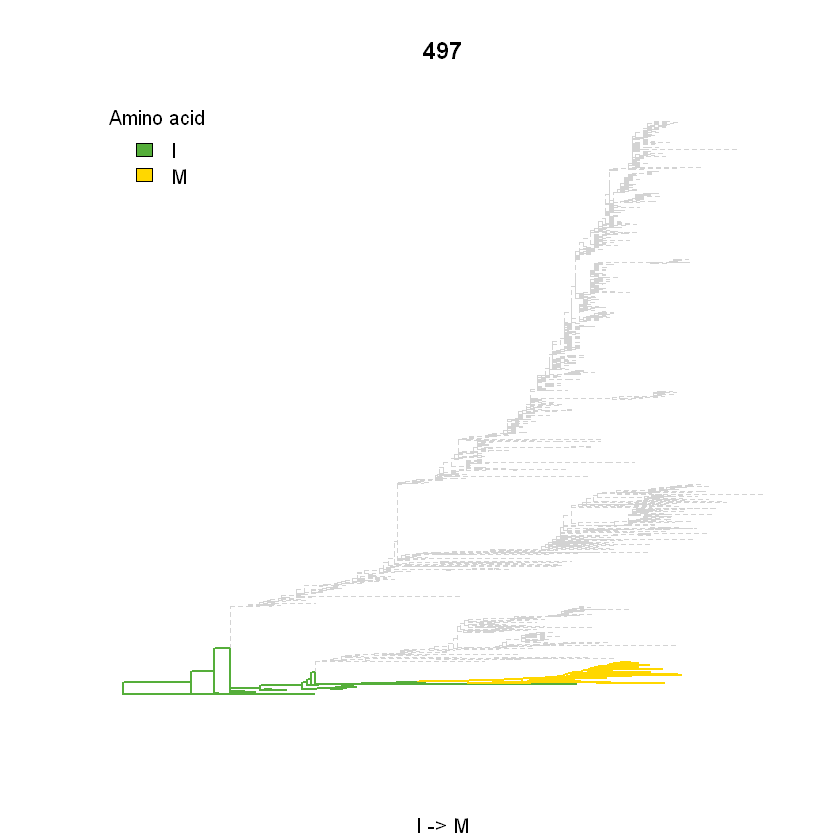

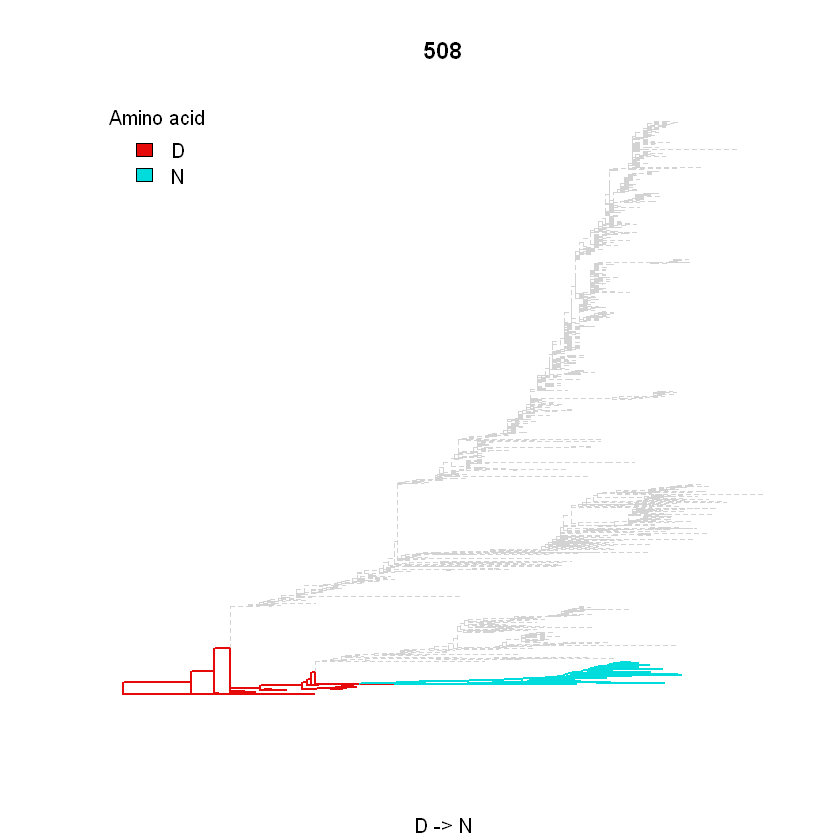

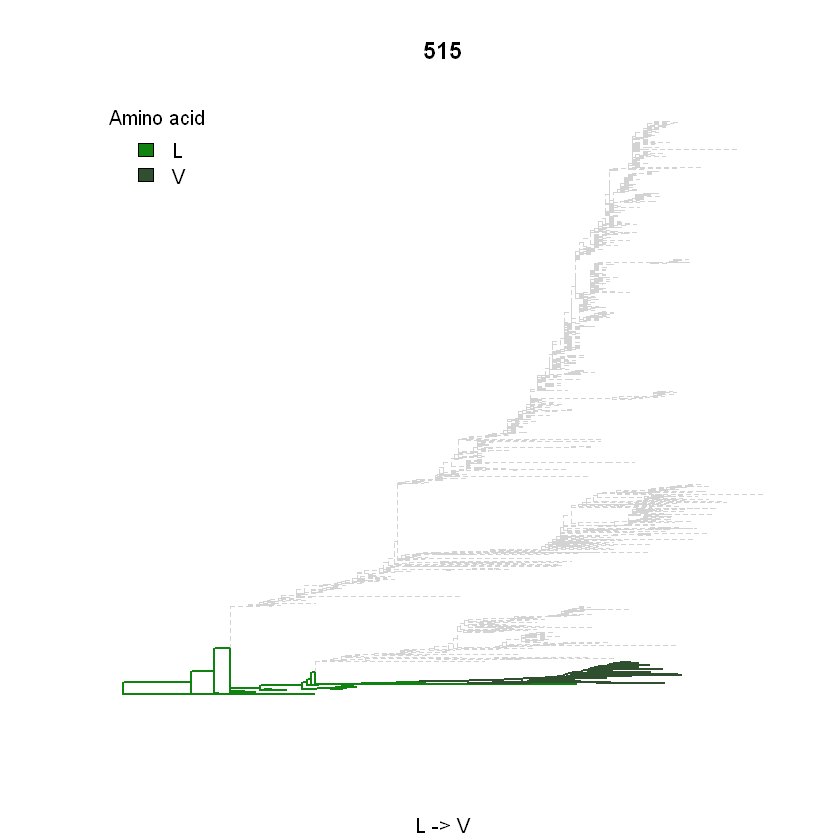

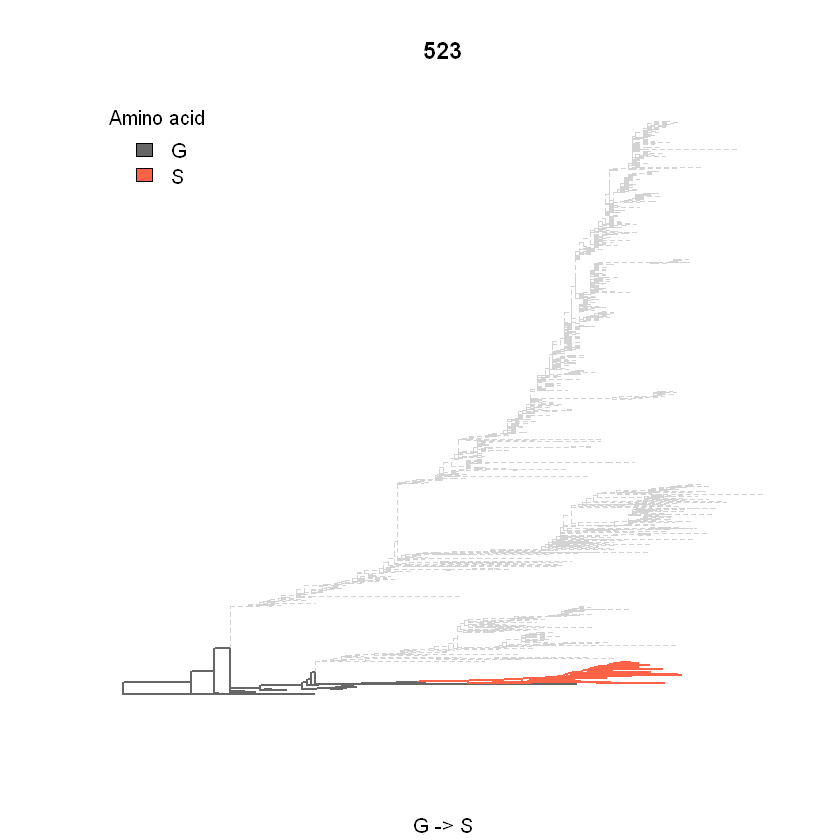

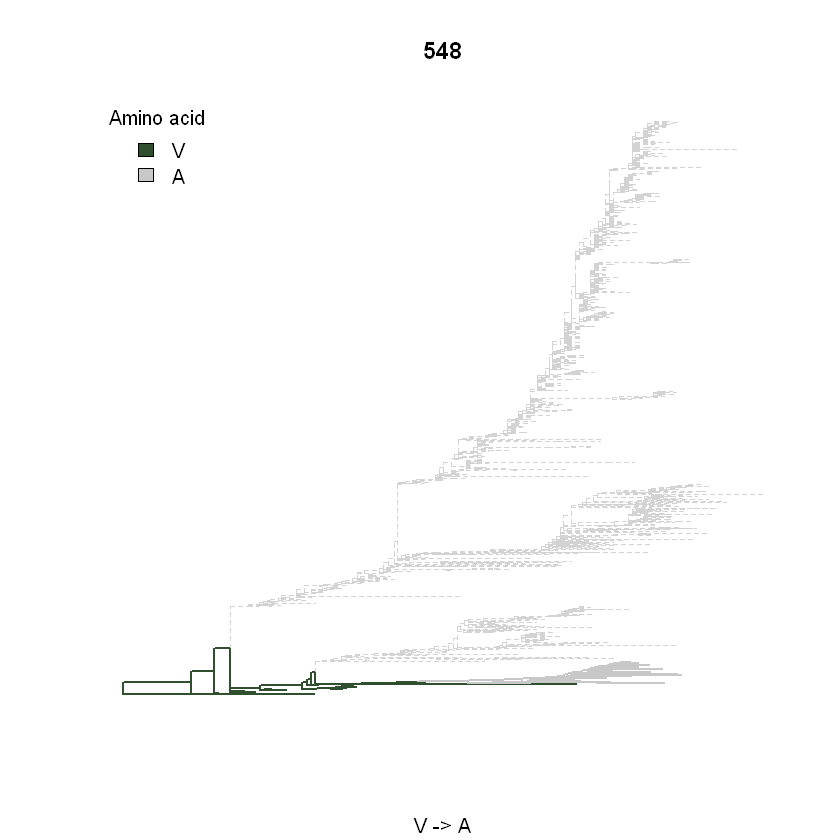

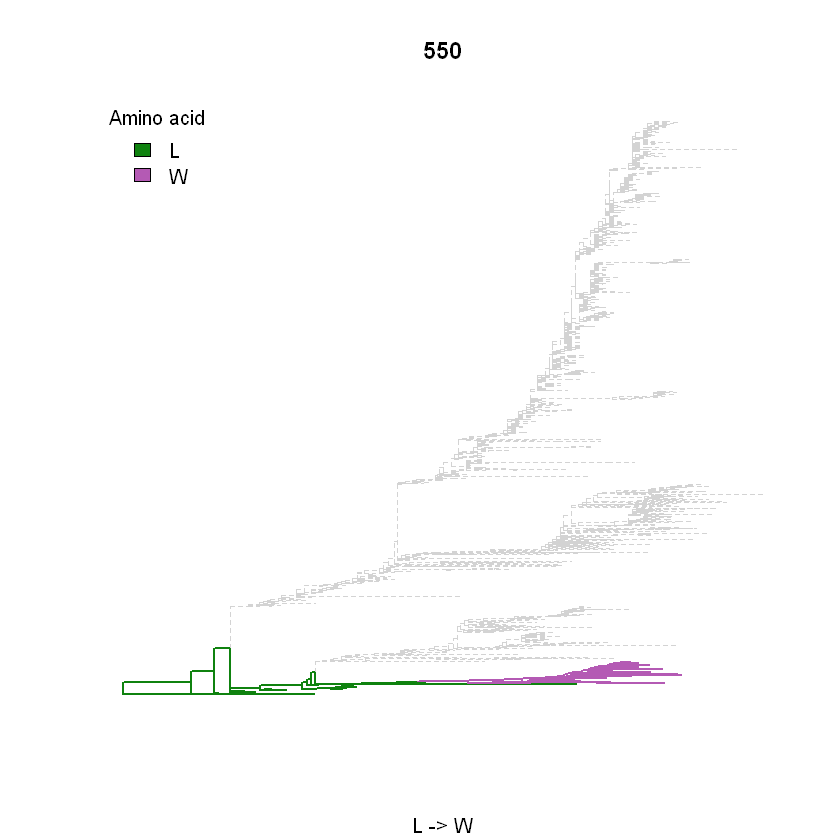

In [115]:
n <- 0

for (i in m) {
    n <- n + 1
    plot(i)
#     if (n > 5) break
}

In [90]:
groupByPath <- lapply(paths, function (p) {
    terminalTips <- sitePath:::.childrenTips(tree, p[length(p)])
    group <- list()
    for (sp in mutations) {
        site <- attr(sp, "site")
        for (mp in sp) {
            tips <- mp[[length(mp)]]
            if (all(terminalTips %in% tips)) {
                toAdd <- lapply(mp, function (tips) {
                    siteChar <- attr(tips, "AA")
                    attributes(tips) <- NULL
                    attr(tips, "site") <- site
                    names(attr(tips, "site")) <- siteChar
                    tips
                })
                group <- c(group, list(toAdd))
            }
        }
    }
    return(group)
})

In [120]:
grouping <- lapply(groupByPath, function (paths) {
    res <- paths[[1]]
    for (p in paths[-1]) {
        for (tips in p) {
            site <- attr(tips, "site")
            # Update grouping for each tips
            newGrouping <- list()
            for (i in seq_along(res)) {
#                 cat("First:", length(attr(res[[1]], "site")), "\t")
#                 cat("Last:", length(attr(res[[length(res)]], "site")), "\n")
                gp <- res[[i]]
                common <- sort(intersect(tips, gp))
                if (length(common) == 0) {
                    newGrouping <- res[1:i]
                } else {
                    if (identical(sort(gp), common)) {
                        # The new coming tips includes the current group
                        # The extra tips stay for the next loop
                        tips <- setdiff(tips, gp)
                        # Update the SNP site info for the current group
                        attr(gp, "site") <- c(attr(gp, "site"), site)
                        newGrouping <- c(newGrouping, list(gp))
                    } else if (identical(sort(tips), common)) {
                        # The new coming tips are included in the group (they are used up at this point)
                        separate <- setdiff(gp, tips)
                        attributes(separate) <- attributes(gp)
                        attr(tips, "site") <- c(attr(gp, "site"), site)
                        if (i + 1 <= length(res)) {
                            trailing <- res[(i + 1):length(res)]
                        } else {
                            trailing <- list()
                        }
                        newGrouping <- c(newGrouping, list(tips), list(separate), trailing)
                        break
                    } else {
                        stop("Something's not right")
                    }
                }
            }
            # The new coming tips are used up and update the grouping
            res <- newGrouping
        }
    }
    return(res)
})

In [130]:
print(lapply(grouping[[1]], function (tips) {
    cat("Tips: \n")
    print(tree[["tip.label"]][tips])
    cat("Sites: \n")
    print(attr(tips, "site"))
    cat("\n")
}))

Tips: 
 [1] "AAT12704" "AIL95882" "ABC39805" "ABB04283" "AFG72029" "AFG72040"
 [7] "AFG99138" "AFG99171" "AFG99116" "AFG99127" "ABC46565" "ABB53751"
[13] "AFH00714"
Sites: 
  A   I   V   A   L   D   N   G   N   K   K   N   N   S   D   I   G 
  6  11  15  17  43  71  81  96  99 101 110 140 144 161 207 350 498 

Tips: 
[1] "ABB96395" "ABB96330" "CAA29337" "AGO00313"
Sites: 
  A   I   V   A   L   D   N   G   N   K   K   N   N   P   T   D   D   Q   I   I 
  6  11  15  17  43  71  81  96  99 101 110 140 144 161 179 191 207 216 350 366 
  G 
498 

Tips: 
 [1] "CAA24270" "ABB46392" "AFG99072" "ABC02266" "AFG99039" "ABQ57239"
 [7] "ACU46716" "ACN90957" "AAA85781" "ABY16753" "AJS16294" "AGH30410"
[13] "AAY46202"
Sites: 
  A   I   A   A   L   K   D   N   G   N   K   K   N   N   P   G   T   D   D   Q 
  6  11  15  17  43  68  71  81  96  99 101 110 140 144 161 165 179 191 207 216 
  V   I   I   G 
263 350 366 498 

Tips: 
[1] "ABO52313" "AFG98951"
Sites: 
  A   I   A   A   L   K   N   N   G   N  

In [95]:
print(lapply(grouping, function (gp) {
    lengths(sapply(gp, attr, "site"))
}))

[[1]]
 [1] 17 21 24 28 29 30 30 30 30 30 32 33 33 33 35 36 40 40

[[2]]
 [1] 23 23 23 25 26 27 27 27 27 26 27 28 29 29 29 28 29 29 30 31 32 33 36 36 36
[26] 39 39 49

[[3]]
 [1] 29 29 29 29 33 33 34 34 34 34 35 35 35 35 35 35 36 38 39 39 39 40 40 43 43
[26] 43 45 45 45 45 45 45 45 46 46 46 46 46 46 46 47 47 47 47 48 48 48 48 48

[[4]]
[1]  5 10 14 16 27 37 39 58

